In [1]:

from sim import *
import copy
import importlib
# importlib.reload(*)
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# from matplotlib.animation import animation
import time
import pandas as pd
from scipy.spatial.transform import Rotation

from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
def a_ppn(p_robot,v_robot,p_target,v_target,N,bounds):
    r = p_target - p_robot
    v_relative = v_target - v_robot
    # omega = np.cross([r[0],r[1],0],[v_relative[0],v_relative[1],0])/np.dot(r,r)
    omega = np.cross(r,v_relative)/np.dot(r,r)
    vr_cap = unit_vector(v_robot)
    # a_ppn = -N*np.cross([v_robot[0],v_robot[1],0],omega)
    a_ppn = -N*np.cross(v_robot,omega)
    # a_ppn = np.array([a_ppn[0],a_ppn[1]])
    if bounds==0:
        return a_ppn
    if bounds==1:
        return min(2,np.linalg.norm(a_ppn))*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)<2:
        a_ppn = 2*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)>3:
        a_ppn = 3*unit_vector(a_ppn)
    return a_ppn

In [3]:
def unit_vector(vector):
    if np.linalg.norm(vector) == 0:
        return 0
    return vector/np.linalg.norm(vector)

def distance(a,b):
    return(np.linalg.norm(a-b))
#     return math.sqrt(np.dot(a-b,a-b))

def generate_random_objects(num=15,start=0,end=30):
    p_objects = []
    v_objects = []
    j = 0
    while j<num:
        temp_p = np.random.uniform(start,end,3)
        p_objects.append(temp_p)
        temp_v = unit_vector(np.random.uniform(start-30,end,3))
        v_objects.append(temp_v)
        j = j+1
    return [np.array(p_objects),np.array(v_objects)]

def angle_between(v1, v2):
    return np.math.atan2(np.linalg.det([v1,v2]),np.dot(v1,v2))

def perpendicular_to(v):
    v_homogenous = np.array([v[0],v[1],1])
    direction = np.cross(np.array([0,0,1]),v_homogenous)
    return np.array([direction[0],direction[1]])

def time_to_col(p1,p2,v1,v2,rad):#CHECK DOT PRODUCT SHUD BE v1-v2.p2-p1
    toc = abs((distance(p1,p2) - 2*rad)/np.dot(v1-v2,unit_vector(p1-p2)))
    return toc

def time_to_col2(p_r,p_t,v_r,v_t,rad=0):
    toc = ((distance(p_r,p_t) - rad)/np.dot(v_r-v_t,unit_vector(p_t-p_r)))
    return toc

def time_of_closest_approach(p_r,p_t,v_r,v_t):
    p_rel = p_t-p_r
    v_rel = v_r-v_t #The velocity is taken as v_t-v_r in Collision cone paper. We compenasate by removing the minus sign while calculating time
    v_radial = np.dot(v_rel,unit_vector(p_rel))
    toc = (np.linalg.norm(p_rel)*v_radial)/(np.dot(v_rel,v_rel))
    return(toc)

def check_VO(p_r,v_r,p_t,v_t,R=3):
    d_oi = distance(p_r,p_t)
    d_vo = ((d_oi**2)-(R**2))/d_oi
    r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
    alpha_vo = np.arctan(r_vo/d_vo)
    
    v_rel = v_r-v_t
    p_rel = p_t-p_r
    p_rel_mod = np.linalg.norm(p_rel)
    return(((np.dot(v_rel,p_rel)/(np.linalg.norm(v_rel)*p_rel_mod))>np.cos(alpha_vo)))
    
def time_to_col3(p_r,p_t,v_r,v_t,rad):
    if(check_VO(p_r,v_r,p_t,v_t,rad)):
        return(time_to_col2(p_r,p_t,v_r,v_t,rad))
    else:
        return(-1)

def plot_arrow(ax,p,v,marker="o",color='blue',qcolor='blue'):
    ax.scatter3D(p[...,0],p[...,1],p[...,2],s=10,marker=marker,color=color)
    ax.quiver(p[...,0],p[...,1],p[...,2],v[...,0],v[...,1],v[...,2],color=color)

def get_azimuth_elevation(v):
    return(np.arctan2(v[1],v[0]),np.arctan2(v[2],np.linalg.norm([v[0],v[1]])))#azimuth, elevation

def get_uvec_from_azimuth_elevation(a,e):

    return(np.array([np.cos(e)*np.cos(a),np.cos(e)*np.sin(a),np.sin(e)]))

In [4]:
time_of_closest_approach(p_r, p_t, v_r, v_t)
np.dot(p_t-p_r,v_r-v_t)

NameError: name 'p_r' is not defined

## Simulation Todo
* v_r=12.5
* v_t=7.5
* v_os=7.5,random b/n 5,10
* n_os=10,20,30,40,50
* 100,100,100
* rms accel,computaional time,mission time
* num_sim 50

In [44]:
print(np.array([np.random.uniform(start,end,n_obs),np.random.uniform(start,end,n_obs),np.random.uniform(start,end,n_obs)]).T.shape)
p_os.shape

(30, 3)


(30, 3)

In [218]:
start = 0
end = 100

# p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
# p_r = np.array([0,0,0])
# p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
# p_t = np.array([end,end,end])
# v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
# # v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
# v_t = np.array(unit_vector(p_r-p_t))
# v_r = 12.5*unit_vector(v_r)
# v_t = 7.5*unit_vector(v_t)
np.random.seed(1)
rand_v_ang = np.deg2rad(45)
p_r = np.array([0,0,0])
p_t = np.array([end,end,end])
v_r = 12.5*Rotation.from_rotvec(
    np.random.uniform(-rand_v_ang,rand_v_ang)*unit_vector(np.random.rand(3))).apply(unit_vector(p_t-p_r))
v_t = 7.5*Rotation.from_rotvec(
    np.random.uniform(-rand_v_ang,rand_v_ang)*unit_vector(np.random.rand(3))).apply(unit_vector(p_r-p_t))
print(v_r,v_t)
n_obs = 30
v_obs_range = (5,10)
p_os,v_os = (np.array([np.random.uniform(start+2*R,end,n_obs),
                       np.random.uniform(start+2*R,end,n_obs),
                       np.random.uniform(start+2*R,end,n_obs)]).T,
             np.array([np.random.uniform(*v_obs_range)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))

his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os",
                            "a_pf","a_ppn","accel",
                            "obs","comp_time","collision"])


fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
plot_arrow(ax,p_r,v_r,"o","blue")
plot_arrow(ax,p_t,v_t,"o","green")
plot_arrow(ax,p_os,v_os,"D","red")

plt.show()
# time.sleep(3)

dt = 0.01
R =10
rho = 40
rho = np.sqrt((2*((12.5+10)/omega_bound)+R)*R)
print("rho=",rho)

N = 3
K=3.5
least_distance = R
k_rep = 120
k_att = 0



mindist = rho
time_cc = 0
omega_prev = 0
omega = 0
omega_bound = np.deg2rad(30)
accel_bound = np.linalg.norm(v_r)*omega_bound
print("accel_bound",accel_bound)
max_obs = 10
sim_time_st = time.time()

# S_coll_prev = set()
while distance(p_r,p_t)>2:
#     dist_os = np.array([distance(p_oi,p_r) for p_oi in p_os])
    collision = False
    comp_time_st = time.time()
    dist_os = np.linalg.norm(p_os-p_r,axis=1)
    if(np.any(dist_os<least_distance)):
        print("collision")
        collision = True

    ind_rhos = np.nonzero(dist_os<rho)[0]
    tocs_rhos = np.array([time_of_closest_approach(p_r,p_oi,v_r,v_oi) for p_oi,v_oi in zip(p_os[ind_rhos],v_os[ind_rhos])])
    
    #removing negative tocs
#     ind_rhos = ind_rhos[tocs_rhos>0]
#     tocs_rhos = tocs_rhos[tocs_rhos>0]

    if(len(ind_rhos)>0):
        #selecting top n obstacles
#         #by toc
#         ind_rhos = ind_rhos[np.argsort(tocs_rhos)[:max_obs]]
#         tocs_rhos = tocs_rhos[np.argsort(tocs_rhos)[:max_obs]]
        
        #by dist
#         ind_rhos = ind_rhos[np.argsort(dist_os[ind_rhos])[:max_obs]]
#         tocs_rhos = tocs_rhos[np.argsort(dist_os[ind_rhos])[:max_obs]]
        
        #by weight of both
        weighted_vals = 0.9*unit_vector(dist_os[ind_rhos])+0.1*unit_vector(tocs_rhos)
        ind_rhos = ind_rhos[np.argsort(weighted_vals)[:max_obs]]
        tocs_rhos = tocs_rhos[np.argsort(weighted_vals)[:max_obs]]


        
        p_rels = p_os[ind_rhos]-p_r
        p_rels = np.expand_dims((np.linalg.norm(p_rels,axis=1)-
                                 np.where(dist_os[ind_rhos]>least_distance,least_distance,0)),-1)*np.apply_along_axis(unit_vector,1,p_rels)
        a_reps = k_rep*(-p_rels/np.expand_dims(np.linalg.norm(p_rels,axis=1)**3,-1))
#         a_reps = np.expand_dims((1/np.linalg.norm(p_rels,axis=1))-(1/rho),-1)*a_reps#multiplying the 11/||-/rho part
#         a_rep = np.sum(a_reps,axis=0)
        a_rep = np.sum(np.expand_dims(unit_vector(1/np.abs(tocs_rhos)),-1)*a_reps,0)#reciprocal
        
        #IF YOU WANT ONLY TURNING
        ##closest to arep and perp to v_r((vrXa_rep)Xv_r)
        a_rep = np.linalg.norm(a_rep)*unit_vector(np.cross(np.cross(v_r,a_rep),v_r))
    else:
        a_rep = np.array([0,0,0])
    

    a_att = k_att*(p_t-p_r)
    ppn_accel = a_ppn(p_r,v_r,p_t,v_t,N,0)
    #neutralising ppn from rep
    a_rep = a_rep+np.dot(ppn_accel,unit_vector(a_rep))*(-unit_vector(a_rep))
    #bounding a_rep
#     a_rep = min(np.linalg.norm(a_rep),accel_bound)*unit_vector(a_rep)

#     accel = a_rep+a_att+a_ppn(p_r,v_r,p_t,v_t,N,0)
    accel = a_rep+a_att+ppn_accel
    accel = min(np.linalg.norm(accel),accel_bound)*unit_vector(accel)
    comp_time_end = time.time()
    
    print(distance(p_r,p_t),accel,np.linalg.norm(a_rep),np.min(dist_os),ind_rhos)
    v_r = v_r + (accel*dt)
    p_r = p_r + v_r*dt
    time_cc = time_cc+dt
    p_os = p_os+(v_os*dt)
    p_t = p_t + (v_t*dt)
    his = his.append(pd.Series([p_r,v_r,p_t,v_t,p_os,v_os,
                                a_att+a_rep,a_ppn,accel,
                                ind_rhos,comp_time_end-comp_time_end,collision], index = his.columns),ignore_index=True)
        

[7.59244106 7.65756256 6.32191224] [-4.81183201 -2.71243275 -5.07335995]


<ipython-input-218-04548f38a833>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

rho= 30.974775103239004
accel_bound 6.5449846949787345
173.20508075688772 [-0.21956424  0.21926844 -0.00190342] 0.0 49.219488248596505 []
173.00780354474594 [-0.21963495  0.21924983 -0.00194829] 0.0 49.02601089926719 []
172.8105276557433 [-0.21970569  0.21923123 -0.00199318] 0.0 48.832538651110546 []
172.61325309397856 [-0.21977647  0.21921262 -0.00203808] 0.0 48.63907159005371 []
172.41597986355197 [-0.21984728  0.21919401 -0.00208299] 0.0 48.44560980333635 []
172.2187079685654 [-0.21991812  0.2191754  -0.00212793] 0.0 48.25215337953681 []
172.02143741312238 [-0.21998899  0.21915679 -0.00217288] 0.0 48.05870240859888 []
171.82416820132795 [-0.22005989  0.21913818 -0.00221784] 0.0 47.86525698185938 []
171.62690033728873 [-0.22013083  0.21911957 -0.00226282] 0.0 47.671817192076205 []
171.4296338251131 [-0.2202018   0.21910096 -0.00230782] 0.0 47.47838313345715 []
171.2323686689108 [-0.2202728   0.21908235 -0.00235284] 0.0 47.28495490168945 []
171.03510487279343 [-0.22034384  0.21906375 

153.6817187635095 [-0.21488671  0.32232194 -0.15128647] 0.18087831624346704 30.11141381039985 [22]
153.48460008988857 [-0.21519709  0.3253561  -0.15498706] 0.18604427752105712 29.919255476386084 [22]
153.2874847619506 [-0.21552472  0.32850434 -0.15881776] 0.19139654626841116 29.72712915244936 [22]
153.0903728304544 [-0.21587067  0.33177109 -0.16278338] 0.1969421859704162 29.535035572386175 [22]
152.89326434800418 [-0.21623603  0.33516099 -0.16688896] 0.20268860137062625 29.34297549201613 [22]
152.69615936912965 [-0.21662198  0.33867891 -0.17113979] 0.20864355855531566 29.150949690021378 [22]
152.49905795037103 [-0.21702976  0.34232996 -0.17554144] 0.2148152064265048 28.958958968825176 [22]
152.30196015036876 [-0.21746064  0.34611948 -0.18009974] 0.22121209967469796 28.767004155511867 [22]
152.104866029958 [-0.217916    0.3500531  -0.18482083] 0.22784322337213328 28.575086102790465 [22]
151.9077756522689 [-0.21839726  0.35413672 -0.18971117] 0.2347180193183431 28.383205690004498 [22]
15

137.34898578150396 [-1.26976671  3.90927838 -4.48538165] 6.167189340005482 14.44339428766279 [22]
137.15338414852158 [-1.37625183  4.18025742 -4.84439919] 6.705141843659052 14.264104230508012 [22]
136.95789609317208 [-1.38847823  4.15340623 -4.86396644] 7.3122606131554955 14.085483780082532 [22]
136.76252507688696 [-1.40119421  4.12665099 -4.88305551] 7.999370762403808 13.90756081375095 [22]
136.5672745651356 [-1.41440378  4.09999564 -4.90166527] 8.78129889837926 13.730364438713272 [22]
136.372148027368 [-1.42811124  4.07344412 -4.9197943 ] 9.676438297662733 13.553925057731316 [22]
136.17714893695367 [-1.44232109  4.04700034 -4.93744092] 10.707823023188402 13.378274438368322 [22]
135.98228077111662 [-1.45703794  4.02066813 -4.95460321] 11.904597684662107 13.203445785882563 [22]
135.78754701086658 [-1.47226641  3.99445123 -4.97127908] 13.304058126678411 13.029473819910336 [22]
135.59295114092592 [-1.48801111  3.96835324 -4.98746631] 14.95453061790415 12.856394855065778 [22]
135.39849664

collision
121.13442294997459 [-1.11895231  1.0895161  -1.39710591] 3.1109800001318115 7.623324064226459 [22]
collision
120.94792749337955 [-1.10182718  1.06151549 -1.35282687] 3.065214029443368 7.725505251003486 [22]
collision
120.76152349311343 [-1.08459894  1.03385711 -1.30882827] 3.0196800423741474 7.8311987316863805 [22]
collision
120.57520916695721 [-1.06734389  1.00661541 -1.26524396] 2.974548312637225 7.9402583929208355 [22]
collision
120.38898272769067 [-1.05013063  0.97985376 -1.22219071] 2.929967955524171 8.052541793383186 [22]
collision
120.2028423901967 [-1.03302025  0.95362524 -1.17976909] 2.8860679875731567 8.16791050435304 [22]
collision
120.01678637780383 [-1.01606663  0.92797338 -1.13806447] 2.8429585616690907 8.286230373974014 [22]
collision
119.83081292789478 [-0.99931679  0.90293304 -1.09714814] 2.800732317129479 8.40737172276129 [22]
collision
119.64492029681593 [-0.98281133  0.87853121 -1.05707844] 2.7594657933311892 8.531209477944287 [22]
collision
119.4591067641

106.86712737203229 [ 0.2131927  -0.01434569 -0.67160746] 2.8165196507775785 20.57401631478333 [22 18]
106.69661060397746 [ 0.238817   -0.02776448 -0.64541884] 2.7920737187472264 20.7562025719795 [22 18]
106.52616075964548 [ 0.26187407 -0.03992258 -0.62120141] 2.7703903954220497 20.93848287984003 [22 18]
106.35577597624496 [ 0.28252275 -0.05087565 -0.59908472] 2.7515188419405865 21.120854337065815 [22 18]
106.18545458539013 [ 0.30091341 -0.06067552 -0.57919807] 2.735517967198869 21.303314178693274 [22 18]
106.01519511615726 [ 0.31718718 -0.06937031 -0.56166678] 2.722451979731926 21.485859766826927 [22 18]
105.84499629823337 [ 0.33147599 -0.07700511 -0.54660697] 2.7123843247097557 21.668488581822732 [22 18]
105.67485706486974 [ 0.34390314 -0.08362288 -0.53411897] 2.705370150202904 21.851198213889464 [22 18]
105.50477655524892 [ 0.35458441 -0.08926576 -0.52427984] 2.7014478518266234 22.033986355083016 [22 18]
105.33475411580615 [ 0.3636293  -0.09397631 -0.51713594] 2.7006306778474576 22.2

91.5034932253666 [-1.10134154  0.58587701 -2.29273606] 5.82703027459872 15.826793133684108 [18  7]
91.34075825209395 [-1.14249348  0.61019295 -2.49170822] 6.044872279691024 15.79671902522863 [18  7]
91.17828954811172 [-1.18303791  0.6316861  -2.674067  ] 6.248056283327835 15.769148487416699 [18  7]
91.01610124251083 [-1.22148889  0.64971306 -2.83765429] 6.433743965539677 15.744111802719988 [18  7]
90.85420633049735 [-1.25676021  0.66388729 -2.98101837] 6.599976532791241 15.721636179926385 [18  7]
90.69261652998455 [-1.28815436  0.67406928 -3.10351023] 6.745743469445646 15.701745528082345 [18  7]
90.53134220016345 [-1.31532138  0.68033316 -3.20525751] 6.870929903647811 15.684460329601928 [18  7]
90.37039232007605 [-1.33819562  0.68291818 -3.2870474 ] 6.976173189963313 15.669797608769464 [18  7]
90.20977451866567 [-1.35692222  0.68217498 -3.3501593 ] 7.0626707537265325 15.657770981897526 [18  7]
90.04949514406292 [-1.37178507  0.67851511 -3.39618589] 7.131979472362693 15.648390769926712 

76.59593034900573 [-1.41315823  0.44613073  2.48119951] 4.548229109645218 23.519098467312265 [18 27]
76.45907529771398 [-1.33624475  0.43597868  2.88200573] 4.321195396635956 23.662522192291632 [18 27]
76.32221979071099 [-1.16046003  0.40283084  3.37656401] 3.993480489600973 23.806516071807593 [18 27]
76.18531982488634 [-0.80214267  0.32540732  3.96339034] 3.505288105154254 23.951047193152846 [18 27]
76.04831610157528 [-0.13028163  0.16877517  4.57373654] 2.7652597936678007 24.096073690243728 [18 27]
75.91113301600612 [ 0.97777283 -0.10411663  4.97113244] 1.668209327539277 24.241542809256465 [18 27]
75.77369039616802 [ 2.38962546 -0.47086917  4.72744833] 0.20323019105958803 24.387395239519964 [18 27]
75.63594119033172 [ 3.50373931 -0.78435043  3.66634326] 1.3768927426546342 24.53358487091814 [18 27]
75.49791235820656 [ 3.84373863 -0.91033326  2.3190478 ] 2.684689946871398 24.680105210150575 [18 27]
75.35968784961595 [ 3.60894514 -0.88326701  1.25985486] 3.5748895586537883 24.8269859460

64.70026814378743 [ 0.08494824 -0.03019904  0.57116907] 6.5827247762595995 24.927309444237338 [27]
64.57345996187478 [ 0.08525057 -0.03055182  0.57032572] 6.6098524799526235 24.934115612674503 [27]
64.44683799467987 [ 0.08551947 -0.03089364  0.56944543] 6.637151251411782 24.94163097175084 [27]
64.32040355624811 [ 0.08575521 -0.0312245   0.56852829] 6.664621270242135 24.949855320459697 [27]
64.19415797347732 [ 0.08595807 -0.03154442  0.56757445] 6.692262682874835 24.958788392553156 [27]
64.06810258615535 [ 0.08612836 -0.0318534   0.56658406] 6.72007560261421 24.968429856671726 [27]
63.94223874699531 [ 0.08626637 -0.03215144  0.56555728] 6.7480601097121395 24.978779316504106 [27]
63.816567821668194 [ 0.08637241 -0.03243857  0.56449434] 6.776216251469018 24.989836310976965 [27]
63.691091188833084 [ 0.0864468  -0.0327148   0.56339543] 6.804544042360679 25.001600314474526 [27]
63.56581024016487 [ 0.08648987 -0.03298015  0.56226082] 6.833043464190509 25.014070737087565 [27]
63.44072638037949

53.6065372094332 [ 0.01642042 -0.02411934  0.38611132] 9.898944532713815 28.599666993514365 [27]
53.505429397858634 [ 0.01525544 -0.02380041  0.38394647] 9.93948237020563 28.666149476137836 [27]
53.40469119827878 [ 0.01409023 -0.02347982  0.3817922 ] 9.98009486591596 28.733112253077877 [27]
53.30432505870905 [ 0.01292495 -0.02315765  0.37964878] 10.02077999715084 28.800551994546268 [27]
53.20433343572664 [ 0.01175969 -0.02283396  0.37751646] 10.061535714210562 28.86846537647745 [27]
53.104718794356856 [ 0.01059459 -0.02250883  0.37539552] 10.102359939964588 28.936849081050386 [27]
53.00548360795725 [ 0.00942976 -0.02218235  0.37328618] 10.143250569426712 29.00569979719716 [27]
52.90663035809957 [ 0.0082653  -0.02185458  0.37118869] 10.184205469330912 29.075014221098307 [27]
52.808161534449525 [ 0.00710131 -0.0215256   0.36910327] 10.225222477708645 29.144789056665157 [27]
52.71007963464435 [ 0.00593788 -0.02119546  0.36703015] 10.266299403468127 29.21502101600896 [27]
52.61238716416799

44.03002536044704 [ 1.96871188 -3.32165122  5.28466   ] 0.0 32.398719541367925 []
43.935903974118396 [ 1.95265214 -3.34957033  5.2729833 ] 0.0 32.34172913852117 []
43.841790830853256 [ 1.93653911 -3.37739729  5.26116228] 0.0 32.28466195589513 []
43.747688845622626 [ 1.92037324 -3.40513133  5.24919727] 0.0 32.227521134963894 []
43.65360094637816 [ 1.90415498 -3.43277169  5.2370886 ] 0.0 32.170309844258036 []
43.55953007407188 [ 1.88788477 -3.46031762  5.22483662] 0.0 32.113031279547016 []
43.465479182674684 [ 1.87156306 -3.48776838  5.21244166] 0.0 32.055688664021105 []
43.37145123919366 [ 1.8551903  -3.51512321  5.19990408] 0.0 31.998285248472694 []
43.27744922368812 [ 1.83876695 -3.54238137  5.18722421] 0.0 31.940824311476902 []
43.18347612928435 [ 1.82229345 -3.56954211  5.17440242] 0.0 31.883309159571372 []
43.08953496218891 [ 1.80577025 -3.5966047   5.16143905] 0.0 31.825743127435192 []
42.99562874170064 [ 1.78919782 -3.6235684   5.14833448] 0.0 31.76812957806684 []
42.901760500221

36.237568283445675 [ 3.26474202 -5.57037686  1.07200084] 12.608028080778213 28.395167617283604 [16]
36.17436999201636 [ 3.22700805 -5.59127956  1.07742125] 12.587617131522345 28.383182805077645 [16]
36.11167376332604 [ 3.18926538 -5.61190133  1.08257767] 12.56696433002112 28.372029074977263 [16]
36.04948185021288 [ 3.15151726 -5.63224395  1.0874703 ] 12.546075748360016 28.361710172470122 [16]
35.98779650193041 [ 3.11376688 -5.65230921  1.09209936] 12.524957458690427 28.35222976610449 [16]
35.926619963525994 [ 3.07601741 -5.6720989   1.09646507] 12.503615532316338 28.343591446190874 [16]
35.86595447521383 [ 3.03827193 -5.6916148   1.1005677 ] 12.482056038796182 28.3357987235334 [16]
35.80580227174273 [ 3.0005335  -5.71085873  1.10440751] 12.460285045058228 28.32885502819199 [16]
35.74616558175873 [ 2.96280511 -5.72983247  1.10798482] 12.438308614528042 28.322763708276664 [16]
35.687046627162985 [ 2.92508973 -5.74853784  1.11129992] 12.416132806266308 28.31752802877494 [16]
35.6284476224

32.798750939918904 [ 0.1354519  -6.5181404   0.57647473] 10.497031029599388 30.78949413134257 [16]
32.78704850425335 [ 0.10499234 -6.5200894   0.56056716] 10.476665780812176 30.855897667104063 [16]
32.77596108588128 [ 0.07466658 -6.52187242  0.54445354] 10.456494195454896 30.92311602901362 [16]
32.765488197528434 [-1.72123119 -5.59253619  2.93218806] 0.0 30.99114563724904 []
32.75555113329444 [-1.74684076 -5.59638388  2.90961501] 0.0 31.059682253861393 []
32.74615000174679 [-1.77240185 -5.60007733  2.88696212] 0.0 31.128723413630304 []
32.73728485978154 [-1.79791376 -5.60361644  2.86423001] 0.0 31.198266630555636 []
32.72895571256637 [-1.82337578 -5.60700114  2.8414193 ] 0.0 31.268309398445115 []
32.721162513497326 [-1.84878723 -5.61023133  2.81853063] 0.0 31.33884919149763 []
32.7139051641693 [-1.87414739 -5.61330692  2.79556463] 0.0 31.409883464882196 []
32.70718351436038 [-1.89945558 -5.61622785  2.77252194] 0.0 31.481409655312156 []
32.70099736203 [-1.9247111  -5.61899403  2.749403

34.35307660369678 [-3.98798557 -5.18062193  0.30651623] 0.0 35.452915906509745 []
34.39038551821402 [-4.00524174 -5.16883437  0.2793108 ] 0.0 35.453949820811175 []
34.42800901114716 [-4.02238763 -5.15690498  0.25209807] 0.0 35.45623892996734 []
34.46594349416213 [-4.03942279 -5.14483408  0.22487879] 0.0 35.459785968180384 []
34.50418536995446 [-4.05634675 -5.13262201  0.1976537 ] 0.0 35.464593498271434 []
34.542731032742395 [-4.07315905 -5.12026912  0.17042356] 0.0 35.47066391074078 []
34.581576868754844 [-4.08985922 -5.10777574  0.14318911] 0.0 35.477999422919936 []
34.620719256714096 [-4.10644683 -5.09514224  0.1159511 ] 0.0 35.48660207821653 []
34.66015456831327 [-4.12292141 -5.08236895  0.08871028] 0.0 35.49647374545288 []
34.69987916868835 [-4.13928253 -5.06945624  0.0614674 ] 0.0 35.507616118299026 []
34.739889416884736 [-4.15552972 -5.05640447  0.0342232 ] 0.0 35.52003071480067 []
34.78018166631832 [-4.17166256 -5.043214    0.00697844] 0.0 35.53371887700267 []
34.82075226523091 

39.66613999505272 [-5.1494553  -3.07724137 -2.61734987] 0.0 43.00573729697898 []
39.716637523061074 [-5.15222708 -3.05244895 -2.64082113] 0.0 43.13022821414705 []
39.76706964188785 [-5.1548577  -3.02757326 -2.66421975] 0.0 43.25546093298948 []
39.817433579515885 [-5.15734712 -3.002615   -2.68754507] 0.0 43.38142774847616 []
39.86772657820765 [-5.15969526 -2.97757485 -2.71079648] 0.0 43.50812097326319 []
39.91794589451332 [-5.16190206 -2.95245349 -2.73397333] 0.0 43.63553293874641 []
39.968088799277396 [-5.16396747 -2.92725163 -2.75707499] 0.0 43.76365599607975 []
40.01815257764374 [-5.16589144 -2.90196995 -2.78010084] 0.0 43.89248251715877 []
40.06813452905926 [-5.16767393 -2.87660915 -2.80305024] 0.0 44.02200489556979 []
40.11803196727619 [-5.16931488 -2.85116993 -2.82592257] 0.0 44.1522155475053 []
40.16784222035297 [-5.17081426 -2.82565299 -2.8487172 ] 0.0 44.283106912646026 []
40.2175626306539 [-5.17217204 -2.80005902 -2.87143353] 0.0 44.4146714550102 []
40.26719055484742 [-5.17338

44.03173882828306 [-4.72134684 -0.27431278 -4.52442938] 0.0 58.16156778998132 []
44.063966890948215 [-4.71017043 -0.2448562  -4.53774885] 0.0 58.327203094581996 []
44.09591942001445 [-4.69886553 -0.21539333 -4.5509442 ] 0.0 58.49296481350618 []
44.12759499975751 [-4.68743245 -0.18592498 -4.56401508] 0.0 58.65884858793553 []
44.15899222662264 [-4.6758715  -0.15645196 -4.57696113] 0.0 58.82485008782656 []
44.19010970920395 [-4.66418301 -0.12697506 -4.589782  ] 0.0 58.99096501168679 []
44.220946068224485 [-4.65236731 -0.0974951  -4.60247735] 0.0 59.15718908635138 []
44.251499936516254 [-4.64042472 -0.06801288 -4.61504684] 0.0 59.32351806676027 []
44.28176995900094 [-4.62835556 -0.03852921 -4.62749013] 0.0 59.48994773573586 []
44.31175479267073 [-4.61616019 -0.00904488 -4.63980689] 0.0 59.65647390376129 []
44.341453106569645 [-4.60383893  0.02043929 -4.65199678] 0.0 59.823092408759436 []
44.37086358177508 [-4.59139212  0.04992249 -4.66405948] 0.0 59.98979911587268 []
44.39998491137994 [-4.

45.67966654777429 [-2.76262722  2.88277086 -5.18597605] 0.0 66.49635956277523 []
45.67493488752343 [-2.73973663  2.90804138 -5.18401034] 0.0 66.51558594102042 []
45.6698426664336 [-2.71677174  2.93323236 -5.1819035 ] 0.0 66.53543250099354 []
45.66438980206451 [-2.69373319  2.95834314 -5.17965559] 0.0 66.55589934626094 []
45.6585762246886 [-2.67062161  2.98337302 -5.17726668] 0.0 66.57698654799643 []
45.6524018773284 [-2.64743763  3.00832134 -5.17473684] 0.0 66.59869414500218 []
45.64586671579457 [-2.62418188  3.03318741 -5.17206615] 0.0 66.62102214373454 []
45.63897070872473 [-2.60085501  3.05797056 -5.16925468] 0.0 66.6439705183346 []
45.63171383762299 [-2.57745765  3.08267012 -5.16630252] 0.0 66.66753921066356 []
45.62409609690027 [-2.55399043  3.10728542 -5.16320974] 0.0 66.69172813034311 []
45.616117493915276 [-2.53045401  3.13181579 -5.15997645] 0.0 66.71653715480024 []
45.607778049016375 [-2.50684902  3.15626058 -5.15660274] 0.0 66.74196612931713 []
45.59907779558408 [-2.48317612

43.208629176743365 [-0.25138678  2.87166937 -2.6485067 ] 0.0 72.15707592036274 []
43.17336124567343 [-0.24040989  2.86109694 -2.62863657] 0.0 72.23280408207094 []
43.137921492838764 [-0.22959723  2.85047512 -2.60889059] 0.0 72.30887715149736 []
43.102311252894175 [-0.21894711  2.83980564 -2.5892685 ] 0.0 72.38529264272223 []
43.066531850691554 [-0.20845788  2.82909021 -2.56977004] 0.0 72.46204808264602 []
43.030584601339 [-0.19812787  2.81833049 -2.55039495] 0.0 72.53914101106456 []
42.994470810259905 [-0.18795543  2.80752815 -2.53114293] 0.0 72.61656898074055 []
42.95819177325205 [-0.17793893  2.7966848  -2.51201369] 0.0 72.69432955747106 []
42.921748776546615 [-0.16807673  2.78580204 -2.49300693] 0.0 72.77242032015151 []
42.88514309686714 [-0.15836722  2.77488144 -2.47412233] 0.0 72.85083886083589 []
42.84837600148842 [-0.14880878  2.76392456 -2.45535956] 0.0 72.92958278479335 []
42.81144874829531 [-0.13939983  2.75293293 -2.43671828] 0.0 73.00864971056144 []
42.77436258584151 [-0.13

38.585393827765806 [ 0.27339595  1.67479705 -1.12179932] 0.0 81.99383727092325 []
38.53750838124852 [ 0.27419173  1.6648737  -1.11272054] 0.0 82.0953102144815 []
38.48955047673483 [ 0.27494661  1.65498465 -1.10371154] 0.0 82.19693377038497 []
38.441520693375466 [ 0.27566122  1.64513005 -1.09477183] 0.0 82.29870679720617 []
38.39341960584079 [ 0.27633619  1.63531008 -1.08590091] 0.0 82.40062816294098 []
38.345247784355635 [ 0.27697213  1.62552488 -1.07709828] 0.0 82.50269674494123 []
38.29700579473402 [ 0.27756967  1.61577461 -1.06836346] 0.0 82.60491142984742 []
38.248694198413546 [ 0.2781294   1.60605942 -1.05969596] 0.0 82.70727111352146 []
38.20031355248953 [ 0.27865193  1.59637945 -1.05109529] 0.0 82.80977470097974 []
38.15186440974894 [ 0.27913785  1.58673483 -1.04256097] 0.0 82.91242110632611 []
38.10334731870405 [ 0.27958775  1.5771257  -1.03409251] 0.0 83.01520925268531 []
38.05476282362586 [ 0.2800022   1.56755218 -1.02568944] 0.0 83.11813807213632 []
38.00611146457724 [ 0.280

33.09277038120644 [ 0.22068567  0.81349782 -0.45640754] 0.0 93.63353661757186 []
33.039652298400064 [ 0.21957151  0.80747507 -0.45250531] 0.0 93.74626920907055 []
32.986504324417595 [ 0.21845465  0.80148565 -0.4486336 ] 0.0 93.85907115457704 []
32.93332671111075 [ 0.21733525  0.79552946 -0.44479217] 0.0 93.97194199502992 []
32.88011970840928 [ 0.21621346  0.78960639 -0.44098078] 0.0 94.08488127516164 []
32.8268835643357 [ 0.21508943  0.78371636 -0.43719919] 0.0 94.19788854346409 []
32.77361852501978 [ 0.21396331  0.77785925 -0.43344718] 0.0 94.31096335215483 []
32.72032483471305 [ 0.21283523  0.77203497 -0.42972452] 0.0 94.42410525714344 []
32.667002735803074 [ 0.21170535  0.76624341 -0.42603097] 0.0 94.53731381799807 []
32.61365246882767 [ 0.21057379  0.76048447 -0.42236632] 0.0 94.65058859791245 []
32.560274272488954 [ 0.2094407   0.75475805 -0.41873033] 0.0 94.76392916367321 []
32.506868383667346 [ 0.20830622  0.74906404 -0.41512279] 0.0 94.87733508562724 []
32.453435037435355 [ 0.2

27.06016718666335 [ 0.10331718  0.32454554 -0.16670643] 0.0 106.48737890820169 []
27.004916722526 [ 0.10244695  0.32155899 -0.1650913 ] 0.0 106.60567770760858 []
26.949655227894407 [ 0.10158124  0.31859368 -0.16348932] 0.0 106.7240120200014 []
26.894382809031807 [ 0.10072007  0.31564948 -0.16190038] 0.0 106.84238165349204 []
26.83909957135042 [ 0.09986345  0.31272631 -0.16032441] 0.0 106.96078641760118 []
26.783805619417397 [ 0.09901139  0.30982405 -0.15876129] 0.0 107.07922612324639 []
26.72850105696077 [ 0.09816388  0.3069426  -0.15721094] 0.0 107.19770058273014 []
26.673185986875346 [ 0.09732094  0.30408186 -0.15567327] 0.0 107.31620960972813 []
26.61786051122853 [ 0.09648258  0.30124172 -0.15414818] 0.0 107.4347530192776 []
26.562524731266127 [ 0.0956488   0.29842208 -0.15263558] 0.0 107.55333062776577 []
26.507178747418113 [ 0.09481959  0.29562284 -0.15113538] 0.0 107.67194225291854 []
26.451822659304337 [ 0.09399498  0.2928439  -0.14964749] 0.0 107.79058771378902 []
26.3964565657

21.382875044420185 [ 0.03759493  0.11240902 -0.05591774] 0.0 110.70393228230198 []
21.326922873631954 [ 0.03716471  0.11109406 -0.05525398] 0.0 110.71465155962524 []
21.27096699346464 [ 0.03673816  0.10979103 -0.05459649] 0.0 110.72542922063808 []
21.215007447960605 [ 0.03631524  0.10849985 -0.05394523] 0.0 110.73626520125352 []
21.1590442807475 [ 0.03589594  0.10722046 -0.05330015] 0.0 110.74715943774113 []
21.103077535041297 [ 0.03548024  0.10595278 -0.0526612 ] 0.0 110.75811186672466 []
21.04710725364926 [ 0.03506813  0.10469672 -0.05202835] 0.0 110.76912242517966 []
20.991133478972905 [ 0.03465958  0.10345221 -0.05140154] 0.0 110.78019105043117 []
20.935156253010955 [ 0.03425458  0.10221918 -0.05078074] 0.0 110.79131768015137 []
20.87917561736228 [ 0.03385312  0.10099756 -0.05016589] 0.0 110.80250225235721 []
20.823191613228765 [ 0.03345516  0.09978726 -0.04955696] 0.0 110.81374470540811 []
20.76720428141826 [ 0.0330607   0.09858821 -0.04895389] 0.0 110.82504497800363 []
20.7112136

15.774998426690694 [ 0.0097327   0.02868166 -0.01412652] 0.0 112.05572144879041 []
15.71883682174247 [ 0.00957855  0.02822555 -0.01390125] 0.0 112.07201056960356 []
15.662674282151409 [ 0.00942627  0.02777508 -0.01367879] 0.0 112.08835306569387 []
15.606510822868588 [ 0.00927587  0.02733019 -0.01345911] 0.0 112.10474889771456 []
15.55034645865848 [ 0.00912732  0.02689084 -0.01324218] 0.0 112.12119802646627 []
15.49418120410064 [ 0.0089806   0.02645698 -0.01302798] 0.0 112.13770041289527 []
15.438015073591378 [ 0.0088357   0.02602856 -0.01281648] 0.0 112.15425601809167 []
15.381848081345423 [ 0.00869261  0.02560553 -0.01260767] 0.0 112.17086480328787 []
15.325680241397567 [ 0.0085513   0.02518784 -0.01240151] 0.0 112.1875267298568 []
15.269511567604322 [ 0.00841177  0.02477544 -0.01219798] 0.0 112.20424175931034 []
15.213342073645554 [ 0.008274    0.02436829 -0.01199706] 0.0 112.22100985329752 []
15.157171773026096 [ 0.00813797  0.02396634 -0.01179872] 0.0 112.23783097360305 []
15.10100

10.156012913508414 [ 0.00134029  0.00393781 -0.0019354 ] 0.0 113.94293934707952 []
10.099807581313433 [ 0.00130705  0.00384009 -0.00188736] 0.0 113.9643890744946 []
10.043602122183842 [ 0.00127444  0.00374427 -0.00184025] 0.0 113.98588873290315 []
9.987396539287744 [ 0.00124247  0.00365031 -0.00179406] 0.0 114.00743829076514 []
9.931190835731652 [ 0.00121112  0.00355818 -0.00174877] 0.0 114.02903771656347 []
9.874985014561355 [ 0.00118039  0.00346787 -0.00170438] 0.0 114.05068697880307 []
9.818779078762752 [ 0.00115027  0.00337934 -0.00166086] 0.0 114.07238604601025 []
9.762573031262697 [ 0.00112074  0.00329257 -0.0016182 ] 0.0 114.09413488673171 []
9.706366874929836 [ 0.0010918   0.00320753 -0.0015764 ] 0.0 114.11593346953401 []
9.650160612575425 [ 0.00106345  0.0031242  -0.00153544] 0.0 114.13778176300264 []
9.593954246954157 [ 0.00103567  0.00304256 -0.00149531] 0.0 114.15967973574132 []
9.537747780764963 [ 0.00100845  0.00296259 -0.001456  ] 0.0 114.18162735637132 []
9.481541216651

4.422759433118301 [ 2.96552141e-05  8.71023363e-05 -4.28013726e-05] 0.0 116.38263264584619 []
4.366549966286807 [ 2.79380217e-05  8.20586385e-05 -4.03229354e-05] 0.0 116.40901409258291 []
4.310340496743318 [ 2.62988349e-05  7.72440587e-05 -3.79570858e-05] 0.0 116.43544226827521 []
4.254131024646954 [ 2.47351098e-05  7.26511250e-05 -3.57001522e-05] 0.0 116.4619171409525 []
4.197921550149512 [ 2.32443522e-05  6.82725112e-05 -3.35485343e-05] 0.0 116.48843867862433 []
4.141712073395701 [ 2.18241168e-05  6.41010350e-05 -3.14987028e-05] 0.0 116.51500684928045 []
4.085502594523386 [ 2.04720075e-05  6.01296580e-05 -2.95471990e-05] 0.0 116.54162162089061 []
4.029293113663819 [ 1.91856765e-05  5.63514844e-05 -2.76906342e-05] 0.0 116.56828296140449 []
3.9730836309418667 [ 1.79628243e-05  5.27597601e-05 -2.59256895e-05] 0.0 116.59499083875164 []
3.9168741464762347 [ 1.68011997e-05  4.93478721e-05 -2.42491153e-05] 0.0 116.62174522084143 []
3.8606646603796833 [ 1.56985986e-05  4.61093474e-05 -2.2657

In [7]:
k_rep = 3
k_att = 3
dist_os = np.array([distance(p_oi,p_r) for p_oi in p_os])
if(np.any(dist_os<least_distance)):
    print("collision",dist_os)
    
ind_rhos = np.nonzero(dist_os<rho)[0]
tocs_rhos = np.array([time_to_col2(p_r,p_oi,v_r,v_oi,least_distance) for p_oi,v_oi in zip(p_os[ind_rhos],v_os[ind_rhos])])
print(tocs_rhos)
p_rels = p_os[ind_rhos]-p_r
a_rep = np.sum(k_rep*(-p_rels/np.expand_dims(np.linalg.norm(p_rels,axis=1)**3,-1)),axis=0)
a_att = k_att*(p_t-p_r)
accel = a_rep+a_tt+a_ppn(p_r,v_r,p_t,v_t,N,0)

[  17.3554091     7.1392389     7.41763108   51.01015517   17.46775552
 -151.52527289   51.23762041   28.62657553    5.09823583    8.10376268
    9.60203034   27.89690846    3.98747138   10.39754187   14.09842646
    4.63639109    9.3967984 ]


NameError: name 'a_tt' is not defined

In [195]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation



%matplotlib widget
pbar = tqdm()
req_fps = 10

def animate(frame,h,h2,his,pbar):
#     print(frame)
#     h.set_xdata(p_curr[...,0])
#     h.set_ydata(p_curr[...,1])
#     print(frame)
    tmp = np.stack(his.p_r)
    h[0].set_data(tmp[frame,0],tmp[frame,1])
    h[0].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_t)
    h[1].set_data(tmp[frame,0],tmp[frame,1])
    h[1].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_os)
    for i in range(tmp.shape[1]):
        h2[i].set_data(tmp[frame,i,0],tmp[frame,i,1])
        h2[i].set_3d_properties(tmp[frame,i,2])
    pbar.update(frame-pbar.n)
    pbar.refresh()
#     return(h[0],h[1],h2)
       
def gen(ma,dt):
    i = 0
    req_fps = 30
    curr_fps = 1/dt
    incr = int(max(1,curr_fps//req_fps))
    yield(i)
    while(i+3<ma):
        i+=incr
        
        yield(i)
    if(i<ma):
        yield(ma-1)
    
    
    
#     print(frame)
    

fig = plt.figure()
ax = p3.Axes3D(fig)

tmp = np.stack(his.p_r)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='blue')
h = [ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='blue',linestyle='None')[0]]
tmp = np.stack(his.p_t)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='green')
h.append(ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='green',linestyle='None')[0])
tmp = np.stack(his.p_os)
h2 = [ax.plot(tmp[0:1,i,0],tmp[0:1,i,1],tmp[0:1,i,2],marker=".",color='red',linestyle='None')[0] for i in range(tmp.shape[1])]

pbar.reset(total=his.shape[0])

anim = animation.FuncAnimation(fig, animate,range(0,his.shape[0],int(max(1,(1/dt)//req_fps))) ,
                               fargs=(h,h2,his,pbar),interval=(1000//req_fps))
plt.show()
print(anim.save('PF.gif', writer=animation.PillowWriter(req_fps)))
# fig.close()
print("dunzo")
        


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

None
dunzo


In [196]:
plt.close("all")

In [141]:
!ffmpeg -i PF.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" PF.mp4 -y


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                                   interval=50, blit=False)

plt.show()

<IPython.core.display.Javascript object>

In [134]:
#Test perpendicular vecs
v1 = 2*unit_vector(np.array([2,3,5]))
v2 = 2*unit_vector(np.array([4,2,1]))
# rot = get_vr2xaxis_rot(v)
# ths = np.linspace(0,2*np.pi,10)
# vecs = np.array([get_uvec_from_azimuth_elevation(np.pi/2,ths_i) for ths_i in ths])



fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
# plot_arrow(ax,np.zeros_like(vecs),vecs,"o","blue")

plot_arrow(ax,np.array([0,0,0]),v1,"o","red")
plot_arrow(ax,np.array([0,0,0]),v2,"o","blue")
plot_arrow(ax,np.array([0,0,0]),2*unit_vector(np.cross(np.cross(v1,v2),v1)),"o","green")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-2.0, 2.0)

# PN CC

In [1]:
# %reset
from sim import *
import copy
import importlib
# importlib.reload(*)
# %matplotlib notebook
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation

# from matplotlib.animation import animation
import time
import pandas as pd
# %matplotlib widget

In [2]:
def unit_vector(vector):
    if np.linalg.norm(vector) == 0:
        return 0
    return vector/np.linalg.norm(vector)

def distance(a,b):
    return(np.linalg.norm(a-b))
#     return math.sqrt(np.dot(a-b,a-b))

def generate_random_objects(num=15,start=0,end=30):
    p_objects = []
    v_objects = []
    j = 0
    while j<num:
        temp_p = np.random.uniform(start,end,3)
        p_objects.append(temp_p)
        temp_v = unit_vector(np.random.uniform(start-30,end,3))
        v_objects.append(temp_v)
        j = j+1
    return [np.array(p_objects),np.array(v_objects)]

def angle_between(v1, v2):
    return np.math.atan2(np.linalg.det([v1,v2]),np.dot(v1,v2))

def perpendicular_to(v):
    v_homogenous = np.array([v[0],v[1],1])
    direction = np.cross(np.array([0,0,1]),v_homogenous)
    return np.array([direction[0],direction[1]])

def time_to_col(p1,p2,v1,v2,rad):#CHECK DOT PRODUCT SHUD BE v1-v2.p2-p1
    toc = abs((distance(p1,p2) - 2*rad)/np.dot(v1-v2,unit_vector(p1-p2)))
    return toc

def time_of_closest_approach(p_r,p_t,v_r,v_t):
    p_rel = p_t-p_r
    v_rel = v_r-v_t #The velocity is taken as v_t-v_r in Collision cone paper. We compenasate by removing the minus sign while calculating time
    v_radial = np.dot(v_rel,unit_vector(p_rel))
    toc = (np.linalg.norm(p_rel)*v_radial)/(np.dot(v_rel,v_rel))
    return(toc)

def plot_arrow(ax,p,v,marker="o",color='blue',qcolor='blue'):
    ax.scatter3D(p[...,0],p[...,1],p[...,2],s=10,marker=marker,color=color)
    ax.quiver(p[...,0],p[...,1],p[...,2],v[...,0],v[...,1],v[...,2],color=color)

def get_azimuth_elevation(v):
    return(np.arctan2(v[1],v[0]),np.arctan2(v[2],np.linalg.norm([v[0],v[1]])))#azimuth, elevation

def get_uvec_from_azimuth_elevation(a,e):
    return(np.array([np.cos(e)*np.cos(a),np.cos(e)*np.sin(a),np.sin(e)]))

def get_r_th_phi(p,v):
    from scipy.spatial.transform import Rotation
#     rot_mat = Rotation.from_euler('ZYX', 
#         [ np.degrees(np.arctan2(p[1],p[0])),
#          np.degrees(np.arctan2(p[2],np.linalg.norm([p[0],p[1]]))),
#          0], degrees=True)
#     print(rot_mat.as_dcm())
#     print("azimuth",np.degrees(np.arctan2(p[1],p[0])))
#     print("elevation",np.degrees(np.arctan2(p[2],np.linalg.norm([p[0],p[1]]))))
    r1 = Rotation.from_rotvec([ 0,0,np.arctan2(p[1],p[0])])
    r2 = Rotation.from_rotvec([ 0,np.arctan2(p[2],np.linalg.norm([p[0],p[1]])),0])
    return(r2.apply(r1.inv().apply(v)))
#     return(rot_mat.inv().apply(v))

# def DG_a_cc(a_gam):
#     temp1 = (-0.5*K*(np.linalg.norm(v_rel)**2)/p_rel_mod**2)*(p_rel_mod**2*(v_th**2+v_phi**2))
#     temp2 = v_R*v_R*(-v_th*np.cos(a_gam)*np.sin(a_del-th)+v_phi*(np.cos(a_gam)*np.sin(phi)*np.cos(a_del-th)-np.sin(a_gam)*np.cos(phi)))
#     temp3 = v_R*(v_th**2+v_phi**2)*(np.cos(a_gam)*np.cos(phi)*np.cos(a_del-th)+(np.sin(a_gam)*np.sin(phi)))
#     a_mod = temp1/(temp2+temp3)

def get_r_th_phi2(p_r,p_t,v_r,v_t):
    b,a = get_azimuth_elevation(v_r)
    u,e = get_azimuth_elevation(v_t)
    th,ph = get_azimuth_elevation(p_t-p_r)
#     print(np.degrees([b,a,u,e,th,ph]))
    v_t_mod = np.linalg.norm(v_t)
    v_r_mod = np.linalg.norm(v_r)
#     print(v_t_mod,v_r_mod)
    v_th = (v_t_mod*np.cos(e)*np.sin(u-th))-(v_r_mod*np.cos(a)*np.sin(b-th))
    v_ph = v_t_mod*(-np.cos(e)*np.sin(ph)*np.cos((u-th))+ np.sin(e)*np.cos(ph))-v_r_mod*(-np.cos(a)*np.sin(ph)*np.cos((b-th))+np.sin(a)*np.cos(ph))
    v_R = v_t_mod*(np.cos(e)*np.cos(ph)*np.cos((u-th))+ np.sin(e)*np.sin(ph))-v_r_mod*(np.cos(a)*np.cos(ph)*np.cos((b-th))+ np.sin(a)*np.sin(ph))
    return(v_R,v_th,v_ph)

def cc_y(p_r,p_t,v_r,v_t,R):
    v_rel = v_t - v_r
    p_rel = p_t-p_r
    p_rel_mod = np.linalg.norm(p_rel)
    v_R,v_th,v_ph = get_r_th_phi2(p_r,p_t,v_r,v_t)
    tmp = v_th**2+v_ph**2
    return((((p_rel_mod**2)*tmp)/(tmp+v_R**2))-R**2)

def get_vr2xaxis_rot(v_r):
    v_r_new = [np.linalg.norm(v_r),0,0]
    rot_vr = Rotation.from_rotvec(np.arccos(np.dot(unit_vector(v_r_new),unit_vector(v_r)))*unit_vector(np.cross(v_r,v_r_new)))
    return(rot_vr)

def get_perp_vecs(v,num=10):
    v = unit_vector(v)
    rot = get_vr2xaxis_rot(v)
    ths = np.linspace(0,2*np.pi,num)
    
    vecs = np.array([get_uvec_from_azimuth_elevation(np.pi/2,ths_i) for ths_i in ths])
    vecs_true = np.apply_along_axis(rot.inv().apply,1,vecs)
    
    return(vecs_true)

def get_perp_azs_els(v,num=10):
    vecs_true = get_perp_vecs(v,num)
    return(np.apply_along_axis(get_azimuth_elevation,1,vecs_true).T)

In [3]:
#Test azimuth elevation
print("Test1")
print([1,0,0],np.degrees(get_azimuth_elevation([1,0,0])))
print([0,10,0],np.degrees(get_azimuth_elevation([0,10,0])))
print([1,1,0],np.degrees(get_azimuth_elevation([1,1,0])))
print([1,1,1],np.degrees(get_azimuth_elevation([1,1,1])))
print([-1,0,1],np.degrees(get_azimuth_elevation([-1,0,1])))

#Test vec from azimuth elevation
print("test2")
print(0,np.pi/4,get_uvec_from_azimuth_elevation(0,np.pi/4))

# Test
print("test3")
print(get_r_th_phi([0,0,10],[10,10,10]))
print(get_r_th_phi2(np.array([0,0,0]),np.array([0,0,10]),np.array([0,0,0]),np.array([10,10,10])))

Test1
[1, 0, 0] [0. 0.]
[0, 10, 0] [90.  0.]
[1, 1, 0] [45.  0.]
[1, 1, 1] [45.         35.26438968]
[-1, 0, 1] [180.  45.]
test2
0 0.7853981633974483 [0.70710678 0.         0.70710678]
test3
[ 10.  10. -10.]
(10.000000000000002, 10.0, -10.000000000000002)


In [4]:
#Test perpendicular vecs
v = 2*unit_vector(np.array([2,3,5]))
# rot = get_vr2xaxis_rot(v)
# ths = np.linspace(0,2*np.pi,10)
# vecs = np.array([get_uvec_from_azimuth_elevation(np.pi/2,ths_i) for ths_i in ths])
vecs_true = get_perp_vecs(v)


print([np.dot(vec_true_i,v) for vec_true_i in vecs_true])
azs,els = get_perp_azs_els(v,12)
# print(np.apply_along_axis(get_azimuth_elevation,1,vecs).T)
# print(azs,els)
vecs_true_reversed_from_azel = np.array([get_uvec_from_azimuth_elevation(azi,eli) for azi,eli in zip(azs,els)])
print([np.dot(vec_true_i,v) for vec_true_i in vecs_true_reversed_from_azel])


fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
# plot_arrow(ax,np.zeros_like(vecs),vecs,"o","blue")
plot_arrow(ax,np.zeros_like(vecs_true),vecs_true,"o","red")
plot_arrow(ax,np.zeros_like(vecs_true_reversed_from_azel),
           vecs_true_reversed_from_azel,"o","blue")

plot_arrow(ax,np.array([0,0,0]),v,"o","red")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

[5.551115123125783e-17, -8.326672684688674e-17, -2.220446049250313e-16, 0.0, -1.1102230246251565e-16, 0.0, 2.220446049250313e-16, 1.1102230246251565e-16, 0.0, 1.1102230246251565e-16]
[-1.6653345369377348e-16, 1.6653345369377348e-16, -2.220446049250313e-16, -1.1102230246251565e-16, -2.220446049250313e-16, -1.1102230246251565e-16, 0.0, 5.551115123125783e-17, 1.1102230246251565e-16, 4.440892098500626e-16, 0.0, 1.6653345369377348e-16]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-2.0, 2.0)

In [5]:
def a_cc(p_r,v_r,p_o,v_o,K,R,a_del,a_gam,toc=None,eps=2):
#     print(cc_y(p_r,p_o,v_r,v_o,R))
    if(cc_y(p_r,p_o,v_r,v_o,R)<0):
        v_rel = v_o - v_r
        p_rel = p_o-p_r
        p_rel_mod = np.linalg.norm(p_rel)

        v_R,v_th,v_phi = get_r_th_phi2(p_r,p_o,v_r,v_o)
#         a_dir = np.cross(v_r,np.cross(p_rel,v_rel))
        a_dir = get_uvec_from_azimuth_elevation(a_del,a_gam)
        th,phi = get_azimuth_elevation(p_rel)


        #############################
        if(toc is None):
            toc = time_of_closest_approach(p_r,p_o,v_r,v_o)
        K = max((1/toc)*np.log(min(-cc_y(p_r,p_o,v_r,v_o,R)/eps,2)),K)
#         K = max((1/toc)*np.log(4),K)
        
    #     R = 5
        temp1 = (-0.5*K*(np.linalg.norm(v_rel)**2)/p_rel_mod**2)*((p_rel_mod**2*(v_th**2+v_phi**2))-(R*R*(np.linalg.norm(v_rel)**2)))
        temp2 = v_R*v_R*(-v_th*np.cos(a_gam)*np.sin(a_del-th)+v_phi*(np.cos(a_gam)*np.sin(phi)*np.cos(a_del-th)-np.sin(a_gam)*np.cos(phi)))
        temp3 = v_R*(v_th**2+v_phi**2)*(np.cos(a_gam)*np.cos(phi)*np.cos(a_del-th)+(np.sin(a_gam)*np.sin(phi)))
        a_mod = temp1/(temp2+temp3)
        a_cc = a_mod*a_dir
        #####################
        return(a_cc)
    else:
        return(np.array([0,0,0]))

In [6]:
def a_ppn(p_robot,v_robot,p_target,v_target,N,bounds):
    r = p_target - p_robot
    v_relative = v_target - v_robot
    # omega = np.cross([r[0],r[1],0],[v_relative[0],v_relative[1],0])/np.dot(r,r)
    omega = np.cross(r,v_relative)/np.dot(r,r)
    vr_cap = unit_vector(v_robot)
    # a_ppn = -N*np.cross([v_robot[0],v_robot[1],0],omega)
    a_ppn = -N*np.cross(v_robot,omega)
    # a_ppn = np.array([a_ppn[0],a_ppn[1]])
    if bounds==0:
        return a_ppn
    if bounds==1:
        return min(2,np.linalg.norm(a_ppn))*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)<2:
        a_ppn = 2*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)>3:
        a_ppn = 3*unit_vector(a_ppn)
    return a_ppn

In [7]:
fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter3D(p_os[...,0],p_os[...,1],p_os[...,2],s=10,marker="D",color='red')
ax.quiver(p_os[...,0],p_os[...,1],p_os[...,2],v_os[...,0],v_os[...,1],v_os[...,2])
ax.set_xlim(-10,30)
ax.set_ylim(-10,30)
ax.set_zlim(-10,30)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'p_os' is not defined

In [8]:
start = 0
end = 30

In [9]:
# Vθ = rθ˙ cosφ = VB cosηsin(μ − θ) − VA cosα sin(β − θ)
# (6)
# Vφ = rφ˙ = VB{−cosηsinφ cos(μ − θ) + sinηcosφ}
# − VA{−cosα sinφ cos(β − θ) + sinα cosφ}
# (7)
# Vr = ˙ r = VB{cosηcosφ cos(μ − θ) + sinηsinφ}
# − VA{cosα cosφ cos(β − θ) + sinα sinφ
v_rel = v_t - v_r
p_rel = p_t-p_r
p_rel_mod = np.linalg.norm(p_rel)

NameError: name 'v_t' is not defined

In [10]:
#TEST
print(get_r_th_phi(p_rel,v_rel))
print(get_r_th_phi2(p_r,p_t,v_r,v_t))
print(np.linalg.norm(get_r_th_phi2(p_r,p_t,v_r,v_t)))
print(np.linalg.norm(get_r_th_phi(p_rel,v_rel)))
print(np.linalg.norm(v_rel))

NameError: name 'p_rel' is not defined

In [11]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
plot_arrow(ax,p_r,v_r,"o","blue")
plot_arrow(ax,p_t,v_t,"o","green")
plot_arrow(ax,p_os,v_os,"D","red")
# ax.scatter3D(p_r[...,0],p_r[...,1],p_r[...,2],s=10,marker="o",color='blue')
# ax.quiver(p_r[...,0],p_r[...,1],p_r[...,2],v_r[...,0],v_r[...,1],v_r[...,2])
# ax.scatter3D(p_t[...,0],p_t[...,1],p_t[...,2],s=10,marker="o",color='red')
# ax.quiver(p_t[...,0],p_t[...,1],p_t[...,2],v_t[...,0],v_t[...,1],v_t[...,2])
# ax.set_xlim(-10,30)
# ax.set_ylim(-10,30)
# ax.set_zlim(-10,30)

plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'p_r' is not defined

In [12]:
# from scipy.spatial.transform import Rotation
# rot_mat = Rotation.from_euler('ZYX', 
#     [ np.degrees(np.arctan(p_rel[0]/p_rel[1])),np.degrees(np.arctan(p_rel[2]/p_rel[1])),0]
# , degrees=True)
# v_R,v_th,v_phi = rot_mat.inv().apply(v_rel)
v_R,v_th,v_phi = get_r_th_phi2(p_r,p_t,v_r,v_t)
a_dir = np.cross(v_r,np.cross(p_rel,v_rel))
a_del,a_gam = get_azimuth_elevation(a_dir)
th,phi = get_azimuth_elevation(p_rel)


#############################
K = 1
R = 2
temp1 = (-0.5*K*(np.linalg.norm(v_rel)**2)/p_rel_mod**2)*((p_rel_mod**2*(v_th**2+v_phi**2))-(R*R*np.linalg.norm(v_rel)))
temp2 = v_R*v_R*(-v_th*np.cos(a_gam)*np.sin(a_del-th)+v_phi*(np.cos(a_gam)*np.sin(phi)*np.cos(a_del-th)-np.sin(a_gam)*np.cos(phi)))
temp3 = v_R*(v_th**2+v_phi**2)*(np.cos(a_gam)*np.cos(phi)*np.cos(a_del-th)+(np.sin(a_gam)*np.sin(phi)))
a_mod = temp1/(temp2+temp3)
a_cct = a_mod*a_dir
#####################

NameError: name 'p_r' is not defined

In [13]:
fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
# ax.scatter3D(p_r[...,0],p_r[...,1],p_r[...,2],s=10,marker="o",color='blue')
# ax.quiver(p_r[...,0],p_r[...,1],p_r[...,2],v_r[...,0],v_r[...,1],v_r[...,2])
# ax.scatter3D(p_t[...,0],p_t[...,1],p_t[...,2],s=10,marker="o",color='red')
# ax.quiver(p_t[...,0],p_t[...,1],p_t[...,2],v_t[...,0],v_t[...,1],v_t[...,2])
plot_arrow(ax,p_r,v_r)
plot_arrow(ax,p_t,v_t,"o","green","green")
for p_o,v_o in zip(p_os,v_os):
    plot_arrow(ax,p_o,v_o,'D',"red","red")
plt.show(block=False)
# plot_arrow(ax,p_r,v_R,"o",qcolor="green")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'p_r' is not defined

In [27]:
import time

start = 0
end = 30

p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_r = np.array([0,0,0])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
p_t = np.array([end,end,end])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array(unit_vector(p_r-p_t))
v_r = 2*unit_vector(v_r)
v_r = 2*unit_vector(unit_vector(p_t-p_r))
v_t = 1*unit_vector(v_t)
n_obs = 30
p_os,v_os = (np.random.uniform(start,end,(n_obs,3)),
             np.array([np.random.uniform(0.5,2)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))


# fig = plt.figure()
# ax=fig.add_subplot(111,projection='3d')
# plot_arrow(ax,p_r,v_r,"o","blue")
# plot_arrow(ax,p_t,v_t,"o","green")
# plot_arrow(ax,p_os,v_os,"D","red")

# plt.show()
# time.sleep(3)

dt = 0.01
rho = 7
K =4
R =3
N = 3
least_distance = 2
omega_cc_bound = np.deg2rad(30)
accel_cc_bound = np.linalg.norm(v_r)*omega_cc_bound
print("accel_cc_bound",accel_cc_bound)
his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os","a_cc","a_ppn","accel"])
max_obs = 2
mindist = rho
time_cc = 0
"""
while distance(p_r,p_t)>2:
    toc_min = time_to_col(p_r,p_t,v_r,v_t,R)
    dist_thresh = rho
    avoided = 0
    accel = np.array([0,0,0])
    temp_a_cc = 0
    temp_a_ppn = 0
    S_t = [0];S_a=[np.array([0,0,0])];S_i = [-1]
    for i,(p_o,v_o) in enumerate(zip(p_os,v_os)):
        dist_temp = distance(p_o,p_r)
        toc_temp = time_to_col(p_r,p_o,v_r,v_o,R)
        if(dist_temp<dist_thresh and cc_y(p_r,p_o,v_r,v_o,R)<0):
            dist_thresh = dist_temp
            mindist = min(mindist,dist_temp)
            toc_min = toc_temp
            accel = a_cc(p_r, v_r, p_o, v_o, K, R, a_del, a_gam)
            S_t.append(toc_temp)
            S_a.append(accel)
            S_i.append(i)
#             print(S_t)
#             print("obj",i,accel,end = " ")
#             temp_a_cc = copy.deepcopy(accel)
    S_t = np.stack([unit_vector(np.stack(S_t))]).T
    S_a=np.stack(S_a)
    temp_a_ppn = a_ppn(p_r,v_r,p_t,v_t,N,0)
    accel = np.sum(S_t*S_a,0)
    if(len(S_i)>1):
        print("obj",S_i,accel)
    accel = accel+a_ppn(p_r,v_r,p_t,v_t,N,0)
#     if(accel.any()):
#         accel = accel+a_ppn(p_r,v_r,p_t,v_t,N,0)
# #             accel = accel+temp_a_ppn
#     else:
#         accel = a_ppn(p_r,v_r,p_t,v_t,N,0)
# #             accel = temp_a_ppn
    v_r = v_r + (accel*dt)
    print(distance(p_r,p_t),accel)#,S_i,S_t,S_a)
    p_r = p_r + v_r*dt
    time_cc = time_cc+dt
    p_os = p_os+(v_os*dt)
    p_t = p_t + (v_t*dt)
    his = his.append(pd.Series([p_r,v_r,p_t,v_t,p_os,v_os,temp_a_cc,temp_a_ppn,accel], index = his.columns),ignore_index=True)
"""
ind_obs_coll = np.nonzero([(distance(p_oi,p_r)<rho and
                            cc_y(p_r,p_oi,v_r,v_oi,R)<0) for (p_oi,v_oi) in zip(p_os,v_os)])[0]
max_obs = 1
print(ind_obs_coll)

while distance(p_r,p_t)>2:
    accel_cc = np.array([0,0,0])
    accel_ppn = a_ppn(p_r,v_r,p_t,v_t,N,0)
    
    dist_os = np.linalg.norm(p_os-p_r,axis=1)
    if(np.any(dist_os<R-1)):
        print("collision")
    
    ind_obs_coll = np.nonzero([(distance(p_oi,p_r)<rho and
                                cc_y(p_r,p_oi,v_r,v_oi,R)<0 ) for (p_oi,v_oi) in zip(p_os,v_os)])[0]
    if(len(ind_obs_coll)>0):
        target_time_closest = time_of_closest_approach(p_r,p_t,v_r,v_t)
        p_os_coll = p_os[ind_obs_coll];v_os_coll = v_os[ind_obs_coll]
        tocs = np.array([time_of_closest_approach(p_r,p_oi,v_r,v_oi) for (p_oi,v_oi) in zip(p_os_coll,v_os_coll)])
        
        if((tocs<target_time_closest).any()):
            ind_obs_coll = ind_obs_coll[tocs<target_time_closest]
            tocs = tocs[tocs<target_time_closest]
            p_os_coll = p_os[ind_obs_coll];v_os_coll = v_os[ind_obs_coll]
        # tocs = np.array([time_of_closest_approach(p_r,p_oi,v_r,v_oi) for (p_oi,v_oi) in zip(p_os_coll,v_os_coll)])

        ########################
#         # #perpendicular to a_ppn
#         a_dir = unit_vector(np.cross(v_r,accel_ppn))
#         a_del,a_gam = get_azimuth_elevation(a_dir)
#         accel_ccs = np.array([a_cc(p_r, v_r, p_oi, v_oi, K, R, a_del, a_gam) for p_oi,v_oi in zip(p_os_coll,v_os_coll)])

        #multiple a_ccs perpendicular to v_r
        a_dels,a_gams = get_perp_azs_els(v_r)
        accel_ccs = []
        for p_oi,v_oi,toc_i in zip(p_os_coll,v_os_coll,tocs):
            accel_cc_is = np.array([a_cc(p_r, v_r, p_oi, v_oi, K, R, a_del, a_gam,toc_i) 
                                     for a_del,a_gam in zip(a_dels,a_gams)])
            #weightage between perpendicularity to a_ppn and magnitude of a_cc
            accel_ccs.append(accel_cc_is[np.argmin(0.7*unit_vector(np.linalg.norm(accel_cc_is,axis=1))
                                                   +0.3*unit_vector(np.abs(np.dot(accel_cc_is,accel_ppn))))])
        #Taking only 2 accelerations with the lowest time of closes approach
        accel_ccs = np.array(accel_ccs)[np.argsort(tocs)[:max_obs]]
        tocs = tocs[np.argsort(tocs)[:max_obs]]
        
        #############

        #try adding sigmoid functionality to the weighted sum
        # accel_cc = np.sum((1-unit_vector(tocs))*accel_ccs,0)#1-unit
        accel_cc = np.sum(np.expand_dims(unit_vector(10/tocs),-1)*accel_ccs,0)#reciprocal

        #neutralising ppn from CC accn. NO NEED WHEN a_cc PERP TO a_ppn
        accel_cc = accel_cc+np.dot(accel_ppn,unit_vector(accel_cc))*(-unit_vector(accel_cc))
#         accel_cc = min(np.linalg.norm(accel_cc),accel_cc_bound)*unit_vector(accel_cc)
    
    accel = accel_cc+accel_ppn
    accel = min(np.linalg.norm(accel),accel_cc_bound)*unit_vector(accel)
    
    
    print(distance(p_r,p_t),accel,round(np.linalg.norm(accel_cc),2),min(dist_os),ind_obs_coll)
    
    v_r = v_r + (accel*dt)
    p_r = p_r + v_r*dt
    time_cc = time_cc+dt
    p_os = p_os+(v_os*dt)
    accel_cc_prev = np.copy(accel_cc)
    S_coll_prev = set(ind_obs_coll)
    p_t = p_t + (v_t*dt)
    his = his.append(pd.Series([p_r,v_r,p_t,v_t,p_os,v_os,accel_cc,accel_ppn,accel], index = his.columns),ignore_index=True)


accel_cc_bound 1.0471975511965976
[]
51.96152422706632 0.0 0.0 10.625385687558255 []
51.93152422706632 0.0 0.0 10.607087859510047 []
51.901524227066325 0.0 0.0 10.588800093083108 []
51.87152422706633 0.0 0.0 10.570522440499435 []
51.84152422706633 0.0 0.0 10.552254954313852 []
51.811524227066336 0.0 0.0 10.533997687416406 []
51.781524227066335 0.0 0.0 10.515750693034756 []
51.751524227066334 0.0 0.0 10.497514024736597 []
51.72152422706634 0.0 0.0 10.479287736432092 []
51.691524227066346 0.0 0.0 10.461071882376315 []
51.661524227066344 0.0 0.0 10.44286651717173 []
51.63152422706635 0.0 0.0 10.424671695770682 []
51.60152422706635 0.0 0.0 10.406487473477888 []
51.571524227066355 0.0 0.0 10.38831390595297 []
51.541524227066354 0.0 0.0 10.370151049212991 []
51.51152422706636 0.0 0.0 10.351998959635022 []
51.48152422706636 0.0 0.0 10.333857693958715 []
51.45152422706636 0.0 0.0 10.315727309288894 []
51.42152422706636 0.0 0.0 10.29760786309818 []
51.39152422706636 0.0 0.0 10.279499413229622 [

46.56152422706677 0.0 0.0 7.562253754062178 []
46.53152422706677 0.0 0.0 7.5470563821476455 []
46.50152422706678 0.0 0.0 7.531886943636193 []
46.47152422706678 0.0 0.0 7.516745607643844 []
46.44152422706678 0.0 0.0 7.501632544337435 []
46.411524227066785 0.0 0.0 7.486547924938829 []
46.38152422706679 0.0 0.0 7.471491921729092 []
46.35152422706679 0.0 0.0 7.45646470805261 []
46.321524227066796 0.0 0.0 7.441466458321165 []
46.291524227066795 0.0 0.0 7.426497348017951 []
46.26152422706679 0.0 0.0 7.4115575537015275 []
46.2315242270668 0.0 0.0 7.39664725300974 []
46.2015242270668 0.0 0.0 7.381766624663553 []
46.171524227066804 0.0 0.0 7.366915848470836 []
46.1415242270668 0.0 0.0 7.352095105330089 []
46.11152422706681 0.0 0.0 7.337304577234091 []
46.08152422706681 0.0 0.0 7.322544447273495 []
46.051524227066814 0.0 0.0 7.307814899640335 []
46.02152422706682 0.0 0.0 7.293116119631477 []
45.99152422706682 0.0 0.0 7.278448293651987 []
45.96152422706682 0.0 0.0 7.263811609218429 []
45.93152422

41.19172635611923 [ 0.29487734 -0.88746351  0.47125214] 2.67 5.498644039078006 [19]
41.16177586751774 [-0.00164175 -0.80161541  0.67381953] 2.64 5.493320442188008 [19]
41.131832936389436 [ 0.28467728 -0.89249127  0.46801804] 2.58 5.488162740861779 [19]
41.10189817298209 [-0.01254224 -0.80488369  0.66979672] 2.55 5.483170379734212 [19]
41.0719720418309 [ 0.27445765 -0.89741211  0.46470122] 2.49 5.478346151210502 [19]
41.04205517026009 [-0.02347336 -0.80802009  0.66571409] 2.47 5.473689588091226 [19]
41.012148006513044 [ 0.26422025 -0.90222553  0.46130192] 2.41 5.469203329953619 [19]
40.98225119700498 [ 0.25895679 -0.90466953  0.45949662] 2.36 5.464886999160291 [19]
40.952365306950114 [-0.03986779 -0.8123674   0.6596154 ] 2.35 5.460741692505427 [19]
40.92249072187132 [ 0.24869242 -0.90931617  0.45598125] 2.28 5.456769792174803 [19]
40.89262815438388 [ 0.24340282 -0.91167268  0.45412631] 2.24 5.452971076205836 [19]
40.86277817148687 [-0.05635171 -0.81639438  0.65341213] 2.23 5.44934658906

38.17627472644721 [-0.01561381 -0.14639312  0.05250728] 0.29 3.6028548565309406 [19]
38.148123513687274 [-0.01554518 -0.14312137  0.05140571] 0.29 3.5825385305791015 [19]
38.11998066268465 [-0.01547662 -0.139972    0.05034761] 0.29 3.562487455682646 [19]
38.09184605729221 [-0.01540848 -0.13694201  0.04933176] 0.28 3.5427060770614967 [19]
38.06371958581618 [-0.01534112 -0.13402857  0.04835696] 0.28 3.523198881543236 [19]
38.03560114094741 [-0.01527488 -0.13122905  0.04742214] 0.28 3.503970395325982 [19]
38.007490619698004 [-0.01521005 -0.128541    0.04652627] 0.27 3.485025181563485 [19]
37.979387923343566 [-0.01514696 -0.12596215  0.04566839] 0.27 3.466367837768608 [19]
37.951292957371436 [-0.01508589 -0.12349044  0.04484766] 0.27 3.448002993031826 [19]
37.92320563143522 [-0.01502714 -0.12112399  0.04406326] 0.27 3.42993530505191 [19]
37.89512585931607 [-0.01497097 -0.11886112  0.04331448] 0.27 3.4121694569765646 [19]
37.86705355889115 [-0.01491767 -0.11670039  0.04260068] 0.26 3.394710

35.47977740986624 [-0.26261717 -0.72146361  0.15784774] 1.01 3.523398012236814 [19]
35.45462826564565 [-0.27050737 -0.73482931  0.15906215] 1.03 3.5449505489485134 [19]
35.42953583313975 [-0.27877886 -0.74876266  0.16029548] 1.04 3.5668405400545833 [19]
35.404501446227 [-0.28744998 -0.76327405  0.1615424 ] 1.06 3.5890635057699054 [19]
35.379526498075 [-0.29654029 -0.77837487  0.16279732] 1.08 3.6116150363732706 [19]
35.35461244334852 [-0.30607067 -0.79407756  0.16405435] 1.1 3.634490794640518 [19]
35.329760800573574 [-0.31606341 -0.81039559  0.16530726] 1.12 3.657686518056455 [19]
35.304973154664744 [-0.3265423  -0.82734341  0.16654939] 1.14 3.6811980208071016 [19]
35.28025115962375 [-0.33753273 -0.84493654  0.16777368] 1.16 3.7050211955541665 [19]
35.25559654141833 [-0.34906181 -0.8631915   0.16897252] 1.18 3.7291520149939337 [19]
35.23101110105163 [-0.36115847 -0.88212587  0.17013777] 1.21 3.753586533202781 [19]
35.20649671783335 [-0.37385365 -0.90175829  0.17126065] 1.23 3.778320886

33.41633494854721 [-0.51669102 -0.86747519 -0.27774068] 4.2 4.815365995417291 [19]
33.40024304758014 [-0.52137079 -0.86391175 -0.28009229] 4.25 4.806603057390826 [19]
33.38426272165244 [-0.52602634 -0.8603186  -0.28243746] 4.31 4.798050701219683 [19]
33.36839419301519 [-0.53065755 -0.8566959  -0.28477608] 4.36 4.789709596756385 [19]
33.35263767904553 [-0.53526432 -0.85304383 -0.28710809] 4.42 4.781580383917572 [19]
33.33699339223341 [-0.53984653 -0.84936256 -0.28943338] 4.48 4.773663672179113 [19]
33.321461540168734 [-0.54440407 -0.84565227 -0.29175188] 4.54 4.765960040085448 [19]
33.306042325528765 [-0.54893682 -0.84191314 -0.2940635 ] 4.6 4.75847003477396 [19]
33.29073594606593 [-0.55344468 -0.83814534 -0.29636816] 4.66 4.751194171515113 [19]
33.275542594595905 [-0.55792752 -0.83434906 -0.29866578] 4.73 4.744132933269104 [19]
33.26046245898605 [-0.56238522 -0.83052446 -0.30095629] 4.79 4.737286770259762 [19]
33.24549572214424 [0.17539139 0.30007724 0.12531815] 0.0 4.730656099566399 [

31.10287333728358 [0.14348672 0.35812135 0.05663661] 0.0 5.03719374700206 []
31.084890630649824 [0.14317375 0.35849954 0.05604078] 0.0 5.04864684245674 []
31.06688531840483 [0.14285977 0.35887647 0.05544402] 0.0 5.060222969058583 []
31.04885740987748 [0.14254476 0.35925214 0.05484632] 0.0 5.071921482059824 []
31.030806914467043 [0.14222873 0.35962655 0.05424771] 0.0 5.0837417332195525 []
31.012733841643243 [0.14191168 0.35999969 0.05364816] 0.0 5.095683070996618 []
30.994638200946312 [0.14159361 0.36037156 0.0530477 ] 0.0 5.107744840740209 []
30.976520001987076 [0.14127452 0.36074215 0.05244632] 0.0 5.119926384878066 []
30.958379254447 [0.14095441 0.36111145 0.05184402] 0.0 5.132227043102235 []
30.940215968078263 [0.14063328 0.36147946 0.05124081] 0.0 5.144646152552312 []
30.9220301527038 [0.14031114 0.36184618 0.05063669] 0.0 5.15718304799611 []
30.903821818217413 [0.13998797 0.36221161 0.05003166] 0.0 5.169837062007706 []
30.885590974583764 [0.13966379 0.36257573 0.04942573] 0.0 5.18

28.909963405214086 [ 0.10143501  0.39203447 -0.01653676] 0.0 6.977976411187662 []
28.889481043167418 [ 0.10101194  0.39224008 -0.01721771] 0.0 6.9993503568663575 []
28.868977605120122 [ 0.10058798  0.39244393 -0.01789918] 0.0 7.02077984508449 []
28.8484531087381 [ 0.10016315  0.39264602 -0.01858118] 0.0 7.042264454115113 []
28.82790757176213 [ 0.09973744  0.39284633 -0.01926369] 0.0 7.063803765472326 []
28.807341012007875 [ 0.09931085  0.39304488 -0.01994671] 0.0 7.085397363893063 []
28.786753447365886 [ 0.09888339  0.39324164 -0.02063025] 0.0 7.107044837318616 []
28.766144895801606 [ 0.09845506  0.39343663 -0.02131428] 0.0 7.128745776875886 []
28.745515375355396 [ 0.09802587  0.39362983 -0.02199882] 0.0 7.150499776858374 []
28.724864904142507 [ 0.0975958   0.39382125 -0.02268385] 0.0 7.172306434706946 []
28.704193500353135 [ 0.09716487  0.39401087 -0.02336937] 0.0 7.194165350990379 []
28.683501182252396 [ 0.09673308  0.3941987  -0.02405538] 0.0 7.216076129385683 []
28.66278796818033 [

26.738060788604532 [ 0.05463736  0.40331322 -0.08718792] 0.0 7.943736878881078 []
26.715551434176856 [ 0.05413741  0.40332359 -0.08789784] 0.0 7.9333581572331635 []
26.693023165327542 [ 0.05363684  0.40333188 -0.08860778] 0.0 7.922958578672148 []
26.670476007234576 [ 0.05313565  0.40333809 -0.08931775] 0.0 7.912538192620272 []
26.647909985148726 [ 0.05263386  0.40334221 -0.09002772] 0.0 7.902097049007354 []
26.625325124393527 [ 0.05213146  0.40334425 -0.09073771] 0.0 7.891635198274689 []
26.602721450365184 [ 0.05162845  0.40334419 -0.09144769] 0.0 7.881152691379003 []
26.580098988532544 [ 0.05112484  0.40334204 -0.09215768] 0.0 7.870649579796437 []
26.557457764437036 [ 0.05062063  0.4033378  -0.09286765] 0.0 7.860125915526582 []
26.534797803692605 [ 0.05011583  0.40333146 -0.09357761] 0.0 7.8495817510965455 []
26.512119131985678 [ 0.04961044  0.40332303 -0.09428755] 0.0 7.839017139565087 []
26.48942177507508 [ 0.04910446  0.40331249 -0.09499746] 0.0 7.82843213452677 []
26.4667057587919

24.177421958916717 [-0.24176751  0.48167425 -0.03670179] 0.31 6.703883213494212 [18]
24.152924146902837 [-0.22909511  0.4757023  -0.04504176] 0.3 6.691716882518621 [18]
24.12841007741465 [-0.21690627  0.46999376 -0.05304648] 0.28 6.679543512206433 [18]
24.10387987891231 [-0.20517279  0.4645314  -0.06073899] 0.27 6.667363258269178 [18]
24.079333670815565 [-0.19386863  0.45929936 -0.06814034] 0.25 6.655176270398086 [18]
24.05477156425468 [-0.18296966  0.45428311 -0.0752699 ] 0.24 6.6429826928748135 [18]
24.030193662751948 [-0.17245349  0.44946922 -0.08214546] 0.23 6.630782665124296 [18]
24.005600062841307 [-0.1622993   0.44484529 -0.08878342] 0.21 6.618576322215908 [18]
23.980990854632577 [-0.15248766  0.44039986 -0.09519894] 0.2 6.606363795318399 [18]
23.95636612232618 [-0.14300042  0.43612228 -0.10140606] 0.19 6.5941452121133795 [18]
23.931725944683212 [-0.1338206   0.43200268 -0.10741778] 0.18 6.5819206971715465 [18]
23.907070395455445 [-0.12493225  0.42803186 -0.1132462 ] 0.17 6.5696

21.37065339158903 [-0.03003339  0.33862633 -0.25520011] 0.0 5.347135220537096 []
21.344642062964837 [-0.03052723  0.33815581 -0.25578729] 0.0 5.335353956618876 []
21.318619176478066 [-0.03102094  0.3376834  -0.25637312] 0.0 5.323592762367675 []
21.29258477032256 [-0.03151453  0.3372091  -0.25695761] 0.0 5.311852050019338 []
21.266538882734714 [-0.03200799  0.33673292 -0.25754074] 0.0 5.300132235392933 []
21.240481551993234 [-0.03250131  0.33625486 -0.25812252] 0.0 5.2884337379117845 []
21.21441281641895 [-0.0329945   0.33577493 -0.25870293] 0.0 5.276756980624227 []
21.188332714374607 [-0.03348755  0.33529313 -0.25928198] 0.0 5.265102390224081 []
21.162241284264688 [-0.03398045  0.33480945 -0.25985965] 0.0 5.2534703970708385 []
21.136138564535173 [-0.0344732   0.33432392 -0.26043595] 0.0 5.2418614352095085 []
21.11002459367336 [-0.03496579  0.33383652 -0.26101086] 0.0 5.230275942390154 []
21.083899410207668 [-0.03545823  0.33334726 -0.26158438] 0.0 5.218714360087063 []
21.05776305270741

18.123568741365457 [-0.08814623  0.26848041 -0.31546551] 0.0 4.21290564775173 []
18.096439939676024 [-0.08859431  0.26781118 -0.31585346] 0.0 4.207708277621491 []
18.069304489536627 [-0.08904176  0.26714064 -0.31623953] 0.0 4.202606530140959 []
18.04216243268565 [-0.08948858  0.26646881 -0.31662371] 0.0 4.19760110855299 []
18.015013810875523 [-0.08993476  0.26579567 -0.31700599] 0.0 4.192692712664652 []
17.98785866587249 [-0.09038029  0.26512125 -0.31738637] 0.0 4.187882038661929 []
17.960697039456313 [-0.09082519  0.26444554 -0.31776485] 0.0 4.183169778923189 []
17.933528973420035 [-0.09126943  0.26376856 -0.31814143] 0.0 4.17855662183156 []
17.906354509569695 [-0.09171302  0.26309031 -0.31851609] 0.0 4.174043251586267 []
17.879173689724084 [-0.09215595  0.26241079 -0.31888885] 0.0 4.169630348013092 []
17.85198655571446 [-0.09259822  0.26173001 -0.31925969] 0.0 4.165318586374032 []
17.82479314938429 [-0.09303983  0.26104798 -0.31962861] 0.0 4.161108637176293 []
17.797593512588993 [-0.

15.32938857725217 [-0.12994673  0.19460602 -0.34481777] 0.0 4.266734682233024 []
15.301797891069643 [-0.13031108  0.1938378  -0.34499933] 0.0 4.273605236762645 []
15.274204839344733 [-0.13067443  0.19306897 -0.34517877] 0.0 4.27768746179488 []
15.24660946382951 [-0.13103678  0.19229956 -0.34535609] 0.0 4.278789646610629 []
15.219011806261387 [-0.13139812  0.19152956 -0.34553129] 0.0 4.28004823409847 []
15.191411908362845 [-0.13175845  0.19075899 -0.34570436] 0.0 4.281463047987769 []
15.163809811841105 [-0.13211776  0.18998784 -0.34587531] 0.0 4.283033894254253 []
15.136205558387852 [-0.13247605  0.18921614 -0.34604413] 0.0 4.284760561221405 []
15.108599189678934 [-0.13283332  0.18844387 -0.34621082] 0.0 4.286642819671192 []
15.080990747374047 [-0.13318957  0.18767107 -0.34637538] 0.0 4.288680422964003 []
15.053380273116463 [-0.13354478  0.18689772 -0.34653781] 0.0 4.290873107167635 []
15.025767808532711 [-0.13389897  0.18612384 -0.34669812] 0.0 4.29322059119519 []
14.99815339523229 [-0

11.654786812600584 [-0.1685003   0.09019497 -0.35020953] 0.0 5.5453115566516935 []
11.62723861861678 [-0.16870707  0.08941691 -0.35010809] 0.0 5.561495708814768 []
11.599693366833106 [-0.16891249  0.08863932 -0.35000457] 0.0 5.577744043222363 []
11.572151094360976 [-0.16911657  0.08786221 -0.34989899] 0.0 5.594055895912614 []
11.544611838255767 [-0.16931932  0.08708559 -0.34979135] 0.0 5.610430608026158 []
11.51707563551649 [-0.16952072  0.08630947 -0.34968164] 0.0 5.626867525808494 []
11.48954252308547 [-0.16972077  0.08553386 -0.34956987] 0.0 5.643366000610714 []
11.462012537848008 [-0.16991948  0.08475877 -0.34945604] 0.0 5.65992538888862 []
11.434485716632073 [-0.17011684  0.08398419 -0.34934015] 0.0 5.676545052200325 []
11.406962096207964 [-0.17031285  0.08321016 -0.34922221] 0.0 5.693224357202337 []
11.379441713287983 [-0.17050751  0.08243666 -0.34910221] 0.0 5.709962675644226 []
11.351924604526117 [-0.17070081  0.08166371 -0.34898016] 0.0 5.726759384361887 []
11.324410806517701 

7.922740724298874 [-0.18373189 -0.00852373 -0.31799243] 0.0 8.147167357001805 []
7.895913166507731 [-0.183742   -0.00916008 -0.31762988] 0.0 8.16782357740772 []
7.869092972112431 [-0.18375059 -0.00979483 -0.31726562] 0.0 8.188491508909687 []
7.842280167360916 [-0.18375766 -0.01042796 -0.31689964] 0.0 8.209170967483894 []
7.815474778396328 [-0.1837632  -0.01105948 -0.31653196] 0.0 8.229861770881957 []
7.78867683125659 [-0.18376723 -0.01168937 -0.31616256] 0.0 8.250563738613728 []
7.761886351873992 [-0.18376973 -0.01231763 -0.31579146] 0.0 8.2712766919303 []
7.735103366074763 [-0.1837707  -0.01294425 -0.31541866] 0.0 8.292000453807201 []
7.708327899578672 [-0.18377014 -0.01356921 -0.31504416] 0.0 8.312734848927764 []
7.6815599779985915 [-0.18376806 -0.01419252 -0.31466797] 0.0 8.33347970366669 []
7.654799626840078 [-0.18376444 -0.01481415 -0.31429007] 0.0 8.354234846073807 []
7.628046871500952 [-0.1837593  -0.01543411 -0.31391049] 0.0 8.375000105858009 []
7.601301737270872 [-0.18375262 -

4.427919326099594 [-0.17101106 -0.07572356 -0.25545982] 0.0 10.364296628224512 []
4.402255455546132 [-0.17079878 -0.07606649 -0.25488158] 0.0 10.346419031026889 []
4.3766013302385245 [-0.17058452 -0.07640647 -0.25430162] 0.0 10.328588053520509 []
4.3509569577756455 [-0.17036828 -0.07674349 -0.25371994] 0.0 10.310803957105524 []
4.325322345565345 [-0.17015003 -0.07707752 -0.25313652] 0.0 10.293067003771505 []
4.299697500823284 [-0.16992978 -0.07740855 -0.25255136] 0.0 10.275377456089739 []
4.274082430571769 [-0.16970752 -0.07773658 -0.25196446] 0.0 10.257735577205334 []
4.248477141638565 [-0.16948322 -0.07806157 -0.25137581] 0.0 10.24014163082912 []
4.2228816406556895 [-0.16925689 -0.07838353 -0.25078539] 0.0 10.222595881229315 []
4.197295934058192 [-0.16902851 -0.07870242 -0.2501932 ] 0.0 10.205098593223003 []
4.171720028082921 [-0.16879808 -0.07901824 -0.24959923] 0.0 10.187650032167369 []
4.146153928767269 [-0.16856557 -0.07933096 -0.24900347] 0.0 10.170250463950726 []
4.120597641947

In [38]:
tocs
np.argsort(tocs)<2

array([False,  True,  True])

In [189]:
ind_obs_coll = np.nonzero([(distance(p_oi,p_r)<rho and
                            cc_y(p_r,p_oi,v_r,v_oi,R)<0 ) for (p_oi,v_oi) in zip(p_os,v_os)])[0]
target_time_closest = time_of_closest_approach(p_r,p_t,v_r,v_t)
tocs = np.array([time_of_closest_approach(p_r,p_oi,v_r,v_oi) for (p_oi,v_oi) in zip(p_os_coll,v_os_coll)])
ind_obs_coll = ind_obs_coll[tocs<target_time_closest]
tocs = tocs[tocs<target_time_closest]
# ind_obs_coll = ind_obs_coll[np.nonzero([(time_of_closest_approach(p_r,p_oi,v_r,v_oi)<target_time_closest) 
#                                         for (p_oi,v_oi) in zip(p_os[ind_obs_coll],v_os[ind_obs_coll])])[0]]

print(ind_obs_coll)
p_os_coll = p_os[ind_obs_coll];v_os_coll = v_os[ind_obs_coll]
print(p_os_coll)
print(v_os_coll)
accel_cc = np.array([0,0,0])
# tocs = np.array([time_of_closest_approach(p_r,p_oi,v_r,v_oi) for (p_oi,v_oi) in zip(p_os_coll,v_os_coll)])
accel_ppn = a_ppn(p_r,v_r,p_t,v_t,N,0)

# #perpendicular to a_ppn
# a_dir = unit_vector(np.cross(v_r,accel_ppn))
# a_del,a_gam = get_azimuth_elevation(a_dir)
# accel_ccs = np.array([a_cc(p_r, v_r, p_oi, v_oi, K, R, a_del, a_gam) for p_oi,v_oi in zip(p_os_coll,v_os_coll)])
# print("a_ccs",accel_ccs)

#multiple a_ccs perpendicular to v_r
a_dels,a_gams = get_perp_azs_els(v_r)
accel_ccs = []
for p_oi,v_oi in zip(p_os_coll,v_os_coll):
    accel_cc_is = np.array([a_cc(p_r, v_r, p_oi, v_oi, K, R, a_del, a_gam) 
                             for a_del,a_gam in zip(a_dels,a_gams)])
    accel_ccs.append(accel_cc_is[np.argmin(np.linalg.norm(accel_cc_is,axis=1))])
accel_ccs = np.array(accel_ccs)
print("a_ccs",accel_ccs)

#try adding sigmoid functionality to the weighted sum
# accel_cc = np.sum((1-unit_vector(tocs))*accel_ccs,0)#1-unit
accel_cc = np.sum((unit_vector(10/tocs))*accel_ccs,0)#reciprocal

print("fin_cc1",accel_cc)
#neutralising ppn from CC accn. NO NEED WHEN a_cc PERP TO a_ppn
accel_cc = accel_cc+np.dot(accel_ppn,unit_vector(accel_cc))*(-unit_vector(accel_cc))
print("neuter_cc",accel_cc)
print(tocs,target_time_closest,accel_ccs,np.sum(unit_vector(1/tocs)*accel_ccs,0))
accel = accel_cc+accel_ppn
print(accel)

[27]
[[2.00703072 2.79240336 0.16711089]]
[[ 0.42787784 -0.37852499  0.39609448]]
a_ccs [[-0.07200126 -0.10401133 -0.00768169]]
fin_cc1 [-0.07200126 -0.10401133 -0.00768169]
neuter_cc [-0.18179741 -0.26262026 -0.01939565]
[0.06418619] 5.186923453897448 [[-0.07200126 -0.10401133 -0.00768169]] [-0.07200126 -0.10401133 -0.00768169]
[-0.00862175 -0.15276647  0.05840831]


In [186]:
np.dot(get_uvec_from_azimuth_elevation(a_del,a_gam),accel_ppn)

0.0

In [170]:
print(unit_vector(1/np.array([0.1,2,3,4])))
print(1-unit_vector(np.array([0.1,2,3,4])))

[0.99788865 0.04989443 0.03326296 0.02494722]
[0.98143367 0.62867334 0.44301001 0.25734668]


In [28]:
%matplotlib widget
pbar = tqdm()
req_fps = 10

def animate(frame,h,h2,his,pbar):
#     print(frame)
#     h.set_xdata(p_curr[...,0])
#     h.set_ydata(p_curr[...,1])
#     print(frame)
    tmp = np.stack(his.p_r)
    h[0].set_data(tmp[frame,0],tmp[frame,1])
    h[0].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_t)
    h[1].set_data(tmp[frame,0],tmp[frame,1])
    h[1].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_os)
    for i in range(tmp.shape[1]):
        h2[i].set_data(tmp[frame,i,0],tmp[frame,i,1])
        h2[i].set_3d_properties(tmp[frame,i,2])
    pbar.update(frame-pbar.n)
    pbar.refresh()
#     return(h[0],h[1],h2)
       
def gen(ma,dt):
    i = 0
    req_fps = 30
    curr_fps = 1/dt
    incr = int(max(1,curr_fps//req_fps))
    yield(i)
    while(i+3<ma):
        i+=incr
        
        yield(i)
    if(i<ma):
        yield(ma-1)
    
    
    
#     print(frame)
    

fig = plt.figure()
ax = p3.Axes3D(fig)

tmp = np.stack(his.p_r)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='blue')
h = [ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='blue',linestyle='None')[0]]
tmp = np.stack(his.p_t)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='green')
h.append(ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='green',linestyle='None')[0])
tmp = np.stack(his.p_os)
h2 = [ax.plot(tmp[0:1,i,0],tmp[0:1,i,1],tmp[0:1,i,2],marker=".",color='red',linestyle='None')[0] for i in range(tmp.shape[1])]

pbar.reset(total=his.shape[0])

anim = animation.FuncAnimation(fig, animate,range(0,his.shape[0],int(max(1,(1/dt)//req_fps))) ,
                               fargs=(h,h2,his,pbar),interval=(1000//req_fps))
plt.show()
print(anim.save('CC.gif', writer=animation.PillowWriter(req_fps)))
# fig.close()
print("dunzo")
        

# ffmpeg -i sine_wave.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4 
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

None
dunzo


In [82]:
!ffmpeg -i CC.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" CC.mp4 -y


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

<IPython.core.display.Javascript object>


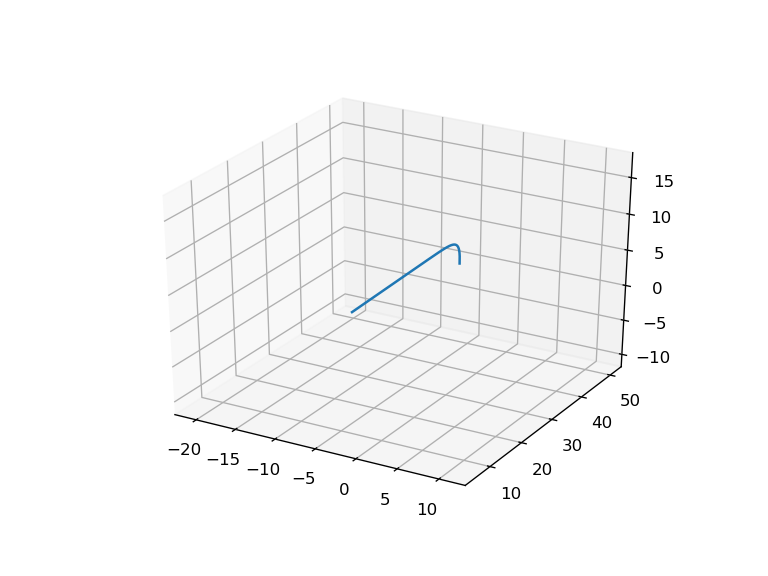

In [46]:
fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')

tmp = np.vstack(his.p_r)
plt.plot(tmp[:,0],tmp[:,1],tmp[:,2])
# tmp = np.vstack(his.p_t)
# plt.plot(tmp[:,0],tmp[:,1],tmp[:,2])
# tmp = np.stack(his.p_os.values)

# for i in range(tmp.shape[1]):
#     plt.plot(tmp[:,i,0],tmp[:,i,1],tmp[:,i,2])



plt.show()

In [117]:
np.stack(his.p_os.values).shape

(1425, 15, 3)

In [34]:
p_os+(v_os*dt)

array([[22.52669285,  3.40795032, 25.36949843],
       [14.66456127, 14.24587795,  2.67494669],
       [23.00322484, 26.90621271, 23.16887183],
       [20.53291828,  7.53633372, 25.14410919],
       [ 4.44725441, 27.20812948, 23.65004268],
       [21.69022514, 12.50550636,  6.81304498],
       [28.67367585, 11.7599054 , 21.24782556],
       [19.44865124,  0.99254781, 16.13233059],
       [ 4.73735221, 27.59398232, 23.53131712],
       [25.09882765, 28.12801194, 17.31042657],
       [ 8.50673757, 28.70590799, 27.27509027],
       [26.23912764, 29.56656763, 22.50128095],
       [ 0.10508433, 24.36813987, 17.4826428 ],
       [14.37301258,  2.77182402, 15.35356694],
       [25.44644694, 20.86357919, 10.84300763]])

In [43]:
np.array([0,-0.000000054,0]).any()

True

## Mark 2 Ashish

In [276]:
def get_vr2xaxis_rot(v_r):
    v_r_new = [np.linalg.norm(v_r),0,0]
    rot_vr = Rotation.from_rotvec(np.arccos(np.dot(unit_vector(v_r_new),unit_vector(v_r)))*unit_vector(np.cross(v_r,v_r_new)))
    return(rot_vr)

def get_R_Pphi(phi):
    return(np.array([[1,0,0],
                    [0,np.cos(phi),np.sin(phi)],
                    [0,-np.sin(phi),np.cos(phi)]]))

In [161]:
def plot_cone(ax,d_vo,alpha_vo,Rot_mat,offset=[0,0,0]):
    # Set up the grid in polar
    beta = np.linspace(0,np.pi,30)
    a = np.linspace(0,d_vo,50)
    B, A = np.meshgrid(beta, a)

    # Then calculate X, Y, and Z
    # Z = R * np.cos(T)
    # Y = R * np.sin(T)h
    # X = np.sqrt(Z**2 + Y**2) - 1
    X = A
    Y = A * np.tan(alpha_vo) * np.cos(B)
    Z = A * np.tan(alpha_vo) * np.sin(B)
#     func = lambda l : np.matmul(get_R_vo_thpsi(th_oi,psi_oi),l)
    func = lambda l : np.matmul(Rot_mat,l)
    
    X,Y,Z = np.apply_along_axis(func,0,np.array([X,Y,Z]))

    thp,php = np.linspace(0,2*np.pi,30),np.linspace(0,2*np.pi,30)
    Thp,Php = np.meshgrid(thp,php)

    ax.plot_wireframe(X+offset[0],
                      Y+offset[1],
                      Z+offset[2])
    
    
def plot_sphere(ax,R,offset,color='yellow'):
    thp,php = np.linspace(0,2*np.pi,30),np.linspace(0,2*np.pi,30)
    Thp,Php = np.meshgrid(thp,php)
    ax.plot_wireframe(offset[0]+R*np.sin(Php)*np.cos(Thp),
                      offset[1]+R*np.sin(Php)*np.sin(Thp),
                      offset[2]+R*np.cos(Php),color=color)

    
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [159]:
while(True):
    p_r = np.array([0,0,0])
    p_t = np.array([np.random.uniform(-4,4),np.random.uniform(-4,4),np.random.uniform(-4,4)])
    v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
    v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
    v_r = 2*unit_vector(p_t-p_r)
    v_t = 0
    
    R = 2
    d_oi = distance(p_r,p_t)
    d_vo = ((d_oi**2)-(R**2))/d_oi
    r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
    alpha_vo = np.arctan(r_vo/d_vo)
    psi_oi,th_oi = get_azimuth_elevation(p_t-p_r)
    
    p_rel = p_t-p_r
    p_rel_xy = np.array([*(p_t-p_r)[:2],0])
    print("as")
    if(np.arccos(np.dot(unit_vector(p_rel),unit_vector(p_rel_xy)))<alpha_vo):
        break

as


In [164]:
R = 2
d_oi = distance(p_r,p_t)
d_vo = ((d_oi**2)-(R**2))/d_oi
r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
alpha_vo = np.arctan(r_vo/d_vo)
psi_oi,th_oi = get_azimuth_elevation(p_t-p_r)




fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_arrow(ax,np.array([0,0,0]),np.array([10,0,0]),color='black')
plot_arrow(ax,np.array([0,0,0]),np.array([0,10,0]),color='black')
plot_arrow(ax,np.array([0,0,0]),np.array([0,0,10]),color='black')
plot_arrow(ax,np.array([0,0,0]),p_t-p_r,color='green')
plot_arrow(ax,np.array([0,0,0]),np.array([*(p_t-p_r)[:2],0]),color='red')
plot_cone(ax,d_vo,alpha_vo,get_R_vo_thpsi(th_oi,psi_oi))
# plot_sphere(ax,R,p_t-p_r)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
ax.set_zlim(-5,5)
#arccos(cos(alpha_vo)/np.dot(unit_vector(p_rel),unit_vector(p_rel_xy))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-5.0, 5.0)

In [181]:
np.mod([2,3,4,5,6],3)

array([2, 0, 1, 2, 0])

In [197]:
#test get_ang_range_cone_xy
#cone base=[(-2,-1,1)],radius=3
#apex=[0,0,0]
#intersection with xy = (-3.65,1.3,0),(-1.15,3.7,0)
#Above values from using https://www.geogebra.org/3d?lang=en
p_r = np.array([0,0,0])
p_t = np.array([-2,-1,1])
alpha = np.arctan(3/np.linalg.norm(p_t-p_r))
print(get_ang_range_cone_xy(p_t-p_r,alpha))
print(np.arccos(np.dot(unit_vector(np.array([-3.65,1.3,0])),
                      unit_vector(np.array([-1.15,-3.7,0]))))/2)
tmpa,tmpb = get_ang_range_cone_xy(p_t-p_r,alpha)
print(unit_vector(np.array([-3.65,1.3,0])),[np.cos(tmpa),np.sin(tmpa)])
print(unit_vector(np.array([-1.15,-3.7,0])),[np.cos(tmpb),np.sin(tmpb)])

0.8054035005744428
[-3.48334855 -1.87254154]
0.8058034940839864
0.8054035005744428
[-0.94203352  0.33551879  0.        ] [-0.9421676453251288, 0.3351419521672906]
[-0.29680508 -0.95493808  0.        ] [-0.2971870254612445, -0.9548192875604774]


### Single Obs

In [269]:
while(True):
    start = 0
    end = 30

    p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
    p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
    v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
    v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])

    n_obs = 60
    p_os,v_os = (np.random.uniform(start,end,(n_obs,3)),
                 np.array([np.random.uniform(0.5,2)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))

    checks = np.array([(cc_y(p_r,p_oi,v_r,v_oi,R)<0 ) for (p_oi,v_oi) in zip(p_os,v_os)])
    print("check",np.nonzero(checks)[0])
    if(len(np.nonzero(checks)[0])>2):
        break

check [ 9 33]
check [51]
check [43]
check [4]
check [49 52]
check []
check [15]
check []
check []
check []
check []
check [45]
check []
check [26]
check []
check [57]
check [37]
check []
check [15]
check []
check [36]
check [55]
check []
check []
check []
check [26 52]
check [32]
check []
check [11]
check []
check [12]
check []
check []
check [20]
check []
check [44]
check [38]
check []
check []
check []
check [21]
check [ 7 49]
check [24]
check []
check [22]
check []
check []
check []
check []
check []
check [11]
check [13]
check []
check [30]
check [13]
check []
check [21]
check [30]
check [38]
check [21 38]
check [0 9]
check []
check [14]
check [3]
check [7]
check [16 21]
check []
check [24]
check []
check [52 54 56]


In [270]:
Rot = get_vr2xaxis_rot(v_r)
p_r_cc = Rot.apply(p_r)
v_r_cc = Rot.apply(v_r)

p_os_cc = np.apply_along_axis(Rot.apply,1,p_os)
v_os_cc = np.apply_along_axis(Rot.apply,1,v_os)
print(v_r_cc)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_arrow(ax,np.array([0,0,0]),v_r,color='green')

plot_arrow(ax,np.array([0,0,0]),v_r_cc,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([10,0,0]),color='blue')
ax.scatter(10,10,10)

[9.78999725e-01 1.38777878e-17 0.00000000e+00]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [293]:
def get_ang_range_cone_xy(p_r,p_o,v_r,v_o,alpha,phi):
    v_rel = v_r-v_o
    Rot = get_vr2xaxis_rot(v_rel)
    
    phi_rot_mat = get_R_Pphi(phi)
    p_r_cc_phi = np.matmul(phi_rot_mat,Rot.apply(p_r))
    v_r_cc_phi = np.matmul(phi_rot_mat,Rot.apply(v_r))
    p_o_cc_phi = np.matmul(phi_rot_mat,Rot.apply(p_o))
    v_o_cc_phi = np.matmul(phi_rot_mat,Rot.apply(v_o))
    
    p_rel_cc_phi = p_o_cc_phi-p_r_cc_phi
    p_rel_cc_phi_xy = [*p_rel_cc_phi[:2],0]
    p_rel_xy_ang = np.arctan2(p_rel_cc_phi_xy[1],p_rel_cc_phi_xy[0])
    half_ang = np.arccos(np.cos(alpha)/np.dot(unit_vector(p_rel_cc_phi),unit_vector(p_rel_cc_phi_xy)))
#     print(half_ang,alpha,np.arccos(np.dot(unit_vector(p_rel),unit_vector(p_rel_xy))))
    angs = p_rel_xy_ang+np.array([-half_ang,half_ang])
    return(p_rel_xy_ang+np.array([-half_ang,half_ang]))
    
    

In [296]:
# checks = np.array([check_VO(p_r_cc,v_r_cc,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os_cc,v_os_cc)])
checks = np.array([(
#     distance(p_oi,p_r)<rho and 
    cc_y(p_r,p_oi,v_r,v_oi,R)<0 ) for (p_oi,v_oi) in zip(p_os,v_os)])
print("check",checks)
print(np.nonzero(checks))

p_ocs = p_os[np.nonzero(checks)[0]]
v_ocs = v_os[np.nonzero(checks)[0]]
print(p_ocs.shape,v_ocs.shape)


d_ois = np.array([distance(p_r,p_o) for p_o in p_ocs])
d_ccs = ((d_ois**2)-(R**2))/d_ois

r_ccs = R*((np.sqrt((d_ois**2)-(R**2)))/d_ois)
alpha_ccs = np.arctan(r_ccs/d_ccs)
psi_ois,th_ois = np.array([get_azimuth_elevation(p_o-p_r) for p_o in p_ocs]).T

print("doi,dcc,rcc",d_ois.shape,d_ccs.shape,r_ccs.shape)
print("alpha,th,psi",alpha_ccs,th_ois,psi_ois)
# print("alpha,th,psi",np.rad2deg([alpha_cc,th_oi,psi_oi]))

# As = v_ocs_cc
# Ds = np.expand_dims(d_ccs,-1)*(np.array([unit_vector(p_o_cc-p_r_cc) for p_o_cc in p_ocs_cc]))

# print(As.shape,Ds.shape)


# # phi = get_single_phi(D,alpha_cc)
# # print(phi)
# # phi = np.deg2rad(25)
phis = np.linspace(0,np.pi,12)
all_phi_res = list()

fig, axs = plt.subplots(2,int(np.ceil(len(phis)/2)), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ax,phi in zip(axs[:],phis[:]):
    print("phi",phi)
    p_r_cc_phi = np.matmul(get_R_Pphi(phi),p_r_cc)
    v_r_cc_phi = np.matmul(get_R_Pphi(phi),v_r_cc)
    matmul_phi_os = lambda m:np.matmul(get_R_Pphi(phi),m)
    p_ocs_cc_phi = np.apply_along_axis(matmul_phi_os,1,p_ocs_cc)
    v_ocs_cc_phi = np.apply_along_axis(matmul_phi_os,1,v_ocs_cc)
    
    print(np.array([(
#     distance(p_oi,p_r)<rho and 
        cc_y(p_r_cc_phi,p_oi,v_r_cc_phi,v_oi,R)<0 ) for (p_oi,v_oi) in zip(p_ocs_cc_phi,v_ocs_cc_phi)]))
    
    p_rel_ocs_cc_phi = p_ocs_cc_phi - p_r_cc_phi
    print(np.array([get_ang_range_cone_xy(p_rel_cc_i,alpha_cc_i) for p_rel_cc_i,alpha_cc_i in zip(p_rel_ocs_cc_phi,alpha_ccs)])
         )
    np.array([get_ang_range_cone_xy(p_r,p_o,alpha_cc_i) for p_o,alpha_cc_i in zip(p_os,alpha_ccs)])

check [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False  True False False False]
(array([52, 54, 56]),)
(3, 3) (3, 3)
doi,dcc,rcc (3,) (3,) (3,)
alpha,th,psi [0.10452952 0.83370564 1.11246693] [ 0.39779545 -0.06449683  0.22956213] [-0.45312194  0.30862518  1.62095093]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

phi 0.0
[ True  True  True]
nan 0.10452951929697894 0.3977954501787977
0.831812652155092 0.833705644901898 0.0644968334401509
1.0991309677926662 1.112466928637313 0.22956213009667117
[[        nan         nan]
 [-0.52318747  1.14043784]
 [ 0.52181996  2.7200819 ]]
phi 0.28559933214452665
[ True  True  True]
nan 0.10452951929697894 0.5068205807797456
0.8236567385816547 0.833705644901898 0.1477767038102155
1.1117006847750246 1.112466928637313 0.055691684316313404
[[        nan         nan]
 [-0.54435388  1.1029596 ]
 [ 0.50800933  2.7314107 ]]
phi 0.5711986642890533
[ True  True  True]
nan 0.10452951929697894 0.5753027555580599
0.8110794267220257 0.833705644901898 0.21986541304321025
1.082103584984214 1.112466928637313 0.34093400678553326
[[        nan         nan]
 [-0.58353724  1.03862161]
 [ 0.54051577  2.70472294]]
phi 0.8567979964335799
[ True  True  True]
nan 0.10452951929697894 0.5928161492645028
0.7977415076949304 0.833705644901898 0.27473106434971317
0.9931930849672769 1.1124669

<ipython-input-293-8d7ea6d71460>:4: RuntimeWarning: invalid value encountered in arccos
  half_ang = np.arccos(np.cos(alpha)/np.dot(unit_vector(p_rel),unit_vector(p_rel_xy)))


In [291]:
matmul_phi_os = lambda m:np.matmul(get_R_Pphi(phi),m)
list(zip(np.apply_along_axis(matmul_phi_os,1,p_os_cc),
     np.array([np.matmul(get_R_Pphi(phi),m) for m in p_os_cc])))

# np.matmul(get_R_Pphi(phi),p_os_cc)


[(array([-14.77500246, -13.39737443, -31.67667275]),
  array([-14.77500246, -13.39737443, -31.67667275])),
 (array([ -3.62628048, -16.21352058,   1.22234669]),
  array([ -3.62628048, -16.21352058,   1.22234669])),
 (array([-12.72712825, -30.76254081, -30.41499605]),
  array([-12.72712825, -30.76254081, -30.41499605])),
 (array([ -8.66220356, -15.52892639,  -7.16230296]),
  array([ -8.66220356, -15.52892639,  -7.16230296])),
 (array([-20.70620016,  -9.432772  , -22.42448458]),
  array([-20.70620016,  -9.432772  , -22.42448458])),
 (array([ -4.60497501,  -7.15750493, -20.29319199]),
  array([ -4.60497501,  -7.15750493, -20.29319199])),
 (array([-21.0080022 , -12.69927213, -12.97912456]),
  array([-21.0080022 , -12.69927213, -12.97912456])),
 (array([-14.54114228,  -3.22349207, -21.46202186]),
  array([-14.54114228,  -3.22349207, -21.46202186])),
 (array([-9.49117537, -7.80773014, -7.06315116]),
  array([-9.49117537, -7.80773014, -7.06315116])),
 (array([-15.30383189, -23.27091952, -13.44

In [113]:
start = 0
end = 30

p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])

R = 3
d_oi = distance(p_r,p_t)
d_vo = ((d_oi**2)-(R**2))/d_oi
r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
alpha_vo = np.arctan(r_vo/d_vo)
psi_oi,th_oi = get_azimuth_elevation(p_t-p_r)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

plot_cone(ax,d_vo,alpha_vo,get_R_vo_thpsi(th_oi,psi_oi))

# Set the Z values outside your range to NaNs so they aren't plotted
# Z[Z < 0] = np.nan
# Z[Z > 2.1] = np.nan
plot_arrow(ax,np.array([0,0,0]),p_t-p_r,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([d_oi,0,0]),color='green')
# plot_arrow(ax,np.array([0,0,0]),np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.array([d_oi,0,0])),color='yellow')
# offset = np.array([1,2,3])
# ax.plot_wireframe(X+offset[0],
#                   Y+offset[1],
#                   Z+offset[2])
# ax.plot_wireframe((p_t-p_r)[0]+R*np.sin(Php)*np.cos(Thp),
#                   (p_t-p_r)[1]+R*np.sin(Php)*np.sin(Thp),
#                   (p_t-p_r)[2]+R*np.cos(Php),color='yellow')
plot_sphere(ax,R,p_t-p_r)
plt.grid()
set_axes_equal(ax)

# ax.set_zlim(-5,2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Velocity Obstacle

In [42]:
from sympy import symbols
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
from multiprocessing import Pool

In [43]:
def a_ppn(p_robot,v_robot,p_target,v_target,N,bounds):
    r = p_target - p_robot
    v_relative = v_target - v_robot
    # omega = np.cross([r[0],r[1],0],[v_relative[0],v_relative[1],0])/np.dot(r,r)
    omega = np.cross(r,v_relative)/np.dot(r,r)
    vr_cap = unit_vector(v_robot)
    # a_ppn = -N*np.cross([v_robot[0],v_robot[1],0],omega)
    a_ppn = -N*np.cross(v_robot,omega)
    # a_ppn = np.array([a_ppn[0],a_ppn[1]])
    if bounds==0:
        return a_ppn
    if bounds==1:
        return min(2,np.linalg.norm(a_ppn))*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)<2:
        a_ppn = 2*unit_vector(a_ppn)
    if np.linalg.norm(a_ppn)>3:
        a_ppn = 3*unit_vector(a_ppn)
    return a_ppn

In [44]:
def unit_vector(vector):
    if np.linalg.norm(vector) == 0:
        return 0
    return vector/np.linalg.norm(vector)

def distance(a,b):
    return(np.linalg.norm(a-b))
#     return math.sqrt(np.dot(a-b,a-b))

def angle_between(v1, v2):
    return np.math.atan2(np.linalg.det([v1,v2]),np.dot(v1,v2))

def perpendicular_to(v):
    v_homogenous = np.array([v[0],v[1],1])
    direction = np.cross(np.array([0,0,1]),v_homogenous)
    return np.array([direction[0],direction[1]])

def time_to_col(p1,p2,v1,v2,rad):#CHECK DOT PRODUCT SHUD BE v1-v2.p2-p1
    toc = abs((distance(p1,p2) - 2*rad)/np.dot(v1-v2,unit_vector(p1-p2)))
    return toc

def time_of_closest_approach(p_r,p_t,v_r,v_t):
    p_rel = p_t-p_r
    v_rel = v_r-v_t #The velocity is taken as v_t-v_r in Collision cone paper. We compenasate by removing the minus sign while calculating time
    v_radial = np.dot(v_rel,unit_vector(p_rel))
    toc = (np.linalg.norm(p_rel)*v_radial)/(np.dot(v_rel,v_rel))
    return(toc)

def plot_arrow(ax,p,v,marker="o",color='blue',qcolor='blue'):
    ax.scatter3D(p[...,0],p[...,1],p[...,2],s=10,marker=marker,color=color)
    ax.quiver(p[...,0],p[...,1],p[...,2],v[...,0],v[...,1],v[...,2],color=color)

def get_azimuth_elevation(v):
    return(np.arctan2(v[1],v[0]),np.arctan2(v[2],np.linalg.norm([v[0],v[1]])))#azimuth, elevation

def get_uvec_from_azimuth_elevation(a,e):
    return(np.array([np.cos(e)*np.cos(a),np.cos(e)*np.sin(a),np.sin(e)]))

def time_of_closest_approach(p_r,p_t,v_r,v_t):
    p_rel = p_t-p_r
    v_rel = v_r-v_t #The velocity is taken as v_t-v_r in Collision cone paper. We compenasate by removing the minus sign while calculating time
    v_radial = np.dot(v_rel,unit_vector(p_rel))
    toc = (np.linalg.norm(p_rel)*v_radial)/(np.dot(v_rel,v_rel))
    return(toc)

In [45]:
def check_VO(p_r,v_r,p_t,v_t,alpha_vo=None,rho=None,R=3):
    if(alpha_vo is None):
#         R = 3
        d_oi = distance(p_r,p_t)
        d_vo = ((d_oi**2)-(R**2))/d_oi
        r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
        alpha_vo = np.arctan(r_vo/d_vo)
    v_rel = v_r-v_t
    p_rel = p_t-p_r
    p_rel_mod = np.linalg.norm(p_rel)
    cond = True
    if(rho is not None):
        cond = p_rel_mod<rho
    return(((np.dot(v_rel,p_rel)/(np.linalg.norm(v_rel)*p_rel_mod))>np.cos(alpha_vo)) and cond)
    
# def get_R_vo_thpsi(th,psi):
#     m1 = np.array(
#         [[np.cos(psi),np.sin(psi),0],
#           [-np.sin(psi),np.cos(psi),0],
#           [0,0,1]])
#     m2 = np.array(
#         [[np.cos(th),0,-np.sin(th)],
#           [0,1,0],
#           [np.sin(th),0,np.cos(th)]])
# #     print(m1,m2)
#     return(np.matmul(m1,m2))

def get_R_vo_thpsi(th,psi):
    m1 = np.array(
        [[np.cos(psi),-np.sin(psi),0],
          [np.sin(psi),np.cos(psi),0],
          [0,0,1]])
    m2 = np.array(
        [[np.cos(th),0,-np.sin(th)],
          [0,1,0],
          [np.sin(th),0,np.cos(th)]])
#     print(m1,m2)
    return(np.matmul(m1,m2))

def get_R_Pphi(phi):
    return(np.array([[1,0,0],
                    [0,np.cos(phi),np.sin(phi)],
                    [0,-np.sin(phi),np.cos(phi)]]))


In [46]:
#FUNC
def get_vr2xaxis_rot(v_r):
    v_r_new = [np.linalg.norm(v_r),0,0]
    rot_vr = Rotation.from_rotvec(np.arccos(np.dot(unit_vector(v_r_new),unit_vector(v_r)))*unit_vector(np.cross(v_r,v_r_new)))
    return(rot_vr)

In [47]:
def plot_cone(ax,d_vo,alpha_vo,Rot_mat,offset=[0,0,0]):
    # Set up the grid in polar
    beta = np.linspace(0,2*np.pi,30)
    a = np.linspace(0,d_vo,50)
    B, A = np.meshgrid(beta, a)

    # Then calculate X, Y, and Z
    # Z = R * np.cos(T)
    # Y = R * np.sin(T)h
    # X = np.sqrt(Z**2 + Y**2) - 1
    X = A
    Y = A * np.tan(alpha_vo) * np.cos(B)
    Z = A * np.tan(alpha_vo) * np.sin(B)
#     func = lambda l : np.matmul(get_R_vo_thpsi(th_oi,psi_oi),l)
    func = lambda l : np.matmul(Rot_mat,l)
    
    X,Y,Z = np.apply_along_axis(func,0,np.array([X,Y,Z]))

    thp,php = np.linspace(0,2*np.pi,30),np.linspace(0,2*np.pi,30)
    Thp,Php = np.meshgrid(thp,php)

    ax.plot_wireframe(X+offset[0],
                      Y+offset[1],
                      Z+offset[2])
    
    
def plot_sphere(ax,R,offset,color='yellow'):
    thp,php = np.linspace(0,2*np.pi,30),np.linspace(0,2*np.pi,30)
    Thp,Php = np.meshgrid(thp,php)
    ax.plot_wireframe(offset[0]+R*np.sin(Php)*np.cos(Thp),
                      offset[1]+R*np.sin(Php)*np.sin(Thp),
                      offset[2]+R*np.cos(Php),color=color)

    
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [48]:
start = 0
end = 30

p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])



In [49]:
# b = symbols('b')
b = np.linspace(0,2*np.pi,30)


In [50]:
R = 3
d_oi = distance(p_r,p_t)
d_vo = ((d_oi**2)-(R**2))/d_oi
r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
alpha_vo = np.arctan(r_vo/d_vo)
psi_oi,th_oi = get_azimuth_elevation(p_t-p_r)

phi = np.deg2rad(45)
print(d_oi,d_vo,r_vo)
print(alpha_vo,th_oi,psi_oi,phi)
print(np.rad2deg([alpha_vo,th_oi,psi_oi,phi]))



42.01046399908143 41.79623165924827 2.992340973981676
0.07147161285187363 0.27307740818738907 1.9483167594231066 0.7853981633974483
[  4.09502177  15.64618297 111.63032747  45.        ]


In [51]:
A = v_t
D = d_vo*(unit_vector(p_t-p_r))

print(A,D)

[1.09854416 1.20154645 0.74204313] [-14.83589579  37.41332489  11.27228006]


In [52]:
check_VO(p_r,v_r,p_t,v_t,alpha_vo)

False

In [53]:
del_p_phi = np.arccos(np.dot(unit_vector(D),[0,np.sin(phi),np.cos(phi)]))
np.rad2deg(del_p_phi)

34.54703988171994

In [54]:
# Test
#Testing calculated azimuth and elevation angles
print(p_t-p_r)
print(np.array([np.cos(th_oi)*np.cos(psi_oi),
        np.cos(th_oi)*np.sin(psi_oi),
        np.sin(th_oi)
       ])*d_oi)

#Testing get_r_vo_thpsi

print(np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.array([d_oi,0,0])),th_oi,psi_oi)
print(p_t-p_r)
          


[-14.91193922  37.60509203  11.33005769]
[-14.91193922  37.60509203  11.33005769]
[-14.91193922  37.60509203  11.33005769] 0.27307740818738907 1.9483167594231066
[-14.91193922  37.60509203  11.33005769]


In [55]:
#get rotation to change orinentation to v_r
from scipy.spatial.transform import Rotation
# v_r_new = [np.linalg.norm(v_r),0,0]
# rot_vr = Rotation.from_rotvec(np.arccos(np.dot(unit_vector(v_r_new),unit_vector(v_r)))*unit_vector(np.cross(v_r,v_r_new)))
rot_vr = get_vr2xaxis_rot(v_r)
print(rot_vr.apply(v_r))
v_r
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

plot_arrow(ax,np.array([0,0,0]),v_r)
plot_arrow(ax,np.array([0,0,0]),rot_vr.apply(v_r),color='green')
# plot_arrow(ax,np.array([0,0,0]),6*rot_vr.inv().apply(rot_vr.apply(v_r)),color='red')

ax.quiver(0,0,0,10,0,0)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
# ax.grid(True,which='both')
plt.show()

[1.88078766e+00 1.38777878e-17 0.00000000e+00]


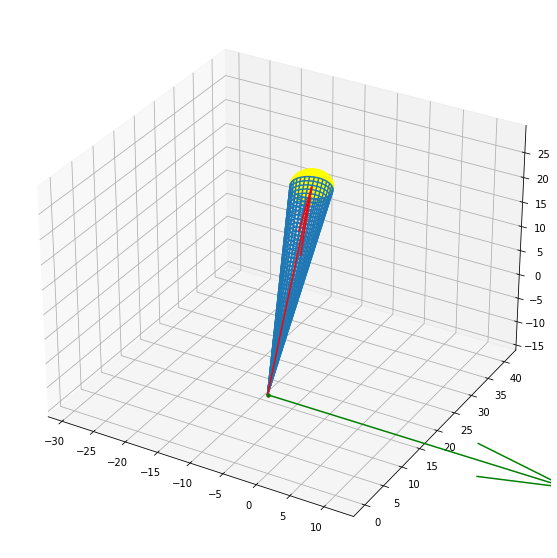

In [56]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

# # Set up the grid in polar
# beta = np.linspace(0,2*np.pi,30)
# a = np.linspace(0,d_vo,50)
# B, A = np.meshgrid(beta, a)

# # Then calculate X, Y, and Z
# # Z = R * np.cos(T)
# # Y = R * np.sin(T)h
# # X = np.sqrt(Z**2 + Y**2) - 1
# X = A
# Y = A * np.tan(alpha_vo) * np.cos(B)
# Z = A * np.tan(alpha_vo) * np.sin(B)
# func = lambda l : np.matmul(get_R_vo_thpsi(th_oi,psi_oi),l)
# X,Y,Z = np.apply_along_axis(func,0,np.array([X,Y,Z]))

# thp,php = np.linspace(0,2*np.pi,30),np.linspace(0,2*np.pi,30)
# Thp,Php = np.meshgrid(thp,php)
plot_cone(ax,d_vo,alpha_vo,get_R_vo_thpsi(th_oi,psi_oi))

# Set the Z values outside your range to NaNs so they aren't plotted
# Z[Z < 0] = np.nan
# Z[Z > 2.1] = np.nan
plot_arrow(ax,np.array([0,0,0]),p_t-p_r,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([d_oi,0,0]),color='green')
# plot_arrow(ax,np.array([0,0,0]),np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.array([d_oi,0,0])),color='yellow')
# offset = np.array([1,2,3])
# ax.plot_wireframe(X+offset[0],
#                   Y+offset[1],
#                   Z+offset[2])
# ax.plot_wireframe((p_t-p_r)[0]+R*np.sin(Php)*np.cos(Thp),
#                   (p_t-p_r)[1]+R*np.sin(Php)*np.sin(Thp),
#                   (p_t-p_r)[2]+R*np.cos(Php),color='yellow')
plot_sphere(ax,R,p_t-p_r)
plt.grid()
set_axes_equal(ax)

# ax.set_zlim(-5,2)


In [57]:
num = (A[2]*np.cos(phi))-(A[1]*np.sin(phi))
den = ((np.sin(phi)*np.cos(th_oi)+np.cos(phi))*np.sin(psi_oi)+
((np.cos(phi)*np.cos(th_oi)-np.sin(phi)*np.sin(psi_oi)*np.sin(th_oi))*np.sin(b)-
 np.sin(phi)*np.cos(psi_oi)*np.cos(b))*np.tan(alpha_vo))
a = num/den

In [58]:
num = (A[2]*np.cos(phi) - A[1]*np.sin(phi))
den = ((np.cos(phi) + np.cos(th_oi)*np.sin(phi))*np.sin(psi_oi)+
       (-(np.cos(b)*np.cos(psi_oi)*np.sin(phi)) + 
        np.sin(b)*(np.cos(th_oi)*np.cos(phi) - np.sin(th_oi)*np.sin(phi)*np.sin(psi_oi))
       )*np.tan(alpha_vo))
a = num/den
a

array([-0.24823145, -0.24685194, -0.24571316, -0.2448613 , -0.24433   ,
       -0.24413988, -0.24429824, -0.244799  , -0.24562277, -0.24673705,
       -0.24809678, -0.2496452 , -0.25131527, -0.25303178, -0.25471428,
       -0.25628071, -0.25765189, -0.25875618, -0.25953435, -0.25994383,
       -0.25996191, -0.25958759, -0.25884164, -0.25776493, -0.25641533,
       -0.25486353, -0.25318825, -0.25147146, -0.24979391, -0.24823145])

In [59]:
num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
       np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
               (np.cos(b)*np.cos(psi_oi) - 
                np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
               )*np.tan(alpha_vo)))
a = num/den
a


array([-0.7670538 , -0.79089987, -0.81327325, -0.83266346, -0.84758655,
       -0.85678562, -0.85943473, -0.85528868, -0.84472976, -0.82869533,
       -0.80851102, -0.78568286, -0.76170412, -0.73791447, -0.71542334,
       -0.69508971, -0.67754033, -0.66320806, -0.65237595, -0.64521778,
       -0.64183008, -0.6422536 , -0.6464834 , -0.65446766, -0.66609492,
       -0.68117027, -0.69938113, -0.72025539, -0.74311763, -0.7670538 ])

In [60]:
M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
M_vo = (M_cc+np.expand_dims(A,-1))
M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
M_vo_phi = np.squeeze(M_vo_phi)


print(M_vo_phi.shape)
M_vo_phi

(30, 3)


array([[ 1.42186484e+00,  7.56847110e-01, -5.55111512e-17],
       [ 1.42947548e+00,  7.31175604e-01, -5.55111512e-17],
       [ 1.43391381e+00,  7.05924972e-01,  5.55111512e-17],
       [ 1.43463383e+00,  6.82693770e-01, -5.55111512e-17],
       [ 1.43132187e+00,  6.63148476e-01, -1.11022302e-16],
       [ 1.42398812e+00,  6.48819472e-01, -1.11022302e-16],
       [ 1.41301501e+00,  6.40874332e-01,  5.55111512e-17],
       [ 1.39913861e+00,  6.39927965e-01,  0.00000000e+00],
       [ 1.38335927e+00,  6.45947330e-01,  0.00000000e+00],
       [ 1.36680307e+00,  6.58279688e-01, -5.55111512e-17],
       [ 1.35057205e+00,  6.75790522e-01, -5.55111512e-17],
       [ 1.33562128e+00,  6.97062952e-01,  0.00000000e+00],
       [ 1.32268528e+00,  7.20600548e-01,  5.55111512e-17],
       [ 1.31225663e+00,  7.44989141e-01,  0.00000000e+00],
       [ 1.30460488e+00,  7.68997908e-01, -1.11022302e-16],
       [ 1.29981805e+00,  7.91621905e-01, -1.11022302e-16],
       [ 1.29785083e+00,  8.12080691e-01

In [61]:
(M_vo_phi[:,0]**2+M_vo_phi[:,0]**2)-(np.linalg.norm(v_r)**2)

array([ 0.50603702,  0.5494381 ,  0.57485543,  0.57898626,  0.5600024 ,
        0.51812212,  0.45586062,  0.37781546,  0.29000354,  0.19893905,
        0.11072751,  0.0304062 , -0.03836952, -0.09332727, -0.13337441,
       -0.15830828, -0.16852865, -0.16480068, -0.14808588, -0.11943943,
       -0.07996437, -0.03081215,  0.02677974,  0.09142003,  0.1614726 ,
        0.23495038,  0.30940843,  0.38185961,  0.44874921,  0.50603702])

In [62]:
for m in M_cc_st:
    print((np.matmul(get_R_vo_thpsi(th_oi,psi_oi),m)))

[ 0.32332068 -0.66637472 -0.20687141]
[ 0.33093133 -0.68452722 -0.2250239 ]
[ 0.33536966 -0.70238211 -0.2428788 ]
[ 0.33608968 -0.71880905 -0.25930574]
[ 0.33277772 -0.73262966 -0.27312635]
[ 0.32544397 -0.7427618  -0.28325848]
[ 0.31447085 -0.74837986 -0.28887654]
[ 0.30059445 -0.74904904 -0.28954573]
[ 0.28481512 -0.74479271 -0.28528939]
[ 0.26825892 -0.73607241 -0.2765691 ]
[ 0.25202789 -0.72369038 -0.26418707]
[ 0.23707713 -0.7086485  -0.24914519]
[ 0.22414112 -0.69200491 -0.2325016 ]
[ 0.21371248 -0.67475957 -0.21525626]
[ 0.20606073 -0.65778281 -0.1982795 ]
[ 0.2012739  -0.64178523 -0.18228191]
[ 0.19930668 -0.62731868 -0.16781537]
[ 0.20002458 -0.61479576 -0.15529245]
[ 0.20323853 -0.6045171  -0.14501378]
[ 0.20872835 -0.59669896 -0.13719564]
[ 0.2162558  -0.59149682 -0.1319935 ]
[ 0.22556877 -0.58902247 -0.12951916]
[ 0.23639816 -0.58935371 -0.12985039]
[ 0.24844921 -0.59253583 -0.13303251]
[ 0.26138871 -0.59857471 -0.13907139]
[ 0.2748299  -0.60742087 -0.14791756]
[ 0.28831753

In [63]:
r1 = Rotation.from_euler('z', -90, degrees=True)
r2 = Rotation.from_euler('y', -90, degrees=True)
# r2 = Rotation.from_rotvec([ 0,np.arctan2(p[2],np.linalg.norm([p[0],p[1]])),0])
# return(r2.apply(r1.inv().apply(v)))

In [64]:
def get_single_phi(D,alpha_vo):
    phis = np.linspace(0,np.pi,100)
    avl_phis = []

    for phi in phis:
        del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))

        if(del_p_phi<((np.pi/2)-alpha_vo)):
            del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
            print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))
            avl_phis.append(phi)
    return(np.array(avl_phis)[len(avl_phis)//2])

### Single Obstacle

In [65]:
def get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000):
    b = np.linspace(0,2*np.pi,num_linspace_b)

    num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
    den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
           np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
                   (np.cos(b)*np.cos(psi_oi) - 
                    np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
                   )*np.tan(alpha_vo)))
    a = num/den

    M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
    M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
    M_vo = (M_cc+np.expand_dims(A,-1))
    M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
    M_vo_phi = np.squeeze(M_vo_phi)
    return(M_vo_phi)

In [66]:
p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_r = np.array([0,0,0])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
p_t = np.array([end,end,end])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array(unit_vector(p_r-p_t))
v_r = 2*unit_vector(v_r)
v_t = 1*unit_vector(v_t)
n_obs = 30
p_os,v_os = (np.random.uniform(start,end,(n_obs,3)),
             np.array([np.random.uniform(0.5,2)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))
v_r = 2*unit_vector(p_os[0]-p_r)-v_os[0]

R = 10

his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os","a_cc","a_ppn","accel"])


fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
plot_arrow(ax,p_r,v_r,"o","blue")
plot_arrow(ax,p_t,v_t,"o","green")
plot_arrow(ax,p_os,v_os,"D","red")

plt.show()
# time.sleep(3)
checks = np.array([check_VO(p_r,v_r,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os,v_os)])
print("check",checks)
print(np.nonzero(checks))


check [False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
(array([19]),)


In [67]:
Rot = get_vr2xaxis_rot(v_r)
p_r_vo = Rot.apply(p_r)
v_r_vo = Rot.apply(v_r)

p_os_vo = np.apply_along_axis(Rot.apply,1,p_os)
v_os_vo = np.apply_along_axis(Rot.apply,1,v_os)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_arrow(ax,np.array([0,0,0]),v_r,color='green')

plot_arrow(ax,np.array([0,0,0]),v_r_vo,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([10,0,0]),color='blue')
ax.scatter(10,10,10)


In [68]:
def check_targ_vel_phi(x,phi,p_o_vo,p_r_vo,v_o_vo,alpha_vo):
    v_rel = np.matmul(get_R_Pphi(phi).T,np.array([np.cos(x),np.sin(x),0]))-v_o_vo
    p_rel = p_o_vo-p_r_vo
    return(np.dot(unit_vector(v_rel),unit_vector(p_rel))>np.cos(alpha_vo))


In [69]:
from scipy import interpolate
import time 

ta0 = time.time()
checks = np.array([check_VO(p_r_vo,v_r_vo,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os_vo,v_os_vo)])
print("check",checks)
print(np.nonzero(checks))

p_o_vo = p_os_vo[np.nonzero(checks)[0][0]]
v_o_vo = v_os_vo[np.nonzero(checks)[0][0]]

b = np.linspace(0,2*np.pi,10000)

R = 10
d_oi = distance(p_r_vo,p_o_vo)
d_vo = ((d_oi**2)-(R**2))/d_oi
r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
alpha_vo = np.arctan(r_vo/d_vo)
psi_oi,th_oi = get_azimuth_elevation(p_o_vo-p_r_vo)

print(d_oi,d_vo,r_vo)
print(alpha_vo,th_oi,psi_oi,phi)
print(np.rad2deg([alpha_vo,th_oi,psi_oi,phi]))

A = v_o_vo
D = d_vo*(unit_vector(p_o_vo-p_r_vo))

print(A,D)

# phi = get_single_phi(D,alpha_vo)
# print(phi)
phi = np.deg2rad(25)
phis = np.linspace(0,np.pi,12)

fig, axs = plt.subplots(2,int(np.ceil(len(phis)/2)), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ax,phi in zip(axs[:-5],phis[:-5]):
    tb0 = time.time()
    del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
    print(np.rad2deg(del_p_phi))
    print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))

#     num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
#     den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
#            np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
#                    (np.cos(b)*np.cos(psi_oi) - 
#                     np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
#                    )*np.tan(alpha_vo)))
#     a = num/den

#     M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
#     M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
#     M_vo = (M_cc+np.expand_dims(A,-1))
#     M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
#     M_vo_phi = np.squeeze(M_vo_phi)
    M_vo_phi = get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000)

    # print(M_vo_phi)
#     fig = plt.figure()
#     ax=fig.add_subplot(111)
#     print("adjnjs",(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2),np.linalg.norm(v_r)**2)
    # plt.plot(np.arange(50),(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))

    plt.axis("equal")
    ax.plot(M_vo_phi[:,0],M_vo_phi[:,1])
#     ax.scatter(M_vo_phi[:,0],M_vo_phi[:,1])
    
    ax.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
             np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))
    ax.set_xlim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
    ax.set_ylim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
    ax.set_aspect(1)
    
    arr = ((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))
    arr = np.clip(arr,-10,10)
    spl = interpolate.UnivariateSpline(np.arange(0,len(arr)),arr,s=0)
    roots = spl.roots()
    dec,nat = np.modf(roots)
    nat = nat.astype(int);dec = np.expand_dims(dec,-1)
    print("natdec",nat,dec)
    pts = ((1-dec)*M_vo_phi[nat])+(dec*M_vo_phi[nat+1])
    tb1 = time.time()
#     pts = M_vo_phi[np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))<0.5][:,:2]
#     pts = M_vo_phi[np.argsort(np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2)))[:4]]

    ax.arrow(0,0,np.linalg.norm(v_r_vo),0)
    ax.scatter(pts[:,0],pts[:,1])
    eps_avo = np.mod(np.arctan2(pts[:,1],pts[:,0]),2*np.pi)
    eps_avo = np.array([np.min(eps_avo),np.max(eps_avo)])

#     for i in np.argsort(np.mod(eps_avo,2*np.pi)):
#         if(i%2==0):
#             while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
#                 eps_avo[i]+=np.deg2rad(0.1)
#         else:
#             while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
#                 eps_avo[i]-=np.deg2rad(0.1)
    print("eps",np.rad2deg(eps_avo))
    print("check_eps",[check_targ_vel_phi(x, phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo) for x in eps_avo])
    
    v_avos = np.linalg.norm(v_r_vo)*np.array([np.cos(eps_avo),np.sin(eps_avo)]).T
    print("v_avos",v_avos,np.linalg.norm(v_avos,axis=-1))
    print("cehck_v",[check_VO(p_r_vo,
         np.matmul(get_R_Pphi(phi).T,np.append(v_avoi,0)),
         p_o_vo,v_o_vo,alpha_vo,R=R) for v_avoi in v_avos])

    print(tb1-tb0)
    print("\n\n")
    for v_avo in v_avos:
        ax.arrow(0,0,v_avo[0],v_avo[1])
    ax.set_title(f"{np.rad2deg(phi):.2f},{del_p_phi-((np.pi/2)-alpha_vo):.2f},{np.matmul(get_R_Pphi(phi),A)[2]:.2f}")
    
ta1 = time.time();print("Tot time",ta1-ta0)

check [False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
(array([19]),)
15.806366805249246 9.479802248567548 7.7443257234015475
0.6849786217762783 0.9962372277850435 0.8688254889543384 0.7853981633974483
[39.24638408 57.08018855 49.78003365 45.        ]
[ 0.61186199 -0.52726804 -0.85291817] [3.32672921 3.93387091 7.95764934]
32.91981145410379
Elliptical Check True
natdec [363 918] [[0.616905  ]
 [0.93750727]]
eps [ 57.86958208 320.33052594]
check_eps [True, True]
v_avos [[ 0.63675352  1.01387598]
 [ 0.92156836 -0.76427174]] [1.19724665 1.19724665]
cehck_v [True, True]
0.005486249923706055



46.48713477499335
Elliptical Check True
natdec [393 966] [[0.03103682]
 [0.62672657]]
eps [ 73.27614119 321.57221631]
check_eps [False, True]
v_avos [[ 0.34451891  1.14660641]
 [ 0.93791364 -0.744122  ]] [1.19724665 1.19724665]
cehck_v [True, True]
0.00562810897827148

TypeError: plot_cone() missing 1 required positional argument: 'Rot_mat'

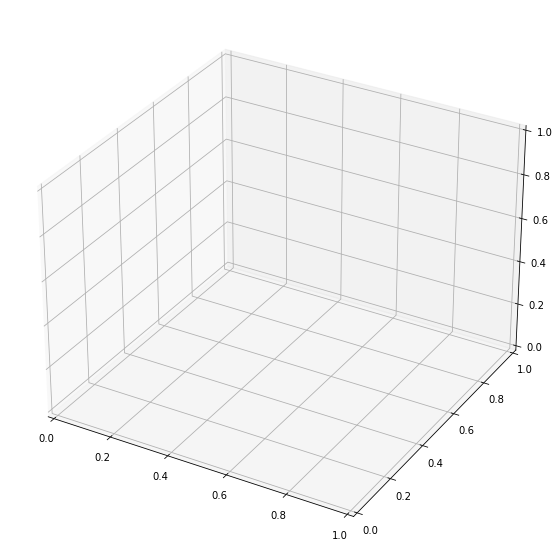

In [70]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_cone(ax,d_vo,alpha_vo
#           ,offset=v_o_vo
         )
# plot_arrow(ax,np.array([0,0,0]),p_o_vo-p_r_vo,color='red')

plot_arrow(ax,np.array([0,0,0]),np.array([d_oi,0,0]),color='green')
plot_arrow(ax,np.array([0,0,0]),v_r_vo,color='black')
tmp = np.squeeze(
    np.matmul(get_R_Pphi(phi).T,np.expand_dims(np.pad(v_avos, ((0,0), (0, 1)), 'constant'),-1)))-v_o_vo
ax.scatter(tmp[:,0],tmp[:,1],tmp[:,2],color='orange',s=100)
plot_arrow(ax,np.array([0,0,0]),tmp,color='orange')

# ax.plot(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,0],
#        np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,1],
#        np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,2],color="black",linewidth=3)
# plot_sphere(ax,R,p_o_vo-p_r_vo)
ax.set_xlim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[0],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[0])

ax.set_ylim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[1],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[1])
ax.set_zlim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[2],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[2])
ax.set_xlim(0,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

set_axes_equal(ax)
check_VO(p_r_vo,v_r_vo,p_o_vo,v_o_vo,R=R)

In [71]:
# from scipy.optimize import Bounds
# from scipy.optimize import minimize
# # bounds = Bounds([0,np.
# check_VO(p_r_vo,
#          np.matmul(get_R_Pphi(phi).T,np.append(v_avos[2],0)),
# #          np.matmul(get_R_Pphi(phi).T,np.array([2,0,0])),
#          p_o_vo,v_o_vo,alpha_vo,R=R)
# def fun(x):
#     v_rel = np.matmul(get_R_Pphi(phi).T,np.array([np.cos(x),np.sin(x),0]))-v_o_vo
#     p_rel = p_o_vo-p_r_vo
#     return(np.dot(unit_vector(v_rel),unit_vector(p_rel))-np.cos(alpha_vo))
# ineq_cons = {'type': 'ineq',
#              'fun' : lambda x:fun(x)    
#             }
# x = minimize((lambda x: -x), np.array(eps_avo[2]), method='SLSQP',constraints=[ineq_cons],
#          options={'ftol': 1e-5, 'disp': True},bounds= [(-np.pi/2,np.pi/2)]).x
# check_VO(p_r_vo,
#          np.matmul(get_R_Pphi(phi).T,np.linalg.norm(v_r_vo)*np.array([np.cos(x[0]+0.01),np.sin(x[0]+0.01),0])),
# #          np.matmul(get_R_Pphi(phi).T,np.array([2,0,0])),
#          p_o_vo,v_o_vo,alpha_vo,R=R)

[168.76163041 775.36809012] [[0.76163041]
 [0.36809012]] [[0.23836959]
 [0.63190988]]
[[ 4.97934435e-02  1.17745569e+00 -1.11022302e-16]
 [ 1.02760411e+00 -6.16489487e-01 -2.35922393e-16]]


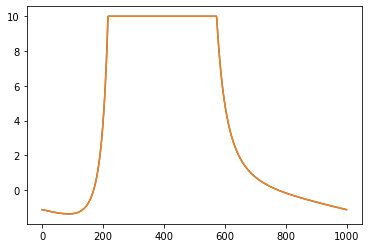

In [72]:
pts = M_vo_phi[np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))<0.5][:,:2]
pts = M_vo_phi[np.argsort(np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2)))[:8]]
plt.figure()
arr = ((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))
arr = np.clip(arr,-10,10)
# fil = np.abs(arr)<2
# arr = arr[fil]
plt.plot(np.arange(0,len(arr)),arr)
# plt.plot(arr)
# interp_arr = np.interp(np.arange(0,len(arr),0.1),np.arange(0,len(arr)),arr)
# plt.plot(np.arange(0,len(arr),0.1),interp_arr)
# plt.show()
# plt.plot(np.rad2deg(np.arctan2(M_vo_phi[:,1],M_vo_phi[:,0])))
from scipy import interpolate
spl = interpolate.UnivariateSpline(np.arange(0,len(arr)),arr,s=0)
plt.plot(np.arange(0,len(arr)),spl(np.arange(0,len(arr))))
roots = spl.roots()
print(roots,dec,1-dec)
dec,nat = np.modf(roots)
nat = nat.astype(int);dec = np.expand_dims(dec,-1)
print(((1-dec)*M_vo_phi[nat])+((dec)*M_vo_phi[nat]))
# np.nonzero(fil)[0][roots.astype(int)]
# plt.ylim(-10,10)
# *[roots.astype(int)]
# np.nonzero(fil)[int(roots)]


### Multiple Obstacles

In [73]:
def get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000):
    b = np.linspace(0,2*np.pi,num_linspace_b)

    num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
    den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
           np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
                   (np.cos(b)*np.cos(psi_oi) - 
                    np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
                   )*np.tan(alpha_vo)))
    a = num/den

    M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
    M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
    M_vo = (M_cc+np.expand_dims(A,-1))
    M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
    M_vo_phi = np.squeeze(M_vo_phi)
    return(M_vo_phi)

def get_intersection(M_vo_phi,v_r,check_vo=True):
    opp_eps = None
    arr = ((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))
    arr = np.clip(arr,-10,10)
    spl = interpolate.UnivariateSpline(np.arange(0,len(arr)),arr,s=0)
    roots = spl.roots()
    dec,nat = np.modf(roots)
    nat = nat.astype(int);dec = np.expand_dims(dec,-1)
#     print("natdec",nat,dec)
    pts = ((1-dec)*M_vo_phi[nat])+(dec*M_vo_phi[nat+1])
    
    eps_avo = np.mod(np.arctan2(pts[:,1],pts[:,0]),2*np.pi)
    if(not(len(eps_avo)==2 or len(eps_avo)==4)):
        print("EPSILON ERROR",eps_avo)
        raise
    eps_avo = np.sort(eps_avo)
    if(len(eps_avo)==4):
        opp_eps = np.array([eps_avo[1],eps_avo[2]])
    eps_avo = np.array([eps_avo[0],eps_avo[-1]])
    
    if(check_vo):
        for i in np.argsort(np.mod(eps_avo,2*np.pi)):
            if(i%2==0):
                while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
                    eps_avo[i]+=np.deg2rad(0.1)
            else:
                while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
                    eps_avo[i]-=np.deg2rad(0.1)
    return(pts,eps_avo,opp_eps)

def check_targ_vel_phi(x,phi,p_o_vo,p_r_vo,v_o_vo,alpha_vo):
    v_rel = np.matmul(get_R_Pphi(phi).T,np.array([np.cos(x),np.sin(x),0]))-v_o_vo
    p_rel = p_o_vo-p_r_vo
    return(np.dot(unit_vector(v_rel),unit_vector(p_rel))>np.cos(alpha_vo))


In [74]:
p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_r = np.array([0,0,0])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
p_t = np.array([end,end,end])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array(unit_vector(p_r-p_t))
v_r = 2*unit_vector(v_r)
v_r = 2*unit_vector(p_os[0]-p_r)-v_os[0]
v_t = 1*unit_vector(v_t)
n_obs = 40
p_os,v_os = (np.random.uniform(start,end,(n_obs,3)),
             np.array([np.random.uniform(0.5,2)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))

R = 10

his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os","a_cc","a_ppn","accel"])


fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
plot_arrow(ax,p_r,v_r,"o","blue")
plot_arrow(ax,p_t,v_t,"o","green")
plot_arrow(ax,p_os,v_os,"D","red")

plt.show()
# time.sleep(3)
checks = np.array([check_VO(p_r,v_r,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os,v_os)])
print("check",checks)
print(np.nonzero(checks))

check [False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False False False False False False False False False False False
 False False False False]
(array([15, 20]),)


[ 1.19724665e+00  1.66533454e-16 -2.77555756e-17] [ 0.46300423  1.02246277 -0.41664914] [ 0.46300423  1.02246277 -0.41664914]


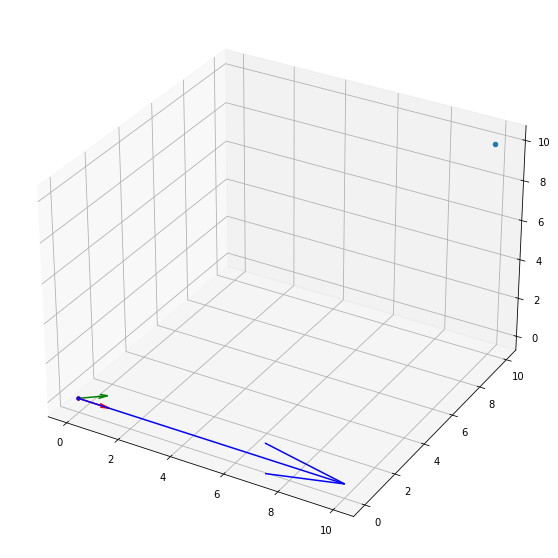

In [75]:
Rot = get_vr2xaxis_rot(v_r)
p_r_vo = Rot.apply(p_r)
v_r_vo = Rot.apply(v_r)
print(v_r_vo,Rot.inv().apply(v_r_vo),v_r)

p_os_vo = np.apply_along_axis(Rot.apply,1,p_os)
v_os_vo = np.apply_along_axis(Rot.apply,1,v_os)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_arrow(ax,np.array([0,0,0]),v_r,color='green')

plot_arrow(ax,np.array([0,0,0]),v_r_vo,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([10,0,0]),color='blue')
ax.scatter(10,10,10)


In [76]:
from scipy import interpolate
import time 

ta0 = time.time()

Rot = get_vr2xaxis_rot(v_r)
p_r_vo = Rot.apply(p_r)
v_r_vo = Rot.apply(v_r)
print(v_r_vo,Rot.inv().apply(v_r_vo),v_r)

p_os_vo = np.apply_along_axis(Rot.apply,1,p_os)
v_os_vo = np.apply_along_axis(Rot.apply,1,v_os)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111,projection='3d')
# plot_arrow(ax,np.array([0,0,0]),v_r,color='green')

# plot_arrow(ax,np.array([0,0,0]),v_r_vo,color='red')
# plot_arrow(ax,np.array([0,0,0]),np.array([10,0,0]),color='blue')
# ax.scatter(10,10,10)



checks = np.array([check_VO(p_r_vo,v_r_vo,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os_vo,v_os_vo)])
print("check",checks)
print(np.nonzero(checks))

p_ocs_vo = p_os_vo[np.nonzero(checks)[0]]
v_ocs_vo = v_os_vo[np.nonzero(checks)[0]]
print(p_ocs_vo.shape,v_ocs_vo.shape)


b = np.linspace(0,2*np.pi,1000)

d_ois = np.array([distance(p_r_vo,p_o_vo) for p_o_vo in p_ocs_vo])
d_vos = ((d_ois**2)-(R**2))/d_ois

r_vos = R*((np.sqrt((d_ois**2)-(R**2)))/d_ois)
alpha_vos = np.arctan(r_vos/d_vos)
psi_ois,th_ois = np.array([get_azimuth_elevation(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]).T

print("doi,dvo,rvo",d_ois.shape,d_vos.shape,r_vos.shape)
print("alpha,th,psi",alpha_vos,th_ois,psi_ois)
print("alpha,th,psi",np.rad2deg([alpha_vo,th_oi,psi_oi]))

As = v_ocs_vo
Ds = np.expand_dims(d_vos,-1)*(np.array([unit_vector(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]))

print(As.shape,Ds.shape)


# phi = get_single_phi(D,alpha_vo)
# print(phi)
# phi = np.deg2rad(25)
phis = np.linspace(0,np.pi,12)
all_phi_res = list()

fig, axs = plt.subplots(2,int(np.ceil(len(phis)/2)), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ax,phi in zip(axs[:],phis[:]):
    tb0 = time.time()
#     del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
#     print(np.rad2deg(del_p_phi))
#     print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))

    M_vo_phis = np.array([get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000) 
                          for A,th_oi,psi_oi,alpha_vo in zip(As,th_ois,psi_ois,alpha_vos)])


    plt.axis("equal")
    [ax.plot(M_vo_phi[:,0],M_vo_phi[:,1],color='grey') for M_vo_phi in M_vo_phis]

# #     ax.scatter(M_vo_phi[:,0],M_vo_phi[:,1])
    
    ax.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
             np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))
    ax.set_xlim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
    ax.set_ylim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
    ax.set_aspect(1)
    
#     arr = ((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))
#     arr = np.clip(arr,-10,10)
#     spl = interpolate.UnivariateSpline(np.arange(0,len(arr)),arr,s=0)
#     roots = spl.roots()
#     dec,nat = np.modf(roots)
#     nat = nat.astype(int);dec = np.expand_dims(dec,-1)
#     print("natdec",nat,dec)
#     pts = ((1-dec)*M_vo_phi[nat])+(dec*M_vo_phi[nat+1])
#     tb1 = time.time()
# #     pts = M_vo_phi[np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))<0.5][:,:2]
# #     pts = M_vo_phi[np.argsort(np.abs((M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2)))[:4]]
    pts_all,eps_avo_all,opp_eps_all = list(),list(),list()
    for M_vo_phi in M_vo_phis:
        pts,eps_avo,opp_eps = get_intersection(M_vo_phi,v_r,check_vo=False)
        pts_all.append(pts)
        eps_avo_all.append(eps_avo)
        if(opp_eps is not None):
            opp_eps_all.append(opp_eps)
    pts_all = np.array(pts_all)
    eps_avo_all = np.array(eps_avo_all)
    opp_eps_all = np.array(opp_eps_all)
    print("pts,evo,opp_eps all", pts_all.shape,eps_avo_all.shape,opp_eps_all)

    ax.arrow(0,0,np.linalg.norm(v_r_vo),0)
#     [ax.scatter(pts[:,0],pts[:,1]) for pts in pts_all]

#     eps_avo = np.mod(np.arctan2(pts[:,1],pts[:,0]),2*np.pi)
#     eps_avo = np.array([np.min(eps_avo),np.max(eps_avo)])

#     for i in np.argsort(np.mod(eps_avo,2*np.pi)):
#         if(i%2==0):
#             while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
#                 eps_avo[i]+=np.deg2rad(0.1)
#         else:
#             while(check_targ_vel_phi(eps_avo[i], phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo)):
#                 eps_avo[i]-=np.deg2rad(0.1)
    print("eps",np.rad2deg(eps_avo))
    print("check_eps",[[check_targ_vel_phi(x, phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo) for x in eps_avo]
                       for eps_avo in eps_avo_all])
    
    v_avos_all = [np.linalg.norm(v_r_vo)*np.array([np.cos(eps_avo),np.sin(eps_avo)]).T 
              for eps_avo in eps_avo_all]
#     print("v_avos",v_avos_all,np.linalg.norm(v_avos,axis=-1))
    print("cehck_v",[[check_VO(p_r_vo,
         np.matmul(get_R_Pphi(phi).T,np.append(v_avoi,0)),
         p_o_vo,v_o_vo,alpha_vo,R=R) for v_avoi in v_avos] for v_avos in v_avos_all])
    
    for v_avos in v_avos_all:
        for v_avo in v_avos:
            ax.arrow(0,0,v_avo[0],v_avo[1])
            
    top_eps,bot_eps = np.max(eps_avo_all,0)[0],np.min(eps_avo_all,0)[1]
    top_eps_arg,bot_eps_arg = np.argmax(eps_avo_all,0)[0],np.argmin(eps_avo_all,0)[1]
    if(top_eps>bot_eps):
        print("ESCAPE NOT POSSIBLE FOR THIS V_R")
    eps_esc,arg_esc,top_or_bot = (top_eps,top_eps_arg,1) if top_eps<((2*np.pi)-bot_eps) else (bot_eps,bot_eps_arg,-1)
    v_r_vo_phi_esc = np.linalg.norm(v_r_vo)*np.array([np.cos(eps_esc),np.sin(eps_esc),0])
    v_r_vo_esc = np.matmul(get_R_Pphi(phi).T,v_r_vo_phi_esc)
    v_r_esc = Rot.inv().apply(v_r_vo_esc)
    i = 0
    while(len(np.nonzero([check_VO(p_r_vo,v_r_esc,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os,v_os)])[0])>0):
        i+=1
        v_r_esc = Rotation.from_rotvec(np.deg2rad(1)*unit_vector(np.cross(v_r,v_r_esc))).apply(v_r_esc)
        if(i>359):
            print("reverting to orignal v_r_esc and hope for the best")
            v_r_esc = Rot.inv().apply(v_r_vo_esc)
            break
#         print(len(np.nonzero([check_VO(p_r_vo,v_r_esc,p_oi,v_oi,R=R) for p_oi,v_oi in zip(p_os,v_os)])))
    print("V_R esc",v_r_esc,top_or_bot,arg_esc,np.nonzero(checks)[0][arg_esc])
    all_phi_res.append([phi,
                        v_r_esc,
                        eps_esc+(np.deg2rad(1)*i),
                        np.nonzero(checks)[0][arg_esc],
                        np.matmul(get_R_Pphi(phi),A)[2]])
    ax.arrow(0,0,v_r_vo_phi_esc[0],v_r_vo_phi_esc[1],color='green')
    ax.set_title(f"{np.rad2deg(phi):.2f},{np.matmul(get_R_Pphi(phi),A)[2]:.2f}")
    tb1 = time.time();print(tb1-tb0)
    
    print("\n\n")

all_phi_res = np.array(all_phi_res)
all_phi_res = pd.DataFrame(all_phi_res, columns=["phi", "v_r_esc", "eps_esc", "obs_ind","A_z"])

print(all_phi_res)
ta1 = time.time();print("tot time",ta1-ta0 )

[ 1.19724665e+00  1.66533454e-16 -2.77555756e-17] [ 0.46300423  1.02246277 -0.41664914] [ 0.46300423  1.02246277 -0.41664914]
check [False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False False False False False False False False False False False
 False False False False]
(array([15, 20]),)
(2, 3) (2, 3)
doi,dvo,rvo (2,) (2,) (2,)
alpha,th,psi [0.53629269 1.02614158] [0.48979628 0.54289963] [-0.31301537  0.06679489]
alpha,th,psi [39.24638408 57.08018855 49.78003365]
(2, 3) (2, 3)
pts,evo,opp_eps all (2,) (2, 2) [[3.31029833 4.21911825]]
eps [ 38.86980431 265.03971198]
check_eps [[True, True], [True, False]]
cehck_v [[True, True], [True, False]]


<ipython-input-76-174502433289>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)
<ipython-input-76-174502433289>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)


V_R esc [-1.11005978 -0.0782222   0.44164251] 1 1 20
0.12978291511535645



pts,evo,opp_eps all (2,) (2, 2) [[3.25671492 4.61649857]]
eps [ 47.02755434 274.67072288]
check_eps [[True, True], [True, False]]
cehck_v [[True, True], [True, False]]
V_R esc [-0.97973791  0.08486936  0.68286921] 1 1 20
0.0961601734161377



pts,evo,opp_eps all (2,) (2, 2) [[3.23796175 4.59943147]]
eps [ 57.01644506 297.80557268]
check_eps [[True, True], [True, False]]
cehck_v [[True, True], [True, False]]
V_R esc [-0.76216179  0.18796198  0.90397967] 1 1 20
0.08757829666137695



pts,evo,opp_eps all (2,) (2, 2) [[3.2313395  4.54910231]]
eps [ 67.51366117 313.11164409]
check_eps [[True, True], [True, True]]
cehck_v [[True, True], [True, False]]
V_R esc [ 0.57360199  0.26605921 -1.01665765] -1 1 20
0.012221574783325195





<ipython-input-76-174502433289>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)
<ipython-input-76-174502433289>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)
<ipython-input-76-174502433289>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)
<ipy

pts,evo,opp_eps all (2,) (2, 2) [[3.23330746 4.4560826 ]]
eps [ 76.95245768 322.56744052]
check_eps [[True, True], [True, True]]
cehck_v [[True, True], [True, True]]
V_R esc [ 0.39112715  0.50929746 -1.01046286] -1 1 20
0.0171964168548584



pts,evo,opp_eps all (2, 4, 3) (2, 2) [[3.59196141 4.54868769]
 [3.24500696 4.30499295]]
eps [ 84.4568417  328.17365811]
check_eps [[True, True], [True, True]]
cehck_v [[True, True], [True, True]]
V_R esc [ 0.24438731  0.67772508 -0.95622335] -1 1 20
0.0180816650390625



pts,evo,opp_eps all (2, 4, 3) (2, 2) [[3.49040827 4.90002611]
 [3.27546861 4.07105026]]
eps [ 89.82915072 331.24739408]
check_eps [[True, True], [False, True]]
cehck_v [[True, True], [False, True]]
V_R esc [ 0.12509819  0.80172234 -0.88033588] -1 1 20
0.01600170135498047



pts,evo,opp_eps all (2, 4, 3) (2, 2) [[3.42747606 5.0488488 ]
 [3.39297511 3.66809801]]
eps [ 93.23938602 332.50144909]
check_eps [[True, True], [False, True]]
cehck_v [[True, True], [False, True]]
V_R esc [ 0.0

<ipython-input-76-174502433289>:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_phi_res = np.array(all_phi_res)


In [77]:
def time_to_collision_VO(p_o,p_r,v_o,v_r,R):
    toc = abs((distance(p_o,p_r) - R)/np.dot(v_r-v_o,unit_vector(p_o-p_r)))
    return(toc)

def circle_point_distance_at_angle(r,d_oi,ang):
    """
    See law of cosines for derivation
    """
    if(doi*np.sin(ang)<r):
        return(doi*np.cos(d_oi)+np.sqrt((r**2)-((d_oi*np.sin(ang))**2)))
    else:
        print(f"The line at {ang} does not intersect circle of radius {r} ")
        raise
def time_to_collision_VO_ashish(p_o,p_r,v_o,v_r,R):
    """
    Returns the exact time to collide with circlular obstacle of rad R without external accn.
    First calculates distanc eof point from circle along v_r and then time taken to traverse it"""
    p_rel = p_o-p_r
    v_rel = v_r-v_o
    dis = circle_point_distance_at_angle(R,np.linalg.norm(p_rel),np.arccos(mp.dot(v_rel,p_rel)))
    return(dis/np.linalg.norm(v_rel))

In [78]:
del_angs = np.array([np.arccos(np.dot(unit_vector(arr),unit_vector(v_r))) for arr in np.array(all_phi_res.v_r_esc.values)])
print(del_angs)
obs_inds = all_phi_res.obs_ind.values.astype(int)
tocs = np.array([time_to_collision_VO(p_os[i],p_r,v_os[i],v_r,R) for i in obs_inds])
omega_avos = del_angs/tocs
all_phi_res["omega_avos"] = omega_avos
all_phi_res['tocs'] = tocs
all_phi_res['angs'] = del_angs
all_phi_res

[2.14448264 2.04251614 1.95505578 0.83580948 0.6707747  0.57292775
 0.51928093 0.47994025 0.48462929 0.51594946 0.5781801  2.14448264]


phi                                            v_r_esc  eps_esc  \
0          0  [-1.1100597785542619, -0.07822219834883827, 0....  2.14448   
1   0.285599  [-0.9797379070086962, 0.08486935762002298, 0.6...  2.04252   
2   0.571199  [-0.7621617874030283, 0.1879619821424442, 0.90...  1.95506   
3   0.856798  [0.5736019918278554, 0.2660592146587966, -1.01...  5.48228   
4     1.1424  [0.39112714891068506, 0.5092974583305624, -1.0...  5.64732   
5      1.428  [0.2443873126787614, 0.6777250831805717, -0.95...  5.74516   
6     1.7136  [0.12509818855805868, 0.801722341881805, -0.88...  5.79881   
7     1.9992  [0.039585628878068546, 0.9080417609637719, -0....  5.80325   
8    2.28479  [-0.04894915580657755, 0.9875368667415235, -0....  5.79856   
9    2.57039  [-0.13276537437987035, 1.056485069581996, -0.5...  5.76724   
10   2.85599  [-0.21254565397471303, 1.1143736840354315, -0....  5.70501   
11   3.14159  [-1.110059778554262, -0.07822219834883783, 0.4...  7.07086   

   obs_ind       A_z  omega_avos      tocs      angs  
0       20 -0.852918    1.651238  1.298712  2.144483  
1       20  -0.66982    1.572725  1.298712  2.042516  
2       20 -0.432458    1.505381  1.298712  1.955056  
3       20  -0.16006    0.643568  1.298712  0.835809  
4       20  0.125305    0.516492  1.298712  0.670775  
5       20  0.400518    0.441151  1.298712  0.572928  
6       20  0.643284    0.399843  1.298712  0.519281  
7       20  0.833935    0.369551  1.298712  0.479940  
8       20  0.957025    0.373162  1.298712  0.484629  
9       20   1.00258    0.397278  1.298712  0.515949  
10      20  0.966918    0.445195  1.298712  0.578180  
11      20  0.852918    1.651238  1.298712  2.144483

In [79]:
tc0=time.time()
print(get_v_r_esc(p_r,v_r,p_os,v_os,R,num_phis=12))
tc1 = time.time()
print("\n\n",tc1-tc0)


reverting to orignal v_r_esc and hope for the best
reverting to orignal v_r_esc and hope for the best
reverting to orignal v_r_esc and hope for the best
reverting to orignal v_r_esc and hope for the best
        phi                                            v_r_esc  eps_esc  \
0  0.856798  [0.5716711510212991, 0.2461617114193445, -1.02...  5.46483   
1    1.1424  [0.3866702147699673, 0.49171367433066004, -1.0...  5.62986   
2     1.428  [0.23605548622731434, 0.6630391371938038, -0.9...  5.72771   
3    1.7136  [0.11261564944384453, 0.7901204195099025, -0.8...  5.78136   
4    1.9992  [0.007219453026618625, 0.8910859955626781, -0....  5.80325   
5   2.28479  [-0.08684795971390089, 0.9758003097204943, -0....  5.79856   
6   2.57039  [-0.17360565187671018, 1.0485196544446662, -0....  5.76724   
7   2.85599  [-0.25335054268552976, 1.1079971959115753, -0....  5.70501   

  obs_ind       A_z  omega_avos      tocs      angs  
0      20  -0.16006    0.657007  1.298712  0.853263  
1      20  0

<ipython-input-39-3a075449c46c>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pts_all = np.array(pts_all)
<ipython-input-39-3a075449c46c>:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_phi_res = np.array(all_phi_res)


In [80]:
# print(unit_vector(np.abs(all_phi_res.A_z)))
# print(unit_vector(all_phi_res.omega_avos))
# np.abs(all_phi_res.A_z)
tmp = all_phi_res.iloc[np.argmax(unit_vector(all_phi_res.omega_avos)*(-0.7)+
                                 unit_vector(np.abs(all_phi_res.A_z))*0.3)]
tmp.v_r_esc

array([-0.13276537,  1.05648507, -0.54736842])

In [81]:
phis

array([0.        , 0.28559933, 0.57119866, 0.856798  , 1.14239733,
       1.42799666, 1.71359599, 1.99919533, 2.28479466, 2.57039399,
       2.85599332, 3.14159265])

## Simulation

In [82]:
def for_each_phi(ax,phi,p_r,v_r,p_r_vo,v_r_vo,p_os,v_os,p_os_vo,v_os_vo,
                 As,th_ois,psi_ois,alpha_vos,
                 Rot,plot,rho,num_linspace_b,check_later):
    try:
        tb0 = time.time()
    #     del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
        M_vo_phis = np.array([get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000) 
                              for A,th_oi,psi_oi,alpha_vo in zip(As,th_ois,psi_ois,alpha_vos)])
        if(plot):
            plt.axis("equal")
            ax.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
                     np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))#plotting circle
            [ax.plot(M_vo_phi[:,0],M_vo_phi[:,1],color='grey') for M_vo_phi in M_vo_phis]#plotting conic sections
            ax.set_xlim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
            ax.set_ylim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
            ax.set_title(f"{np.rad2deg(phi):.2f},{np.matmul(get_R_Pphi(phi),A)[2]:.2f}")
            ax.set_aspect(1)



        pts_all,eps_avo_all,opp_eps_all = list(),list(),list()
        for M_vo_phi in M_vo_phis:
            pts,eps_avo,opp_eps = get_intersection(M_vo_phi,v_r,check_vo=False)
            pts_all.append(pts)
            eps_avo_all.append(eps_avo)
            if(opp_eps is not None):
                opp_eps_all.append(opp_eps)
#         pts_all = np.array(pts_all)
        eps_avo_all = np.array(eps_avo_all)
        opp_eps_all = np.array(opp_eps_all)
#         print("pts,evo,opp_eps all", pts_all.shape,eps_avo_all.shape,opp_eps_all)

#         print("eps",np.rad2deg(eps_avo))
#         print("check_eps",[[check_targ_vel_phi(x, phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo) for x in eps_avo]
#                            for eps_avo in eps_avo_all])


#         print("cehck_v",[[check_VO(p_r_vo,
#              np.matmul(get_R_Pphi(phi).T,np.append(v_avoi,0)),
#              p_o_vo,v_o_vo,alpha_vo,R=R) for v_avoi in v_avos] for v_avos in v_avos_all])

        top_eps,bot_eps = np.max(eps_avo_all,0)[0],np.min(eps_avo_all,0)[1]
        top_eps_arg,bot_eps_arg = np.argmax(eps_avo_all,0)[0],np.argmin(eps_avo_all,0)[1]
        if(top_eps>bot_eps):
            print("ESCAPE NOT POSSIBLE FOR THIS V_R")
        eps_esc,arg_esc,top_or_bot = (top_eps,top_eps_arg,1) if top_eps<((2*np.pi)-bot_eps) else (bot_eps,bot_eps_arg,-1)
        v_r_vo_phi_esc = np.linalg.norm(v_r_vo)*np.array([np.cos(eps_esc),np.sin(eps_esc),0])
        v_r_vo_esc = np.matmul(get_R_Pphi(phi).T,v_r_vo_phi_esc)
        v_r_esc = Rot.inv().apply(v_r_vo_esc)
        v_r_esc = Rotation.from_rotvec(np.deg2rad(2)*unit_vector(np.cross(v_r,v_r_esc))).apply(v_r_esc)
        if(plot):
            ax.arrow(0,0,np.linalg.norm(v_r_vo),0)
            v_avos_all = [np.linalg.norm(v_r_vo)*np.array([np.cos(eps_avo),np.sin(eps_avo)]).T 
                          for eps_avo in eps_avo_all]
            for v_avos in v_avos_all:
                for v_avo in v_avos:
                    ax.arrow(0,0,v_avo[0],v_avo[1])
            ax.arrow(0,0,v_r_vo_phi_esc[0],v_r_vo_phi_esc[1],color='green')

        i = 0
        if(check_later):
            while(len(np.nonzero([check_VO(p_r_vo,v_r_esc,p_oi,v_oi,rho=rho,R=R) for p_oi,v_oi in zip(p_os,v_os)])[0])>0):
                i+=3
                v_r_esc = Rotation.from_rotvec(np.deg2rad(1)*unit_vector(np.cross(v_r,v_r_esc))).apply(v_r_esc)
                if(i>45):
                    print("reverting to orignal v_r_esc and hope for the best")
                    raise
                    print("reverting to orignal v_r_esc and hope for the best")
                    v_r_esc = Rot.inv().apply(v_r_vo_esc)
                    break
#         print("V_R esc",v_r_esc,top_or_bot,arg_esc,np.nonzero(checks)[0][arg_esc])
        return([phi,
                v_r_esc,
                eps_esc+(np.deg2rad(1)*i),
                np.nonzero(checks)[0][arg_esc],
                np.matmul(get_R_Pphi(phi),A)[2]])
    except:
        return(None)

In [83]:
import itertools
def get_v_r_esc_multiprocessing(p_r,v_r,p_os,v_os,R,rho=None,num_phis=12,single_phi=None,num_linspace_b=1000,max_obs=None,check_later=True,plot=None):
    Rot = get_vr2xaxis_rot(v_r)
    p_r_vo = Rot.apply(p_r)
    v_r_vo = Rot.apply(v_r)
    p_os_vo = np.apply_along_axis(Rot.apply,1,p_os)#np.apply_along_axis(Rot.apply,1,p_os)
    v_os_vo = np.apply_along_axis(Rot.apply,1,v_os)#np.apply_along_axis(Rot.apply,1,v_os)
    
    checks = np.array([check_VO(p_r_vo,v_r_vo,p_oi,v_oi,rho=rho,R=R) for p_oi,v_oi in zip(p_os_vo,v_os_vo)])
    if(not(max_obs is None)):
        tocs = np.array([time_of_closest_approach(p_r_vo,p_oi,v_r_vo,v_oi) for (p_oi,v_oi) in zip(p_os_vo[checks]
                                                                                                  ,v_os_vo[checks])])
        tocs[tocs<=0] = 256
#         checks[np.nonzero(checks)[0][np.argsort(tocs)>=max_obs]] = False
        checks[np.nonzero(checks)[0][np.argsort(tocs)[max_obs:]]] = False#NP ARGS ERROR
        


    p_ocs_vo = p_os_vo[np.nonzero(checks)[0]]
    v_ocs_vo = v_os_vo[np.nonzero(checks)[0]]
#     print(p_ocs_vo.shape,v_ocs_vo.shape)

    d_ois = np.array([distance(p_r_vo,p_o_vo) for p_o_vo in p_ocs_vo])
    d_vos = ((d_ois**2)-(R**2))/d_ois
    r_vos = R*((np.sqrt((d_ois**2)-(R**2)))/d_ois)
    alpha_vos = np.arctan(r_vos/d_vos)
    psi_ois,th_ois = np.array([get_azimuth_elevation(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]).T
    
    As = v_ocs_vo
    Ds = np.expand_dims(d_vos,-1)*(np.array([unit_vector(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]))

    phis = np.linspace(0,np.pi,num_phis)
    if(single_phi is not None):
        phis = np.array([single_phi])
    all_phi_res = list()
    if(plot):
        fig, axs = plt.subplots(2,int(np.ceil(len(phis)/2)), figsize=(15, 6), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
    if(plot is None):
        axs = np.zeros_like(phis)

    with Pool(multiprocessing.cpu_count()) as pool:
#         all_phi_res = pool.starmap(for_each_phi,list(zip(axs,phis)))
        all_phi_res = pool.starmap(for_each_phi,
                                   list(zip(axs,phis,
                                            *list(map(itertools.repeat,[p_r,v_r,p_r_vo,v_r_vo,
                                                                        p_os,v_os,p_os_vo,v_os_vo,
                                                                        As,th_ois,psi_ois,alpha_vos,
                                                                        Rot,plot,rho,num_linspace_b,check_later])))))
        all_phi_res = list(filter(None,all_phi_res))        
        
#             print("\n\n")

    if(len(all_phi_res)>0):
        all_phi_res = np.array(all_phi_res)
        all_phi_res = pd.DataFrame(all_phi_res, columns=["phi", "v_r_esc", "eps_esc", "obs_ind","A_z"])

        del_angs = np.array([np.arccos(np.dot(unit_vector(arr),unit_vector(v_r))) for arr in np.array(all_phi_res.v_r_esc.values)])
        obs_inds = all_phi_res.obs_ind.values.astype(int)
        tocs = np.array([time_to_collision_VO(p_os[i],p_r,v_os[i],v_r,R) for i in obs_inds])
        omega_avos = del_angs/tocs
        all_phi_res["omega_avos"] = omega_avos
        all_phi_res['tocs'] = tocs
        all_phi_res['angs'] = del_angs
    else:
        all_phi_res = None

#     print(all_phi_res)
#     ta1 = time.time();print("tot time",ta1-ta0 )
    return(all_phi_res)


In [94]:
import time
rho = 20
stt = time.time()
print(get_v_r_esc_multiprocessing(p_r,v_r,p_os,v_os,R,rho=rho,num_phis=12,check_later=True))
print(time.time()-stt)

reverting to orignal v_r_esc and hope for the best
         phi                                            v_r_esc   eps_esc  \
0          0  [-0.3189176540226557, 1.1445663235951438, -0.1...  0.678406   
1   0.285599  [-0.34849654414078407, 1.1361730904831124, 0.1...  0.820786   
2   0.856798  [0.5716711510212991, 0.2461617114193445, -1.02...   5.46483   
3     1.1424  [0.3866702147699673, 0.49171367433066004, -1.0...   5.62986   
4      1.428  [0.23605548622731434, 0.6630391371938038, -0.9...   5.72771   
5     1.7136  [0.11261564944384453, 0.7901204195099025, -0.8...   5.78136   
6     1.9992  [0.007219453026618625, 0.8910859955626781, -0....   5.80325   
7    2.28479  [-0.08684795971390089, 0.9758003097204943, -0....   5.79856   
8    2.57039  [-0.17360565187671018, 1.0485196544446662, -0....   5.76724   
9    2.85599  [-0.25335054268552976, 1.1079971959115753, -0....   5.70501   
10   3.14159  [-0.3189176540226554, 1.144566323595144, -0.14...   5.60478   

   obs_ind       A_z  om

<ipython-input-83-58ca632434bf>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_phi_res = np.array(all_phi_res)


In [95]:
%matplotlib inline
def get_v_r_esc(p_r,v_r,p_os,v_os,R,rho=None,num_phis=12,single_phi=None,num_linspace_b=1000,max_obs=None,check_later=False,plot=None):
    Rot = get_vr2xaxis_rot(v_r)
    p_r_vo = Rot.apply(p_r)
    v_r_vo = Rot.apply(v_r)
    p_os_vo = np.apply_along_axis(Rot.apply,1,p_os)#np.apply_along_axis(Rot.apply,1,p_os)
    v_os_vo = np.apply_along_axis(Rot.apply,1,v_os)#np.apply_along_axis(Rot.apply,1,v_os)
    
    checks = np.array([check_VO(p_r_vo,v_r_vo,p_oi,v_oi,rho=rho,R=R) for p_oi,v_oi in zip(p_os_vo,v_os_vo)])
    if(not(max_obs is None)):
        tocs = np.array([time_of_closest_approach(p_r_vo,p_oi,v_r_vo,v_oi) for (p_oi,v_oi) in zip(p_os_vo[checks]
                                                                                                  ,v_os_vo[checks])])
        tocs[tocs<=0] = 256
#         checks[np.nonzero(checks)[0][np.argsort(tocs)>=max_obs]] = False
        checks[np.nonzero(checks)[0][np.argsort(tocs)[max_obs:]]] = False#NP ARGS ERROR
        


    p_ocs_vo = p_os_vo[np.nonzero(checks)[0]]
    v_ocs_vo = v_os_vo[np.nonzero(checks)[0]]
#     print(p_ocs_vo.shape,v_ocs_vo.shape)

    d_ois = np.array([distance(p_r_vo,p_o_vo) for p_o_vo in p_ocs_vo])
    d_vos = ((d_ois**2)-(R**2))/d_ois
    r_vos = R*((np.sqrt((d_ois**2)-(R**2)))/d_ois)
    alpha_vos = np.arctan(r_vos/d_vos)
    psi_ois,th_ois = np.array([get_azimuth_elevation(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]).T
    
    As = v_ocs_vo
    Ds = np.expand_dims(d_vos,-1)*(np.array([unit_vector(p_o_vo-p_r_vo) for p_o_vo in p_ocs_vo]))

    phis = np.linspace(0,np.pi,num_phis)
    if(single_phi is not None):
        phis = np.array([single_phi])
    all_phi_res = list()
    if(plot):
        fig, axs = plt.subplots(2,int(np.ceil(len(phis)/2)), figsize=(15, 6), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
    if(plot is None or plot==False):
        axs = np.zeros_like(phis)
    
    for ax,phi in zip(axs[:],phis[:]):
        try:
            tb0 = time.time()
        #     del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
            M_vo_phis = np.array([get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b=1000) 
                                  for A,th_oi,psi_oi,alpha_vo in zip(As,th_ois,psi_ois,alpha_vos)])
            if(plot):
                plt.axis("equal")
                ax.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
                         np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))#plotting circle
                [ax.plot(M_vo_phi[:,0],M_vo_phi[:,1],color='grey') for M_vo_phi in M_vo_phis]#plotting conic sections
                ax.set_xlim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
                ax.set_ylim(*(2*np.array([-np.linalg.norm(v_r),np.linalg.norm(v_r)])))
                ax.set_title(f"{np.rad2deg(phi):.2f},{np.matmul(get_R_Pphi(phi),A)[2]:.2f}")
                ax.set_aspect(1)



            pts_all,eps_avo_all,opp_eps_all = list(),list(),list()
            for M_vo_phi in M_vo_phis:
                pts,eps_avo,opp_eps = get_intersection(M_vo_phi,v_r,check_vo=False)
                pts_all.append(pts)
                eps_avo_all.append(eps_avo)
                if(opp_eps is not None):
                    opp_eps_all.append(opp_eps)
#             pts_all = np.array(pts_all)
            eps_avo_all = np.array(eps_avo_all)
            opp_eps_all = np.array(opp_eps_all)
    #         print("pts,evo,opp_eps all", pts_all.shape,eps_avo_all.shape,opp_eps_all)

    #         print("eps",np.rad2deg(eps_avo))
    #         print("check_eps",[[check_targ_vel_phi(x, phi, p_o_vo, p_r_vo, v_o_vo, alpha_vo) for x in eps_avo]
    #                            for eps_avo in eps_avo_all])


    #         print("cehck_v",[[check_VO(p_r_vo,
    #              np.matmul(get_R_Pphi(phi).T,np.append(v_avoi,0)),
    #              p_o_vo,v_o_vo,alpha_vo,R=R) for v_avoi in v_avos] for v_avos in v_avos_all])

            top_eps,bot_eps = np.max(eps_avo_all,0)[0],np.min(eps_avo_all,0)[1]
            top_eps_arg,bot_eps_arg = np.argmax(eps_avo_all,0)[0],np.argmin(eps_avo_all,0)[1]
            if(top_eps>bot_eps):
                print("ESCAPE NOT POSSIBLE FOR THIS V_R")
            eps_esc,arg_esc,top_or_bot = (top_eps,top_eps_arg,1) if top_eps<((2*np.pi)-bot_eps) else (bot_eps,bot_eps_arg,-1)
            v_r_vo_phi_esc = np.linalg.norm(v_r_vo)*np.array([np.cos(eps_esc),np.sin(eps_esc),0])
            v_r_vo_esc = np.matmul(get_R_Pphi(phi).T,v_r_vo_phi_esc)
            v_r_esc = Rot.inv().apply(v_r_vo_esc)
            v_r_esc = Rotation.from_rotvec(np.deg2rad(2)*unit_vector(np.cross(v_r,v_r_esc))).apply(v_r_esc)
            if(plot):
                ax.arrow(0,0,np.linalg.norm(v_r_vo),0)
                v_avos_all = [np.linalg.norm(v_r_vo)*np.array([np.cos(eps_avo),np.sin(eps_avo)]).T 
                              for eps_avo in eps_avo_all]
                for v_avos in v_avos_all:
                    for v_avo in v_avos:
                        ax.arrow(0,0,v_avo[0],v_avo[1])
                ax.arrow(0,0,v_r_vo_phi_esc[0],v_r_vo_phi_esc[1],color='green')

            i = 0
            if(check_later):
                while(len(np.nonzero([check_VO(p_r,v_r_esc,p_oi,v_oi,rho=rho,R=R) for p_oi,v_oi in zip(p_os,v_os)])[0])>0):
                    i+=3
                    v_r_esc = Rotation.from_rotvec(np.deg2rad(1)*unit_vector(np.cross(v_r,v_r_esc))).apply(v_r_esc)
                    if(i>45):
                        print("reverting to orignal v_r_esc and hope for the best")
                        raise
                        v_r_esc = Rot.inv().apply(v_r_vo_esc)
                        break
    #         print("V_R esc",v_r_esc,top_or_bot,arg_esc,np.nonzero(checks)[0][arg_esc])
            all_phi_res.append([phi,
                                v_r_esc,
                                eps_esc+(np.deg2rad(1)*i),
                                np.nonzero(checks)[0][arg_esc],
                                np.matmul(get_R_Pphi(phi),A)[2]])
        except:
            continue

#             print("\n\n")

    if(len(all_phi_res)>0):
#         all_phi_res = np.array(all_phi_res)
        all_phi_res = pd.DataFrame(all_phi_res, columns=["phi", "v_r_esc", "eps_esc", "obs_ind","A_z"])

        del_angs = np.array([np.arccos(np.dot(unit_vector(arr),unit_vector(v_r))) for arr in np.array(all_phi_res.v_r_esc.values)])
        obs_inds = all_phi_res.obs_ind.values.astype(int)
        tocs = np.array([time_to_collision_VO(p_os[i],p_r,v_os[i],v_r,R) for i in obs_inds])
        omega_avos = del_angs/tocs
        all_phi_res["omega_avos"] = omega_avos
        all_phi_res['tocs'] = tocs
        all_phi_res['angs'] = del_angs
    else:
        all_phi_res = None

#     print(all_phi_res)
#     ta1 = time.time();print("tot time",ta1-ta0 )
    return(all_phi_res)


In [96]:
rho = 20
stt = time.time()
print(get_v_r_esc(p_r,v_r,p_os,v_os,R,rho=rho,num_phis=12,max_obs=3,plot=False))
print(time.time()-stt)

         phi                                            v_r_esc   eps_esc  \
0   0.000000  [-0.3189176540226557, 1.1445663235951438, -0.1...  0.678406   
1   0.285599  [-0.34849654414078407, 1.1361730904831124, 0.1...  0.820786   
2   0.571199  [-0.3059523662747426, 1.0546248702075132, 0.47...  0.995125   
3   0.856798  [0.5716711510212991, 0.2461617114193445, -1.02...  5.464829   
4   1.142397  [0.3866702147699673, 0.49171367433066004, -1.0...  5.629864   
5   1.427997  [0.23605548622731434, 0.6630391371938038, -0.9...  5.727711   
6   1.713596  [0.11261564944384453, 0.7901204195099025, -0.8...  5.781358   
7   1.999195  [0.007219453026618625, 0.8910859955626781, -0....  5.803245   
8   2.284795  [-0.08684795971390089, 0.9758003097204943, -0....  5.798556   
9   2.570394  [-0.17360565187671018, 1.0485196544446662, -0....  5.767236   
10  2.855993  [-0.25335054268552976, 1.1079971959115753, -0....  5.705005   
11  3.141593  [-0.3189176540226554, 1.144566323595144, -0.14...  5.604779   

In [105]:
##Sim
import time

start = 0
end = 30

p_r = np.array([np.random.uniform(start,end),np.random.uniform(start,end),np.random.uniform(start,end)])
p_r = np.array([0,0,0])
p_t = np.array([2*np.random.uniform(start,end),2*np.random.uniform(start,end),2*np.random.uniform(start,end)])
p_t = np.array([end,end,end])
v_r = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array([np.random.uniform(-2,2),np.random.uniform(-2,2),np.random.uniform(-2,2)])
v_t = np.array(unit_vector(p_r-p_t))
v_r = np.array([1,1,1])
v_r = 2*unit_vector(v_r)

# v_r = 2*unit_vector(p_os[0]-p_r)-v_os[0]
v_t = 1*unit_vector(v_t)

n_obs = 40
p_os,v_os = (np.random.uniform(start,end,(n_obs,3)),
             np.array([np.random.uniform(0.5,2)*v for v in np.apply_along_axis(unit_vector,1,np.random.uniform(-1,1,(n_obs,3)))]))

his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os","a_vo","a_ppn","accel"])

# raise

fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')
plot_arrow(ax,p_r,v_r,"o","blue")
plot_arrow(ax,p_t,v_t,"o","green")
plot_arrow(ax,p_os,v_os,"D","red")

plt.show()
# time.sleep(3)

dt = 0.01
rho = 28
R =8
N = 3
K=3.9

his = pd.DataFrame(columns=["p_r","v_r","p_t","v_t","p_os","v_os","a_vo","a_ppn","accel"])

mindist = rho
time_cc = 0
a_vo_prev = np.array([0,0,0])
omega_prev = 0
omega = 0
S_coll_prev = set()
count_avoidance = 0
omega_vo_bound = np.deg2rad(30)
accel_vo_bound = np.linalg.norm(v_r)*omega_vo_bound
print("accel_bound",accel_vo_bound)
time_cc_at_vo_calc = 0

while distance(p_r,p_t)>2:
    st_time = time.time()
    S_coll = np.nonzero(np.array([check_VO(p_r,v_r,p_oi,v_oi,rho=rho,R=R) for p_oi,v_oi in zip(p_os,v_os)]))[0]
    min_dist = np.min(np.linalg.norm(p_os-p_r,axis=1))

    a_vo = np.array([0,0,0])
    accel_ppn = a_ppn(p_r,v_r,p_t,v_t,N,0)
    if(len(S_coll)>0):
        count_avoidance+=1
        try:
            if(set(S_coll).issubset(S_coll_prev) and (time_cc-time_cc_at_vo_calc)<0.1 and min_dist>R+0.8):
                print("using_prev")
                a_vo = np.cross(unit_vector(np.cross(v_r,tmp.v_r_esc))*omega_prev*K,v_r)
            else:
                time_cc_at_vo_calc = time_cc
                all_phi_res = get_v_r_esc(p_r,v_r,p_os,v_os,R,rho=rho,num_phis=12,check_later=False)
                if(all_phi_res is not None):
                    ind = np.argmax(unit_vector(all_phi_res.omega_avos)*(-0.7)+
                                                     unit_vector(np.abs(all_phi_res.A_z))*0.3)
                    tmp = all_phi_res.iloc[ind]
                    omega = tmp.omega_avos
                    if(np.abs(tmp.angs)>np.deg2rad(7)):
                        a_vo = np.cross(unit_vector(np.cross(v_r,tmp.v_r_esc))*omega*K,v_r)
                    else:
                        a_vo = np.cross(unit_vector(np.cross(v_r,tmp.v_r_esc))*omega_prev*K,v_r)
                elif(set(S_coll)==S_coll_prev):
                    a_vo = np.cross(unit_vector(np.cross(v_r,tmp.v_r_esc))*omega_prev*K,v_r)
        except:
            all_phi_res = get_v_r_esc(p_r,v_r,p_os,v_os,R,rho=rho,num_phis=12,plot=False)
#     else:
#         a_vo = a_ppn(p_r,v_r,p_t,v_t,N,0)
#         a_vo = min(np.linalg.norm(a_vo),accel_vo_bound)*unit_vector(a_vo)
        a_vo = a_vo+np.dot(accel_ppn,unit_vector(a_vo))*(-unit_vector(a_vo))
    
    accel = a_vo+accel_ppn
    accel = min(np.linalg.norm(accel),accel_vo_bound)*unit_vector(accel)

#     accel = a_vo
#     if(accel.any()):
#         accel = accel+a_ppn(p_r,v_r,p_t,v_t,N,0)
# #             accel = accel+temp_a_ppn
#     else:
#         accel = a_ppn(p_r,v_r,p_t,v_t,N,0)
# #             accel = temp_a_ppn
#     if(np.min(np.linalg.norm(p_os-p_r,axis=1))<R):
#         raise
    if(min_dist<R):
        print("collision")
    print(distance(p_r,p_t),accel,round(np.linalg.norm(a_vo),2),S_coll,min_dist)#,S_i,S_t,S_a)
    v_r = v_r + (accel*dt)
    p_r = p_r + v_r*dt
    time_cc = time_cc+dt
    p_os = p_os+(v_os*dt)
    p_t = p_t + (v_t*dt)
    S_coll_prev = set(S_coll)
    a_vo_prev = np.copy(a_vo)
    omega_prev = np.copy(omega)
    his = his.append(pd.Series([p_r,v_r,p_t,v_t,p_os,v_os,a_vo,a_ppn,accel], index = his.columns),ignore_index=True)
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

accel_bound 1.0471975511965976
51.96152422706632 [-0.06099737 -0.70809514  0.76909252] 3.14 [ 1  2  9 14 19 23 24 33] 8.715801973068778
51.9315242271719 [-0.06646867 -0.70995223  0.76692403] 3.14 [ 1  2  9 14 19 23 24 33] 8.695315101871623
51.90152477631895 [-0.07193848 -0.7117841   0.76472934] 3.15 [ 1  2  9 14 19 23 24 33] 8.674901925356972
51.87152642405038 [-0.07740662 -0.71359069  0.76250853] 3.16 [ 1  2  9 14 19 23 24 33] 8.65456304159364
51.8415297204988 [-0.08287289 -0.71537194  0.76026165] 3.17 [ 1  2  9 14 19 23 24 33] 8.634299050602756
51.81153521636904 [-0.08833709 -0.71712779  0.75798879] 3.18 [ 1  2  9 14 19 23 24 33] 8.614110554336385
51.78154346292056 [-0.09379903 -0.71885816  0.75569001] 3.19 [ 1  2  9 14 19 23 24 33] 8.593998156655207
51.75155501194983 [-0.09925851 -0.720563    0.75336539] 3.2 [ 1  2  9 14 19 23 24 33] 8.573962463305248
EPSILON ERROR []
51.72157041577257 [-0.10471534 -0.72224225  0.751015  ] 3.21 [ 1  2  9 14 19 23 24 33] 8.55400408189364
51.691590227

<ipython-input-45-6d30efbb3b51>:6: RuntimeWarning: invalid value encountered in sqrt
  r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)


collision
50.767030407541824 [ 0.50015736 -0.89266099  0.22275924] 2.69 [ 1  2 14 19 23 24 33] 7.9606611610180265
collision
50.73740550888895 [ 0.49550588 -0.89580979  0.22050273] 2.68 [ 1  2 14 19 23 24 33] 7.943486217645377
collision
50.70779139798863 [ 0.4908374  -0.89892877  0.21823939] 2.68 [ 1  2 14 19 23 24 33] 7.926367582641215
collision
50.67818866873127 [ 0.48615196 -0.90201786  0.21596936] 2.68 [ 1  2 14 19 23 24 33] 7.909305600577036
collision
50.64859791534834 [ 0.48144975 -0.90507694  0.21369272] 2.68 [ 1  2 14 19 23 24 33] 7.892300616006874
collision
50.61901973239262 [ 0.48621514 -0.90505989  0.20269225] 1.46 [ 1  2 14 18 19 23 24 33] 7.875352973454513
collision
50.58945449230495 [ 0.48147238 -0.90809415  0.2004297 ] 1.46 [ 1  2 14 18 19 23 24 33] 7.858462127460883
collision
50.559902790886404 [-0.02111413 -0.89174742  0.54860136] 1.87 [ 1  2 14 18 19 23 24 33] 7.841628420660327
collision
50.53037270182671 [ 0.47237739 -0.91369061  0.19660057] 1.47 [ 1  2 14 18 19 23 24

collision
48.64289627737588 [ 0.35178932 -0.84435377 -0.1535793 ] 1.03 [ 0  1  2 14 18 23] 6.875254758166483
collision
48.61548161292867 [-0.11122819 -1.01156968  0.24693681] 1.75 [ 0  1  2 14 18 23] 6.862936421445936
collision
48.58812067358533 [-0.11682101 -1.01155667  0.2443945 ] 1.75 [ 0  1  2 14 18 23] 6.850716576291504
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
48.560813985943184 [-0.12241154 -1.01150828  0.24184524] 1.75 [ 0  1  2 14 18 23] 6.838595611333109
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
48.53356207518005 [-0.12800013 -1.01142434  0.23928953] 1.75 [ 0  1  2 14 18 23] 6.826573912788085
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
48.50636546502687 [-0.13358608 -1.01130498  0.23672707] 1.75 [ 0  1  2 14 18 23] 6.814651864436071
collision
48.47922467774476 [-0.1391692  -1.01115019  0.23415794] 1.75 [ 0  1  2 14 18 23] 6.802829847525521
EPSILON ERROR [4.51374152 3.68104873 3.65753694 3.63706772 3.80947978 3.12168045]
EPSILON ERROR [1.76944379 2.60213658 2.62564836 2.64611

collision
46.770523176061445 [ 0.07714794 -0.62317474 -0.20208225] 0.84 [ 0  2 18 23] 6.152379006758626
collision
46.74664056426854 [ 0.07463883 -0.62029253 -0.20214646] 0.84 [ 0  2 18 23] 6.1443159611895135
collision
46.722806979455164 [ 0.07215815 -0.61740657 -0.20219541] 0.83 [ 0  2 18 23] 6.1362979209685635
collision
46.699022439714604 [ 0.06970587 -0.61451884 -0.20222973] 0.83 [ 0  2 18 23] 6.128324774846225
collision
46.675286960400996 [ 0.06728186 -0.61162966 -0.20224961] 0.83 [ 0  2 18 23] 6.120396410599581
collision
46.651600554165 [ 0.06488598 -0.60873936 -0.20225526] 0.83 [ 0  2 18 23] 6.112512715053417
collision
46.62796323098932 [ 0.06251809 -0.60584824 -0.20224685] 0.83 [ 0  2 18 23] 6.1046735741011195
collision
46.60437499822407 [ 0.06017806 -0.60295661 -0.20222459] 0.82 [ 0  2 18 23] 6.0968788727254495
collision
46.58083586062197 [ 0.05786573 -0.60006478 -0.20218866] 0.82 [ 0  2 18 23] 6.089128495019149
collision
46.55734582037353 [ 0.05558096 -0.59717303 -0.20213925] 0

collision
45.14466194420146 [-0.14399056 -0.7134992  -0.33223881] 1.05 [ 0 18 23 38] 5.739231901287749
collision
45.12629859429779 [-0.14606114 -0.70656489 -0.33076666] 1.04 [ 0 18 23 38] 5.737280160243302
collision
45.10801337792874 [-0.14806002 -0.69967703 -0.32927198] 1.03 [ 0 18 23 38] 5.735381888651598
collision
45.08980594561791 [-0.14998843 -0.6928359  -0.32775557] 1.03 [ 0 18 23 38] 5.7335366990943895
collision
45.07167594488909 [-0.15184757 -0.68604177 -0.32621821] 1.02 [ 0 18 23 38] 5.731744204842304
collision
45.053623020401616 [-0.15363864 -0.67929487 -0.32466067] 1.02 [ 0 18 23 38] 5.730004019914231
collision
45.03564681408291 [-0.15536281 -0.67259542 -0.32308371] 1.01 [ 0 18 23 38] 5.728315759134954
collision
45.01774696525816 [-0.15702127 -0.66594363 -0.32148806] 1.01 [ 0 18 23 38] 5.726679038191025
collision
44.9999231107773 [-0.15861518 -0.65933966 -0.31987446] 1.0 [ 0 18 23 38] 5.725093473684926
collision
44.98217488513922 [-0.16014568 -0.65278367 -0.3182436 ] 1.0 [ 0

collision
43.77331661966701 [ 0.35044387  0.08450167 -0.26948493] 0.47 [ 0 18] 5.644604511500662
collision
43.75764741447073 [-0.18271882 -0.46496028 -0.24056115] 0.83 [ 0 18] 5.643290835729825
collision
43.74204047225994 [ 0.34368984  0.08850828 -0.26049203] 0.46 [ 0 18] 5.642014838879385
collision
43.72643207930547 [ 0.34681255  0.08669233 -0.26689513] 0.46 [ 0 18] 5.640707898017041
collision
43.71082252655395 [-0.18147741 -0.45672404 -0.23616989] 0.82 [ 0 18] 5.639369598234757
collision
43.69527446013414 [ 0.34029547  0.09058402 -0.25811132] 0.45 [ 0 18] 5.638068440069994
collision
43.67972490035185 [-0.18070484 -0.45011507 -0.23300515] 0.82 [ 0 18] 5.636736481265112
collision
43.664236231459775 [ 0.33389876  0.09444307 -0.24932894] 0.44 [ 0 18] 5.6354412425738545
collision
43.64874573068834 [ 0.33719724  0.09250973 -0.25601886] 0.45 [ 0 18] 5.634115760325411
collision
43.63325370203832 [-0.17929879 -0.44207028 -0.22866601] 0.81 [ 0 18] 5.632759602030102
collision
43.61782179139292 

collision
42.51122832246153 [-0.24097702 -0.25223517  0.00521416] 0.62 [ 0 18] 5.533149328806613
collision
42.49742853443749 [ 0.42008377  0.3060322  -0.15593841] 0.41 [18] 5.532002481953232
collision
42.483604144171586 [-0.24076931 -0.25211059  0.00565338] 0.62 [ 0 18] 5.53081194429387
collision
42.469819729628995 [-0.30935268 -0.34382912 -0.01641041] 0.74 [ 0 18] 5.529659743395483
collision
42.456086295018856 [ 0.420218    0.30590324 -0.15512431] 0.41 [18] 5.528554160546113
collision
42.442328245235394 [-0.24039741 -0.25026479  0.00628645] 0.62 [ 0 18] 5.527404954321806
collision
42.428610039687214 [ 0.41810705  0.30607956 -0.15352497] 0.41 [18] 5.526293915733383
collision
42.41486724830364 [-0.24019411 -0.25015541  0.00671639] 0.62 [ 0 18] 5.52513951316738
collision
42.40116428617116 [ 0.41767727  0.30661658 -0.15350066] 0.41 [18] 5.524023262738154
collision
42.387436734729505 [-0.24000905 -0.25007327  0.00713904] 0.62 [ 0 18] 5.522863696951559
ESCAPE NOT POSSIBLE FOR THIS V_R
ESCAP

collision
41.37023976124354 [-0.28377655 -0.30314016  0.00567918] 0.71 [ 0 18] 5.447395866946264
collision
41.35751965580363 [-0.29989663 -0.32319234  0.00085279] 0.73 [ 0 18] 5.446578673363769
collision
41.34484892896178 [ 0.4025654   0.3169438  -0.13648623] 0.39 [18] 5.445805513807311
collision
41.332153411084356 [-0.24183131 -0.24531699  0.01895086] 0.63 [ 0 18] 5.444992175310876
collision
41.319497942792104 [ 0.39997714  0.31695772 -0.13421153] 0.38 [18] 5.444216229371404
collision
41.306817714686694 [-0.24190158 -0.24565147  0.01922559] 0.63 [ 0 18] 5.443400453097225
collision
41.294177574361825 [ 0.39980445  0.31752914 -0.1343277 ] 0.38 [18] 5.442622089697735
collision
41.281512661535935 [-0.24203696 -0.24607487  0.01948004] 0.64 [ 0 18] 5.441803933672782
collision
41.26888788534044 [-0.29647633 -0.31784725  0.00298325] 0.73 [ 0 18] 5.441023218331572
collision
41.25631192635169 [ 0.39957297  0.31733817 -0.13307261] 0.38 [18] 5.440286006207731
collision
41.24371118623247 [-0.24189

collision
40.31250102868484 [-0.26713161 -0.27492686  0.02173631] 0.69 [ 0 18] 5.395805341769516
collision
40.30091094093079 [-0.2910336  -0.30543879  0.01479688] 0.73 [ 0 18] 5.395482087410363
collision
40.28936897927945 [ 0.34772292  0.37246104 -0.00625961] 0.28 [18] 5.395200181849824
collision
40.27779531268699 [-0.2820612  -0.29372092  0.0175209 ] 0.71 [ 0 18] 5.394888724002757
collision
40.266268369699645 [ 0.35589669  0.37710031 -0.01199736] 0.29 [18] 5.394617655087498
collision
40.25470927248714 [-0.28807467 -0.30205315  0.01584195] 0.72 [ 0 18] 5.394316082764603
collision
40.243197908094096 [ 0.36333053  0.38136728 -0.01721725] 0.3 [18] 5.394055517010258
collision
40.231653978737405 [-0.29376322 -0.30995303  0.01427243] 0.73 [ 0 18] 5.393763589168744
collision
40.22015873892227 [ 0.37047486  0.38549001 -0.02223807] 0.31 [18] 5.393513248996527
collision
40.20863053852715 [-0.29914122 -0.31743851  0.01280778] 0.74 [ 0 18] 5.393230724730242
collision
40.197151934113215 [ 0.3772925

ESCAPE NOT POSSIBLE FOR THIS V_R
collision
39.35201190550946 [-0.14927026 -0.01709883  0.18098434] 0.42 [ 0 18] 5.3975169430940655
collision
39.34155855482742 [ 0.63730503  0.53188355 -0.20342349] 0.65 [18] 5.397909643494699
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
39.331057793662865 [-0.52781321 -0.62049304 -0.04703756] 1.14 [ 0 18] 5.398241555515916
collision
39.320643985120626 [0.14617814 0.2798462  0.14880118] 0.0 [] 5.398635147630122
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
39.31020849460114 [-0.0669797  -0.11552349 -0.05191785] 0.49 [ 0 18] 5.3990265429821775
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
39.29980047750314 [-0.06364228 -0.10899528 -0.04857925] 0.48 [ 0 18] 5.399432381321677
collision
39.28941914079656 [0.07825823 0.22920282 0.17781596] 0.09 [18] 5.399852364944015
ESCAPE NOT POSSIBLE FOR THIS V_R
collision
39.279021812125755 [-0.63975133 -0.51063807  0.23541829] 1.12 [ 0 18] 5.400277800790167
collision
39.268695346113475 [ 0.79550976  0.59229116 -0.33612217] 0.97 

collision
38.651974084091236 [-0.17821578  0.04054164  0.29559608] 0.44 [0] 5.444115016343517
collision
38.642474793325626 [-0.15173916  0.06111354  0.28372952] 0.4 [0] 5.445046679502378
collision
38.63297876840078 [-0.15255423  0.06101596  0.28359949] 0.4 [0] 5.446009472562475
collision
38.62348606785546 [-0.15403521  0.06041688  0.28375023] 0.4 [0] 5.44700339950963
collision
38.61399680632408 [-0.1555036   0.05982949  0.28389106] 0.41 [0] 5.448028534033653
collision
38.604511097366974 [-0.15693192  0.0592744   0.28401045] 0.41 [0] 5.449084947422262
collision
38.59502905115732 [-0.15833591  0.05873967  0.28411521] 0.41 [0] 5.450172705690538
collision
38.58555077580759 [-0.15971635  0.05822463  0.28420578] 0.41 [0] 5.451291871270662
collision
38.576076377435214 [-0.16107363  0.05772893  0.28428245] 0.41 [0] 5.452442503118091
collision
38.566605960195574 [-0.16240812  0.05725221  0.28434547] 0.41 [0] 5.453624656776615
collision
38.55713962631466 [-0.16372021  0.05679409  0.28439511] 0.4

collision
37.782118849240085 [-0.25349509  0.03447164  0.27044254] 0.5 [0] 5.6678221678325675
collision
37.77314433859021 [-0.25255283  0.03567487  0.26954251] 0.5 [0] 5.671592998945529
collision
37.76418081060342 [-0.25164025  0.03685152  0.26865616] 0.5 [0] 5.675395484289276
collision
37.75522817723642 [-0.25077515  0.03798951  0.26778838] 0.5 [0] 5.679229432186314
collision
37.746286354706 [0.14885366 0.31341048 0.15332761] 0.0 [] 5.6830946561853635
collision
37.73732155285047 [-0.25013834  0.03881705  0.2667236 ] 0.5 [0] 5.68695871045293
collision
37.72836753180733 [-0.26288992  0.03056005  0.26972782] 0.51 [0] 5.690853908157211
collision
37.71942536130252 [-0.26224496  0.03156847  0.26890109] 0.51 [0] 5.6947811639103865
collision
37.71049497494118 [-0.26114147  0.03288682  0.26794979] 0.51 [0] 5.698740303672385
collision
37.70157626773111 [-0.26007772  0.03417101  0.26701547] 0.51 [0] 5.702731117841969
collision
37.69266913833199 [0.14864404 0.31488312 0.15316776] 0.0 [] 5.7067534

collision
37.00019733917958 [-0.39997804 -0.0291948   0.24717895] 0.66 [0] 6.107765607566246
collision
36.991827212102585 [-0.41467443 -0.03813493  0.2488061 ] 0.68 [0] 6.113724290434617
collision
36.98348194688119 [0.14598481 0.33418721 0.15064517] 0.0 [] 6.119717421109764
collision
36.97511310567185 [-0.40569468 -0.03192172  0.24602431] 0.67 [0] 6.12571018652315
collision
36.96676839076824 [-0.42013059 -0.04066357  0.24753588] 0.69 [0] 6.1317367171655714
collision
36.958449019769176 [0.14591187 0.33483574 0.1505747 ] 0.0 [] 6.137797723259914
collision
36.95010605423004 [-0.41081265 -0.03423498  0.24471762] 0.67 [0] 6.143858410703811
collision
36.94178766756859 [0.14571979 0.33545266 0.15030465] 0.0 [] 6.149952874540917
collision
36.93344567229646 [-0.42535908 -0.0436984   0.2459643 ] 0.69 [0] 6.156047058547676
collision
36.925129560319014 [-0.44126736 -0.0533463   0.24757853] 0.71 [0] 6.162175784799057
collision
36.916840674708276 [0.14567579 0.33606084 0.15027762] 0.0 [] 6.168339827

collision
36.23345996289365 [-0.95177285 -0.38091805  0.21366468] 1.36 [0] 6.774200245241691
collision
36.22592607551134 [0.14272654 0.35476342 0.14672674] 0.0 [] 6.782106578283491
collision
36.21836807201608 [0.14245639 0.35535455 0.1461587 ] 0.0 [] 6.790014651542747
collision
36.2107859414233 [-0.94927717 -0.39377971  0.20107984] 1.43 [0] 6.797924481992904
collision
36.20328015026817 [0.14261894 0.3553836  0.14658549] 0.0 [] 6.80588470265689
collision
36.19575022785364 [0.14235014 0.35597492 0.14601414] 0.0 [] 6.813846745419538
collision
36.18819616314396 [-0.94683881 -0.4052244   0.18950505] 1.5 [0] 6.821810626736802
collision
36.18071975034442 [0.1425207  0.35598988 0.14646068] 0.0 [] 6.829824232958171
collision
36.173219191438335 [0.14225327 0.35658142 0.14588606] 0.0 [] 6.837839743480629
collision
36.16569447533569 [-0.9442167  -0.41632711  0.17818323] 1.58 [0] 6.845857174227525
collision
36.158248678185 [0.14243132 0.35658272 0.1463518 ] 0.0 [] 6.853923663181317
collision
36.150

collision
35.509728911017774 [0.12941477 0.38984238 0.11621044] 0.0 [] 7.612877083692609
collision
35.50167714456937 [0.12911323 0.39038112 0.11551145] 0.0 [] 7.621788412276781
collision
35.49360054897173 [0.12881049 0.39091836 0.11481074] 0.0 [] 7.630703510325469
collision
35.48549911533405 [0.12850653 0.39145407 0.11410832] 0.0 [] 7.6396223970167085
collision
35.477372834842114 [0.12820137 0.39198826 0.11340418] 0.0 [] 7.648545091763042
collision
35.469221698758496 [0.12789499 0.39252092 0.11269833] 0.0 [] 7.657471614210133
collision
35.46104569842274 [0.12758741 0.39305203 0.11199077] 0.0 [] 7.666401984235399
collision
35.4528448252516 [0.12727862 0.3935816  0.11128152] 0.0 [] 7.675336221946653
collision
35.444619070739265 [0.12696862 0.3941096  0.11057056] 0.0 [] 7.684274347680722
collision
35.43636842645748 [0.12665742 0.39463604 0.1098579 ] 0.0 [] 7.693216382002096
collision
35.428092884055864 [0.12634501 0.39516091 0.10914356] 0.0 [] 7.702162345701572
collision
35.41979243526201

collision
34.46291320314762 [0.0887432  0.43862827 0.02899616] 0.0 [] 7.9948756288546345
collision
34.45206930573268 [0.08831355 0.43895034 0.02813204] 0.0 [] 7.994871797595762
collision
34.44120010357736 [0.08788284 0.43927004 0.02726673] 0.0 [] 7.994870389161648
collision
34.43030559746907 [0.08745108 0.43958734 0.02640024] 0.0 [] 7.994871452026142
collision
34.41938578829219 [0.08701826 0.43990225 0.02553258] 0.0 [] 7.994875034891195
collision
34.40844067702812 [0.0865844  0.44021475 0.02466375] 0.0 [] 7.994881186686446
collision
34.39747026475553 [0.08614949 0.44052484 0.02379376] 0.0 [] 7.994889956568757
collision
34.38647455265045 [0.08571353 0.44083251 0.02292261] 0.0 [] 7.994901393921756
collision
34.37545354198642 [0.08527653 0.44113776 0.02205032] 0.0 [] 7.994915548355375
collision
34.36440723413463 [0.08483849 0.44144058 0.02117688] 0.0 [] 7.994932469705378
collision
34.35333563056413 [0.08439941 0.44174095 0.02030231] 0.0 [] 7.994952208032876
collision
34.34223873284189 [0.

32.995834653901234 [ 0.03102201  0.45845753 -0.08015763] 0.0 [] 8.02640446111598
32.98201260059565 [ 0.03048921  0.45845271 -0.08110959] 0.0 [] 8.027086650857845
32.968166051141814 [ 0.02995579  0.45844486 -0.08206178] 0.0 [] 8.027778442285381
32.95429501867749 [ 0.02942174  0.45843395 -0.08301417] 0.0 [] 8.028479905435942
32.94039951644889 [ 0.02888707  0.45841999 -0.08396677] 0.0 [] 8.029191110456503
32.92647955781071 [ 0.02835179  0.45840298 -0.08491956] 0.0 [] 8.02991212760205
32.91253515622614 [ 0.0278159   0.45838291 -0.08587254] 0.0 [] 8.030643027233939
32.898566325266934 [ 0.02727941  0.45835978 -0.08682569] 0.0 [] 8.031383879818266
32.884573078613414 [ 0.02674232  0.45833358 -0.08777901] 0.0 [] 8.032134755924208
32.870555430054495 [ 0.02620463  0.45830432 -0.08873248] 0.0 [] 8.03289572622237
32.856513393487745 [ 0.02566635  0.45827198 -0.0896861 ] 0.0 [] 8.033666861483097
32.84244698291937 [ 0.02512749  0.45823657 -0.09063985] 0.0 [] 8.03444823257481
32.82835621246428 [ 0.0245

31.06671293335905 [-0.0393764   0.43316345 -0.19864293] 0.0 [] 8.211424284622051
31.049943168711444 [-0.0399467   0.43276165 -0.1995445 ] 0.0 [] 8.213884960356147
31.033151416120088 [-0.04051692  0.43235673 -0.20044503] 0.0 [] 8.216364305634126
31.016337702252464 [-0.04108707  0.43194867 -0.2013445 ] 0.0 [] 8.218862388694006
30.999502053878892 [-0.04165714  0.43153749 -0.20224291] 0.0 [] 8.221379277617833
30.982644497872414 [-0.04222713  0.43112318 -0.20314023] 0.0 [] 8.223915040329372
30.96576506120865 [-0.04279703  0.43070575 -0.20403647] 0.0 [] 8.22646974459178
30.948863770965694 [-0.07797134 -0.90387922  0.5230158 ] 1390.27 [31] 8.229043458005304
30.932071619178053 [-0.04211693  0.43263134 -0.20377411] 0.0 [] 8.231766444100046
30.91525748036465 [-0.04269005  0.43221149 -0.20467703] 0.0 [] 8.23450817925063
30.898421381643825 [-0.04326306  0.43178848 -0.20557884] 0.0 [] 8.23726872924068
30.881563350237393 [-0.07971046  0.0045525   0.04111296] 0.49 [31] 8.240048159688273
30.8647257894

29.402496116884482 [-0.07142139 -0.00353069  0.03849263] 0.54 [31] 8.702436469694701
29.386846815417556 [-0.07145918 -0.00321009  0.03828163] 0.54 [31] 8.70966579484629
29.37122097352192 [-0.07149614 -0.00288389  0.03806703] 0.54 [31] 8.716946602688658
29.35561859352565 [-0.05204739  0.45862077 -0.24339871] 0.0 [] 8.724278702624245
29.339992177730647 [-0.07079333 -0.00284117  0.03768618] 0.54 [31] 8.731623541834502
29.324389236118552 [-0.07088169 -0.00382476  0.0382728 ] 0.54 [31] 8.739019550450005
29.308809906000036 [-0.0709203  -0.00349903  0.03805865] 0.54 [31] 8.746466646459849
29.29325418990459 [-0.052599    0.45952894 -0.24523641] 0.0 [] 8.753964638098143
29.277674358377748 [-0.07021101 -0.00344903  0.03767358] 0.54 [31] 8.76147507519569
29.26211815248482 [-0.07029775 -0.0044365   0.03826531] 0.54 [31] 8.769036283777954
29.24658571030223 [-0.07033778 -0.00410487  0.0380477 ] 0.54 [31] 8.77664818037527
29.2310770339014 [-0.070377   -0.00376856  0.03782703] 0.54 [31] 8.784310571630

27.85026136328675 [-0.05717659 -0.01204906  0.0355149 ] 0.59 [31] 9.667454564092749
using_prev
27.836082037966882 [-0.05254824 -0.01364909  0.0343271 ] 0.59 [31] 9.678608532675113
using_prev
27.821929815588902 [-0.04824965 -0.01485945  0.03304342] 0.6 [31] 9.689802522611396
27.807804798147423 [-0.06614158  0.48484837 -0.29087089] 0.0 [] 9.701036626606012
27.793653354286086 [-0.05642975 -0.01251572  0.03546394] 0.59 [31] 9.712275402751255
using_prev
27.779529023094092 [-0.05185638 -0.01407416  0.03428494] 0.6 [31] 9.72355367305818
using_prev
27.765431940024264 [-0.04760936 -0.01525537  0.03301491] 0.6 [31] 9.734871566165118
using_prev
27.75136220527418 [-0.04366447 -0.01630004  0.03180263] 0.6 [31] 9.746229172268682
27.737319909346557 [-0.06682759  0.48618465 -0.29317185] 0.0 [] 9.75762656081741
27.723251059135208 [-0.05574866 -0.01296263  0.03541264] 0.6 [31] 9.76902825155597
using_prev
27.70920950865141 [-0.05115461 -0.01411239  0.03396011] 0.6 [31] 9.78046887867729
using_prev
27.6951

26.59343404487399 [-0.19932349  0.0532051   0.05191543] 0.6 [31] 10.827112424024463
26.58050066343644 [-0.08505077  0.49731435 -0.34164658] 0.0 [] 10.840718283919344
26.567539015536862 [-0.03437231 -0.02007892  0.03143488] 0.64 [31] 10.854323500073292
26.55460744477147 [-0.08586106  0.49684091 -0.34326696] 0.0 [] 10.8679607741208
26.54164760159787 [-0.03337463 -0.01967117  0.03075741] 0.64 [31] 10.881597336418544
using_prev
26.528717808188656 [-0.03007883 -0.02121039  0.03040657] 0.64 [31] 10.895265894382957
26.51581823338942 [-0.08668967  0.49690552 -0.3451829 ] 0.0 [] 10.908966554079608
26.502890336880778 [-0.03228942 -0.02073711  0.03117116] 0.64 [31] 10.922666364019427
using_prev
26.489992672899096 [-0.02914867 -0.02157766  0.03035435] 0.64 [31] 10.936398060832717
26.47712533302026 [-0.08752142  0.49696513 -0.34710114] 0.0 [] 10.950161703101175
26.46422962188901 [-0.03126914 -0.02112754  0.03109529] 0.64 [31] 10.963924358513578
using_prev
26.45136425006512 [-0.02821435 -0.02190374 

25.115792441330065 [-0.15310021  0.39505491 -0.45238962] 0.0 [] 10.270135162084639
25.101072541414023 [-0.15379509  0.3935468  -0.45334778] 0.0 [] 10.259455571560661
25.086327535164873 [-0.15448785  0.39203469 -0.45430017] 0.0 [] 10.248842737958828
25.071557476899287 [-0.15517849  0.39051861 -0.45524679] 0.0 [] 10.238297243433138
25.05676242110336 [-0.15586699  0.38899859 -0.45618761] 0.0 [] 10.227819670474055
25.04194242243186 [-0.15655335  0.38747467 -0.45712263] 0.0 [] 10.217410601864945
25.0270975357074 [-0.15723754  0.38594686 -0.45805182] 0.0 [] 10.207070620637914
25.012227815919744 [-0.15791956  0.38441521 -0.45897518] 0.0 [] 10.196800310029024
24.997333318224953 [-0.15859939  0.38287974 -0.45989269] 0.0 [] 10.186600253432943
24.982414097944655 [-0.15927703  0.38134048 -0.46080433] 0.0 [] 10.176471034356956
24.967470210565253 [-0.15995246  0.37979746 -0.46171009] 0.0 [] 10.166413236374394
24.95250171173712 [-0.16062568  0.37825072 -0.46260996] 0.0 [] 10.156427443077478
24.937508

23.392884261031632 [-0.21389125  0.21557287 -0.52044077] 0.0 [] 9.617250942851001
23.375796847452033 [-0.21430397  0.21381938 -0.52072532] 0.0 [] 9.616924136990091
23.35869099975627 [-0.21471373  0.21206544 -0.52100349] 0.0 [] 9.616717537641074
23.34156678553356 [-0.21512051  0.2103111  -0.52127529] 0.0 [] 9.616631431311323
23.324424272444254 [-0.21552431  0.20855638 -0.52154071] 0.0 [] 9.616666098630574
23.30726352821888 [-0.21592514  0.20680131 -0.52179977] 0.0 [] 9.616821814312324
23.290084620657087 [-0.21632298  0.20504594 -0.52205246] 0.0 [] 9.61709884711627
23.272887617626694 [-0.21671784  0.20329029 -0.5222988 ] 0.0 [] 9.61749745981188
23.255672587062634 [-0.2171097   0.20153439 -0.52253878] 0.0 [] 9.618017909143042
23.238439596965996 [-0.21749858  0.19977829 -0.52277241] 0.0 [] 9.618660445793845
23.22118871540298 [-0.21788446  0.19802201 -0.5229997 ] 0.0 [] 9.619425314355519
23.203920010503907 [-0.21826734  0.19626559 -0.52322065] 0.0 [] 9.62031275329449
23.186633550462226 [-0.

21.436320386477654 [-0.24112244  0.02858182 -0.51556353] 0.0 [] 10.314548984809882
21.417630820123083 [-0.24120803  0.02696515 -0.51520687] 0.0 [] 10.327703904484194
21.39893039465133 [-0.24129075  0.02535129 -0.5148451 ] 0.0 [] 10.34097428175301
21.380219179517773 [-0.24137059  0.02374027 -0.51447825] 0.0 [] 10.354359784729985
21.361497244141482 [-0.24144757  0.02213211 -0.51410633] 0.0 [] 10.367860078054877
21.34276465790429 [-0.24152169  0.02052683 -0.51372936] 0.0 [] 10.381474822954493
21.32402149014989 [-0.24159294  0.01892447 -0.51334736] 0.0 [] 10.395203677303664
21.30526781018292 [-0.24166135  0.01732504 -0.51296034] 0.0 [] 10.409046295686217
21.286503687268045 [-0.24172691  0.01572857 -0.51256833] 0.0 [] 10.423002329455914
21.26772919062908 [-0.24178962  0.01413507 -0.51217134] 0.0 [] 10.43707142679738
21.248944389448038 [-0.2418495   0.01254459 -0.5117694 ] 0.0 [] 10.451253232786948
21.23014935286427 [-0.24190655  0.01095713 -0.51136252] 0.0 [] 10.46554738945347
21.2113441499

19.42738713045161 [-0.23559327 -0.12190394 -0.45403703] 0.0 [] 12.252975530694458
19.407925636758982 [-0.23541385 -0.12311836 -0.45325761] 0.0 [] 12.276060785253256
19.388460218929577 [-0.23523236 -0.12432819 -0.45247534] 0.0 [] 12.299217918840128
19.368990938097255 [-0.2350488  -0.1255334  -0.45169025] 0.0 [] 12.322446512931286
19.349517855278492 [-0.23486317 -0.12673399 -0.45090236] 0.0 [] 12.345746150037723
19.330041031371763 [-0.23467549 -0.12792995 -0.4501117 ] 0.0 [] 12.369116413723052
19.310560527156934 [-0.23448576 -0.12912128 -0.44931829] 0.0 [] 12.392556888620915
19.2910764032947 [-0.23429401 -0.13030796 -0.44852216] 0.0 [] 12.416067160451982
19.27158872032597 [-0.23410023 -0.13148998 -0.44772332] 0.0 [] 12.439646816040542
19.252097538671283 [-0.23390443 -0.13266734 -0.4469218 ] 0.0 [] 12.463295443330681
19.232602918630246 [-0.23370663 -0.13384003 -0.44611763] 0.0 [] 12.487012631402076
19.213104920380935 [-0.23350684 -0.13500804 -0.44531081] 0.0 [] 12.51079797048537
19.193603

17.412485035276855 [-0.20793079 -0.22178118 -0.36284453] 0.0 [] 14.894396549956388
17.39291739813988 [-0.2075893  -0.22249682 -0.36189038] 0.0 [] 14.894729600974278
17.373351427111988 [-0.20724675 -0.22320761 -0.36093564] 0.0 [] 14.895046066481006
17.353787168735263 [-0.20690317 -0.22391354 -0.35998033] 0.0 [] 14.89534597214845
17.334224669391986 [-0.20655856 -0.22461461 -0.35902446] 0.0 [] 14.895629343745453
17.314663975304427 [-0.20621292 -0.22531083 -0.35806806] 0.0 [] 14.895896207137332
17.295105132534616 [-0.20586628 -0.22600221 -0.35711115] 0.0 [] 14.896146588285387
17.27554818698414 [-0.20551863 -0.22668874 -0.35615374] 0.0 [] 14.896380513246411
17.25599318439392 [-0.20516999 -0.22737044 -0.35519585] 0.0 [] 14.896598008172207
17.236440170344014 [-0.20482037 -0.2280473  -0.35423751] 0.0 [] 14.896799099309078
17.21688919025342 [-0.20446978 -0.22871933 -0.35327873] 0.0 [] 14.896983812997359
17.197340289379852 [-0.20411823 -0.22938654 -0.35231953] 0.0 [] 14.897152175670929
17.177793

15.221731149222611 [-0.164881   -0.27331036 -0.25539502] 0.0 [] 14.833646378263294
15.20260794358735 [-0.16447848 -0.27351971 -0.25448074] 0.0 [] 14.832287378617666
15.183490622164978 [-0.16407589 -0.27372511 -0.25356762] 0.0 [] 14.830915198747622
15.164379212821482 [-0.16367323 -0.27392657 -0.25265566] 0.0 [] 14.829529872397
15.14527374325854 [-0.16327051 -0.27412412 -0.25174488] 0.0 [] 14.82813143335766
15.126174241013663 [-0.16286773 -0.27431775 -0.25083528] 0.0 [] 14.826719915469122
15.107080733460313 [-0.16246491 -0.27450748 -0.24992687] 0.0 [] 14.825295352618218
15.087993247808027 [-0.16206205 -0.27469333 -0.24901967] 0.0 [] 14.823857778738725
15.068911811102552 [-0.16165916 -0.2748753  -0.24811369] 0.0 [] 14.822407227811022
15.049836450225978 [-0.16125624 -0.2750534  -0.24720894] 0.0 [] 14.820943733861732
15.030767191896865 [-0.1608533  -0.27522765 -0.24630542] 0.0 [] 14.819467330963375
15.011704062670386 [-0.16045035 -0.27539806 -0.24540315] 0.0 [] 14.817978053234018
14.9926470

13.176891034946461 [-0.12186363 -0.27543694 -0.16440219] 0.0 [] 14.615249061647765
13.158539674579165 [-0.12148756 -0.275288   -0.16366227] 0.0 [] 14.612660304680302
13.140196306462013 [-0.12111198 -0.27513647 -0.16292426] 0.0 [] 14.610062261708627
13.12186094171147 [-0.12073691 -0.27498235 -0.16218816] 0.0 [] 14.607454969930368
13.103533591304672 [-0.12036235 -0.27482567 -0.16145398] 0.0 [] 14.604838466561322
13.085214266079735 [-0.11998829 -0.27466643 -0.16072173] 0.0 [] 14.602212788835237
13.06690297673607 [-0.11961475 -0.27450464 -0.15999139] 0.0 [] 14.59957797400365
13.048599733834708 [-0.11924173 -0.27434032 -0.15926298] 0.0 [] 14.596934059335682
13.030304547798599 [-0.11886923 -0.27417348 -0.15853651] 0.0 [] 14.594281082117867
13.012017428912948 [-0.11849726 -0.27400413 -0.15781196] 0.0 [] 14.591619079653956
12.993738387325521 [-0.11812581 -0.27383229 -0.15708935] 0.0 [] 14.588948089264735
12.975467433046973 [-0.11775489 -0.27365796 -0.15636868] 0.0 [] 14.586268148287854
12.9572

11.312570000698596 [-0.08593792 -0.24826471 -0.09801321] 0.0 [] 14.303124474720281
11.29508552740037 [-0.0856275  -0.24791018 -0.09747928] 0.0 [] 14.29977176409505
11.277609517365905 [-0.08531779 -0.24755425 -0.09694732] 0.0 [] 14.296413704952926
11.260141969052253 [-0.0850088  -0.24719695 -0.09641733] 0.0 [] 14.293050335605821
11.242682880813769 [-0.08470053 -0.24683829 -0.09588929] 0.0 [] 14.289681694370946
11.225232250902476 [-0.08439298 -0.24647827 -0.09536322] 0.0 [] 14.286307819570737
11.207790077468447 [-0.08408615 -0.24611691 -0.0948391 ] 0.0 [] 14.282928749532788
11.190356358560168 [-0.08378004 -0.24575421 -0.09431694] 0.0 [] 14.279544522589793
11.172931092124934 [-0.08347465 -0.24539019 -0.09379673] 0.0 [] 14.276155177079477
11.1555142760092 [-0.08316998 -0.24502486 -0.09327847] 0.0 [] 14.272760751344533
11.138105907958975 [-0.08286604 -0.24465822 -0.09276217] 0.0 [] 14.269361283732557
11.120705985620187 [-0.08256282 -0.24429029 -0.09224781] 0.0 [] 14.265956812595986
11.10331

9.43913524975231 [-0.05615688 -0.20302229 -0.05051555] 0.0 [] 13.910554334777489
9.422552487332908 [-0.05592628 -0.20257097 -0.05018128] 0.0 [] 13.906843808669478
9.40597748366639 [-0.05569639 -0.20211922 -0.04984862] 0.0 [] 13.903132169495754
9.389410228153327 [-0.05546719 -0.20166704 -0.04951758] 0.0 [] 13.89941945588318
9.372850710132324 [-0.0552387  -0.20121446 -0.04918815] 0.0 [] 13.895705706459802
9.356298918880391 [-0.05501091 -0.20076147 -0.04886033] 0.0 [] 13.891990959854823
9.339754843613282 [-0.05478382 -0.20030808 -0.0485341 ] 0.0 [] 13.888275254698563
9.323218473485866 [-0.05455743 -0.1998543  -0.04820948] 0.0 [] 13.884558629622461
9.306689797592467 [-0.05433174 -0.19940013 -0.04788645] 0.0 [] 13.880841123259021
9.290168804967227 [-0.05410675 -0.19894558 -0.047565  ] 0.0 [] 13.877122774241807
9.27365548458445 [-0.05388245 -0.19849067 -0.04724514] 0.0 [] 13.873403621205405
9.257149825358965 [-0.05365884 -0.19803539 -0.04692687] 0.0 [] 13.869683702785402
9.240651816146471 [-

7.785604563240585 [-0.03607694 -0.15587611 -0.02401068] 0.0 [] 13.532982097150384
7.769749428025829 [-0.03591233 -0.15541269 -0.02381892] 0.0 [] 13.529357079001942
7.753900710224679 [-0.0357483  -0.15494943 -0.02362832] 0.0 [] 13.525734888225916
7.738058394662967 [-0.03558485 -0.15448632 -0.02343889] 0.0 [] 13.522115563380687
7.722222466138162 [-0.03542197 -0.15402337 -0.02325061] 0.0 [] 13.518499143021073
7.706392909419661 [-0.03525967 -0.15356059 -0.02306348] 0.0 [] 13.514885665698223
7.690569709249088 [-0.03509794 -0.15309797 -0.0228775 ] 0.0 [] 13.511275169959546
7.674752850340599 [-0.03493678 -0.15263553 -0.02269267] 0.0 [] 13.507667694348614
7.658942317381174 [-0.03477619 -0.15217326 -0.02250897] 0.0 [] 13.504063277405084
7.643138095030922 [-0.03461618 -0.15171117 -0.0223264 ] 0.0 [] 13.500461957664598
7.627340167923364 [-0.03445673 -0.15124927 -0.02214497] 0.0 [] 13.496863773658703
7.611548520665739 [-0.03429784 -0.15078755 -0.02196466] 0.0 [] 13.493268763914747
7.59576313783929

5.787737366404701 [-0.0191062  -0.09866013 -0.0073721 ] 0.0 [] 13.10210450380927
5.772578007566361 [-0.0190041  -0.09824582 -0.00729525] 0.0 [] 13.099160043526641
5.757422972156185 [-0.01890239 -0.09783208 -0.00721902] 0.0 [] 13.096223312029876
5.742272243591374 [-0.01880107 -0.09741892 -0.00714343] 0.0 [] 13.09329434627334
5.727125805294165 [-0.01870014 -0.09700633 -0.00706846] 0.0 [] 13.090373183185871
5.711983640692052 [-0.01859959 -0.09659431 -0.00699411] 0.0 [] 13.087459859670513
5.696845733218 [-0.01849944 -0.09618287 -0.00692038] 0.0 [] 13.084554412604234
5.681712066310666 [-0.01839966 -0.09577202 -0.00684726] 0.0 [] 13.081656878837661
5.666582623414616 [-0.01830027 -0.09536175 -0.00677475] 0.0 [] 13.078767295194794
5.651457387980539 [-0.01820126 -0.09495206 -0.00670285] 0.0 [] 13.075885698472739
5.636336343465465 [-0.01810262 -0.09454296 -0.00663155] 0.0 [] 13.07301212544141
5.621219473332978 [-0.01800437 -0.09413446 -0.00656084] 0.0 [] 13.070146612843267
5.6061067610534305 [-0

using_prev
4.288881749273568 [-0.06676413 -0.02396887  0.03754705] 0.19 [22] 12.871392356546085
using_prev
4.274039857965169 [-0.06647506 -0.02317601  0.03753373] 0.19 [22] 12.869866982300472
using_prev
4.259200537865635 [-0.06618351 -0.02238747  0.0375175 ] 0.19 [22] 12.868358205594042
using_prev
4.244363760530138 [-0.06588956 -0.0216033   0.03749841] 0.19 [22] 12.866866102338617
using_prev
4.22952949774453 [-0.06559332 -0.02082356  0.03747652] 0.19 [22] 12.865390747973903
using_prev
4.214697721531462 [-0.06529486 -0.02004829  0.03745187] 0.19 [22] 12.863932217462919
using_prev
4.199868404156543 [-0.06499429 -0.01927757  0.03742453] 0.2 [22] 12.862490585287523
4.185041518134498 [-0.06593699 -0.02327713  0.03740316] 0.2 [22] 12.861065925444043
using_prev
4.170217250350212 [-0.06463124 -0.0230848   0.03665548] 0.2 [22] 12.859657894456925
using_prev
4.155395575052221 [-0.06433101 -0.02227385  0.03663409] 0.2 [22] 12.85826648461918
using_prev
4.140576463310675 [-0.06402854 -0.02146794  0.

using_prev
2.9629681635982825 [-0.04494191 -0.00466888  0.0289934 ] 0.42 [22] 12.803437147856435
using_prev
2.9483505658370994 [-0.04451511 -0.00375557  0.02887238] 0.42 [22] 12.803496636934058
using_prev
2.933735786494611 [-0.0440942  -0.00286211  0.02875167] 0.43 [22] 12.803574515327055
using_prev
2.919123812826997 [-0.04367935 -0.00198832  0.0286314 ] 0.43 [22] 12.803670859644106
using_prev
2.9045146336283776 [-0.04327069 -0.00113405  0.02851174] 0.44 [22] 12.803785744729755
using_prev
2.8899082392449675 [-0.04286836 -0.00029913  0.02839282] 0.44 [22] 12.803919243682827
using_prev
2.875304621589344 [-0.04247248  0.00051662  0.02827477] 0.45 [22] 12.80407142787488
2.860703774154839 [-0.04513397 -0.00547107  0.02911184] 0.45 [22] 12.804242366968746
using_prev
2.8461060296681384 [-0.04386804 -0.00496591  0.02836786] 0.45 [22] 12.804431562406808
using_prev
2.83151136960494 [-0.04340892 -0.00398026  0.02823485] 0.46 [22] 12.804639027094256
using_prev
2.816919781199415 [-0.0429575  -0.003

In [ ]:
r = p_t - p_r

v_relative = v_t - v_r
#     # omega = np.cross([r[0],r[1],0],[v_relative[0],v_relative[1],0])/np.dot(r,r)
omega = np.cross(r,v_relative)/np.dot(r,r)
print(r,v_relative,omega)
vr_cap = unit_vector(v_r)
# a_ppn = -N*np.cross([v_robot[0],v_robot[1],0],omega)
tmp = -N*np.cross(v_r,omega)
print(tmp)

Strategies:
* Reduce ppn as min distance becomes cloaser to R
* Increase K
* Attempt to navigate only perpendicular to plane of PPN
* Change velocity in case of no escape
* Using opp_eps to create a numpy linspace for generating velocities to increase speed of algo


In [111]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation


%matplotlib widget
pbar = tqdm()
req_fps = 10

def animate(frame,h,h2,his,pbar):
#     print(frame)
#     h.set_xdata(p_curr[...,0])
#     h.set_ydata(p_curr[...,1])
#     print(frame)
    tmp = np.stack(his.p_r)
    h[0].set_data(tmp[frame,0],tmp[frame,1])
    h[0].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_t)
    h[1].set_data(tmp[frame,0],tmp[frame,1])
    h[1].set_3d_properties(tmp[frame,2])
    
    tmp = np.stack(his.p_os)
    for i in range(tmp.shape[1]):
        h2[i].set_data(tmp[frame,i,0],tmp[frame,i,1])
        h2[i].set_3d_properties(tmp[frame,i,2])
    pbar.update(frame-pbar.n)
    pbar.refresh()
#     return(h[0],h[1],h2)
       
def gen(ma,dt):
    i = 0
    req_fps = 30
    curr_fps = 1/dt
    incr = int(max(1,curr_fps//req_fps))
    yield(i)
    while(i+3<ma):
        i+=incr
        
        yield(i)
    if(i<ma):
        yield(ma-1)
    
    
    
#     print(frame)
    

fig = plt.figure()
ax = p3.Axes3D(fig)

tmp = np.stack(his.p_r)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='blue')
h = [ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='blue',linestyle='None')[0]]
tmp = np.stack(his.p_t)
ax.plot(tmp[:,0],tmp[:,1],tmp[:,2],color='green')
h.append(ax.plot(tmp[0:1,0],tmp[0:1,1],tmp[0:1,2],marker="D",color='green',linestyle='None')[0])
tmp = np.stack(his.p_os)
h2 = [ax.plot(tmp[0:1,i,0],tmp[0:1,i,1],tmp[0:1,i,2],marker=".",color='red',linestyle='None')[0] for i in range(tmp.shape[1])]

pbar.reset(total=his.shape[0])

anim = animation.FuncAnimation(fig, animate,range(0,his.shape[0],int(max(1,(1/dt)//req_fps))) ,
                               fargs=(h,h2,his,pbar),interval=(1000//req_fps))
plt.show()
print(anim.save('VO.gif', writer=animation.PillowWriter(req_fps)))
# fig.close()
print("dunzo")
        

# ffmpeg -i sine_wave.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4 
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

In [87]:
!ffmpeg -i VO.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" VO.mp4 -y
    

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

## Mark 1


37.86734601649298 35.22654832350321 9.645008426367491
0.2672496970579941 0.1860259425300225 0.6529686757340386 3.141592653589793
[ 15.31227972  10.65850139  37.41234927 180.        ]
[ 0.21524028 -1.91892851 -0.2587293 ] [27.49713649 21.03254083  6.51532176]


<IPython.core.display.Javascript object>


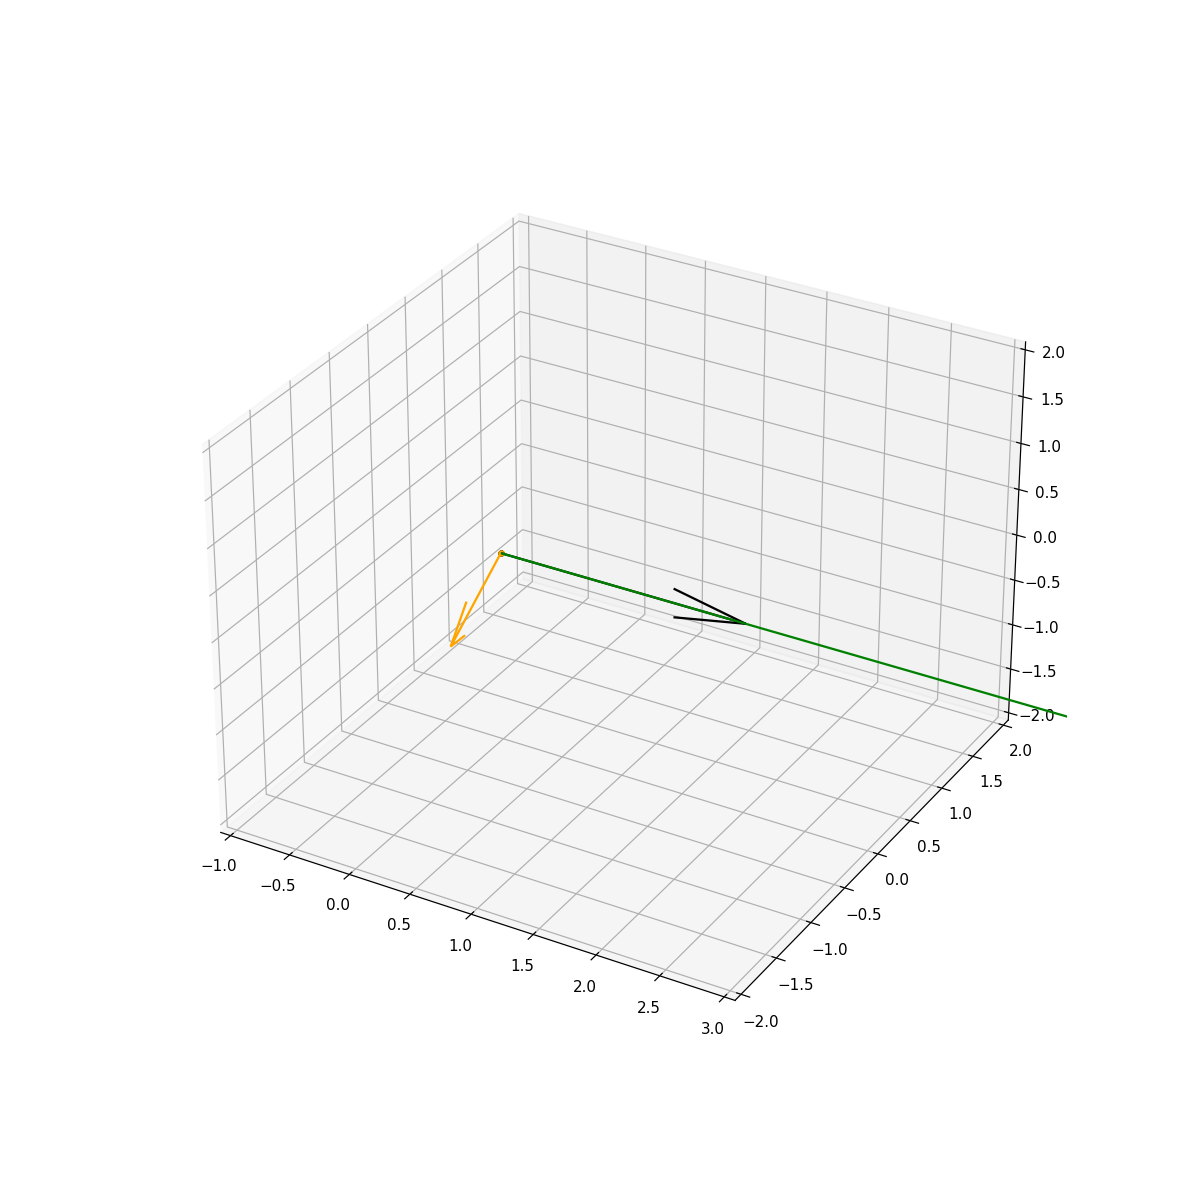

True

In [318]:
# d_oi = distance(p_r,p_o_vo)
# d_vo = ((d_oi**2)-(R**2))/d_oi
# r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
# alpha_vo = np.arctan(r_vo/d_vo)
# psi_oi,th_oi = get_azimuth_elevation(p_o_vo-p_r_vo)

print(d_oi,d_vo,r_vo)
print(alpha_vo,th_oi,psi_oi,phi)
print(np.rad2deg([alpha_vo,th_oi,psi_oi,phi]))

A = v_o_vo
D = d_vo*(unit_vector(p_o_vo-p_r_vo))

print(A,D)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
# plot_cone(ax,d_vo,alpha_vo
# #           ,offset=v_o_vo
#          )
# plot_arrow(ax,np.array([0,0,0]),p_o_vo-p_r_vo,color='red')
get_R_vo_thpsi(th_oi,psi_oi)
plot_arrow(ax,np.array([0,0,0]),np.array([d_oi,0,0]),color='green')
plot_arrow(ax,np.array([0,0,0]),v_r_vo,color='black')
# tmp = np.squeeze(
#     np.matmul(get_R_Pphi(phi).T,np.expand_dims(np.pad(v_avos, ((0,0), (0, 1)), 'constant'),-1)))-v_o_vo
# ax.scatter(tmp[:,0],tmp[:,1],tmp[:,2],color='orange',s=100)
plot_arrow(ax,np.array([0,0,0]),v_r_esc,color='orange')

# ax.plot(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,0],
#        np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,1],
#        np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1)))[:,2],color="black",linewidth=3)
# plot_sphere(ax,R,p_o_vo-p_r_vo)
ax.set_xlim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[0],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[0])

ax.set_ylim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[1],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[1])
ax.set_zlim(np.min(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[2],
            np.max(np.squeeze(np.matmul(get_R_Pphi(phi).T,np.expand_dims(M_vo_phi,-1))),0)[2])
ax.set_xlim(0,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

set_axes_equal(ax)
check_VO(p_r_vo,v_r_vo,p_o_vo,v_o_vo,R=10)

In [289]:
# tmp_a,tmp_b = lis.pop(0)
# while(len(lis)):
#     a,,b = lis.pop(0)
#     if(a>tmp_b):
#         print(tmp_a,tmp_b)
#         tmp_a,tmp_b = a,b
#     elif(b>tmp_b):
#         tmo_b = b
0.5 in range(-1,2)

False

<IPython.core.display.Javascript object>


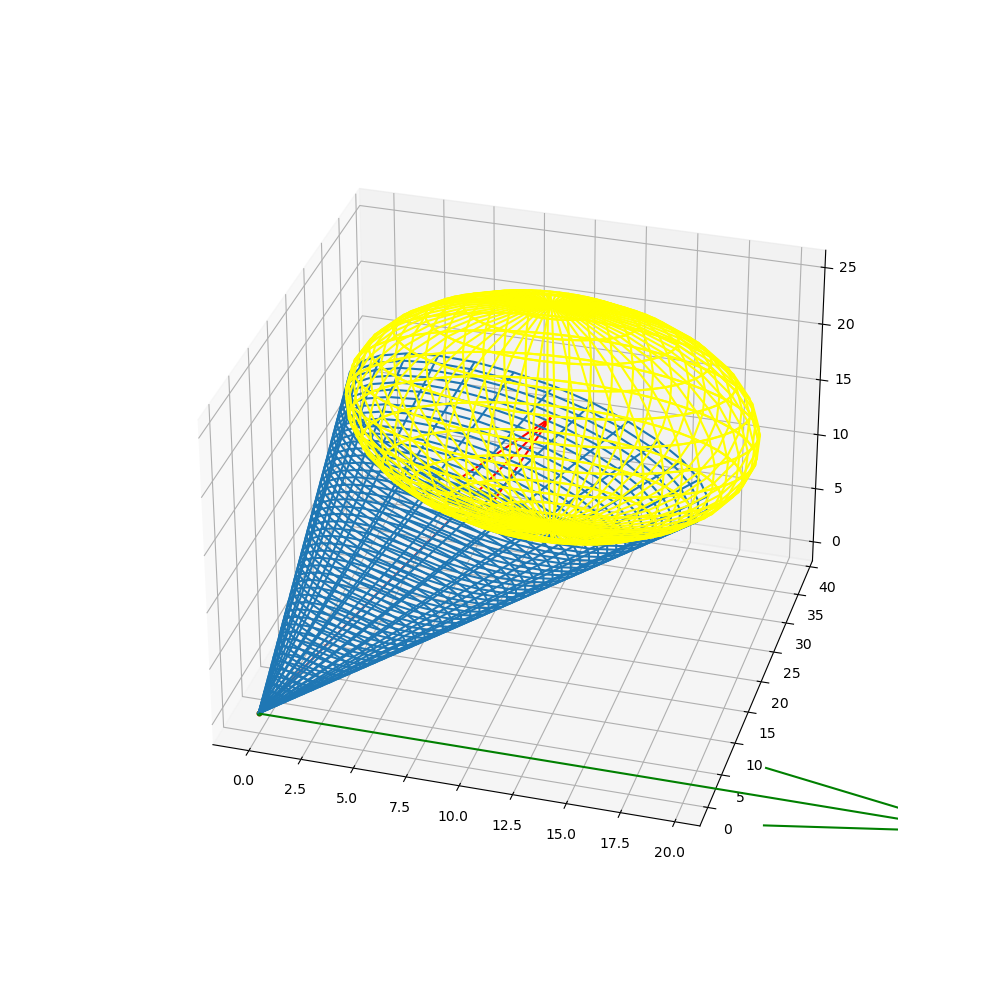

In [648]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plot_cone(ax,d_vo,alpha_vo)
plot_arrow(ax,np.array([0,0,0]),p_o-p_r,color='red')
plot_arrow(ax,np.array([0,0,0]),np.array([d_oi,0,0]),color='green')
plot_sphere(ax,R,p_o-p_r)


In [389]:
def circle_point_distance_at_angle(r,d_oi,ang):
    if(doi*np.sin(ang)<r):
        return(doi*np.cos(d_oi)+np.sqrt((r**2)-((d_oi*np.sin(ang))**2)))
    else:
        print(f"The line at {ang} does not intersect circle of radius {r} ")
        raise
def time_to_collision

In [616]:

# phi = get_single_phi(D,alpha_vo)
# print(phi)
# phi = np.deg2rad(65)



del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
print(np.rad2deg(del_p_phi))
print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))

num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
       np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
               (np.cos(b)*np.cos(psi_oi) - 
                np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
               )*np.tan(alpha_vo)))
a = num/den

M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
M_vo = (M_cc+np.expand_dims(A,-1))
M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
M_vo_phi = np.squeeze(M_vo_phi)


# print(M_vo_phi)
fig = plt.figure()
ax=fig.add_subplot(111)
print("adjnjs",(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2),np.linalg.norm(v_r)**2)
# plt.plot(np.arange(50),(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))

plt.axis("equal")
plt.plot(M_vo_phi[:,0],M_vo_phi[:,1])
plt.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
         np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))



92.64395675013186
Elliptical Check False


<IPython.core.display.Javascript object>

adjnjs [1.84444201e+00 2.35222030e+00 3.26400413e+00 5.23862581e+00
 1.13469136e+01 6.29213007e+01 1.37954277e+02 8.24330952e+00
 2.20466321e+00 8.92075810e-01 4.62820727e-01 2.98865472e-01
 2.36663467e-01 2.20134017e-01 2.26845477e-01 2.47047228e-01
 2.76523564e-01 3.13881958e-01 3.59532346e-01 4.15476715e-01
 4.85690524e-01 5.77264121e-01 7.02997929e-01 8.87419080e-01
 1.18216034e+00 1.71169903e+00 2.84369075e+00 6.10409945e+00
 2.47326189e+01 5.94426765e+03 1.91497443e+01 5.30564596e+00
 2.61262898e+00 1.66856095e+00 1.24191009e+00 1.02199760e+00
 9.01378336e-01 8.35161217e-01 8.02156513e-01 7.91591928e-01
 7.97866681e-01 8.18279312e-01 8.52019425e-01 8.99790786e-01
 9.63844411e-01 1.04841003e+00 1.16070447e+00 1.31301664e+00
 1.52712629e+00 1.84444201e+00] 4.0


In [408]:
(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-np.linalg.norm(v_r)**2

array([-0.6651922 , -0.81418706, -0.92741426, -1.01229188, -1.07453821,
       -1.11852907, -1.14759764, -1.16427192, -1.17045702, -1.16757231,
       -1.1566531 , -1.13842497, -1.1133568 , -1.0816972 , -1.0434975 ,
       -0.99862344, -0.94675682, -0.88738747, -0.81979527, -0.74302138,
       -0.65582678, -0.55663597, -0.44346278, -0.31381498, -0.16457511,
        0.00814246,  0.20915068,  0.44434042,  0.72076033,  1.04649013,
        1.43003404,  1.87873685,  2.39543602,  2.97241701,  3.58238042,
        4.16874797,  4.64283074,  4.89952601,  4.8561867 ,  4.49646098,
        3.88434231,  3.13387505,  2.3595722 ,  1.64253144,  1.02352463,
        0.51276164,  0.10315949, -0.21954425, -0.47093331, -0.6651922 ])

In [373]:
checks = np.array([check_VO(p_r,v_r,p_oi,v_oi,R=10) for p_oi,v_oi in zip(p_os,v_os)])
checks


<ipython-input-27-b75bc5fc0ebf>:6: RuntimeWarning: invalid value encountered in sqrt
  r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [374]:
v_os_coll = v_os[np.nonzero(checks)[0]]
p_os_coll = p_os[np.nonzero(checks)[0]]
print(p_o,'\n',v_o)
# [check_VO(p_r,v_r,p_o,v_o,R=10) for po,vo in zip(p_os_coll,v_os_coll)]
[(check_VO(p_r,v_r,p_o,v_o,R=10)) for v_o,p_o in zip(v_os_coll,p_os_coll)]

[ 8.31096242  6.13929414 24.89428231] 
 [-0.53436254 -0.04479422  0.24095979]


[]

In [111]:
[(check_VO(p_r,v_r,p_o,v_o,R=10)) for v_o,p_o in zip(v_os_coll,p_os_coll)]

[True, True, True, True, True, True, True]

In [166]:
def get_vo_params(p_r,v_r,p_o,v_o,beta_num=50,R=10):
    b = np.linspace(0,2*np.pi,beta_num)
    
    d_oi = distance(p_r,p_o)
    d_vo = ((d_oi**2)-(R**2))/d_oi
    r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
    alpha_vo = np.arctan(r_vo/d_vo)
    psi_oi,th_oi = get_azimuth_elevation(p_o-p_r)

    A = v_o
    D = d_vo*(unit_vector(p_o-p_r))
    return([A,D,alpha_vo,psi_oi,th_oi])
    
#     return({
#         'A':A,
#         'D':D,
#         'alpha_vo':alpha_vo,
#         'psi_oi':psi_oi,
#         'th_oi':th_oi
#            })
    

In [326]:
def find_phi(coll_Ds,coll_alpha_vos,num_linspace = 100):
    all_phis = np.linspace(0,2*np.pi,num_linspace)
    # f = lambda x : np.array([0,-np.sin(x),np.cos(x)])
    phi_vec = np.array([np.zeros_like(all_phis),-np.sin(all_phis),np.cos(all_phis)]).T
    dots = []
    for coll_D in coll_Ds:
        dots.append(np.dot(unit_vector(coll_D),phi_vec.T))
    dots = np.array(dots)
    lhs = dots+np.expand_dims(coll_alpha_vos,-1)
    print(lhs.shape)
    lhs = []
    for coll_alpha_vo in coll_alpha_vos:
        lhs.append(coll_alpha_vo+dots)
    lhs = np.array(lhs)
    print(lhs.shape)
    phi_inds_all = [set(np.nonzero(i)[0]) for i in (lhs<(np.pi/2))]
    print(phi_inds_all)
    phi_inds = set.intersection(*phi_inds_all)
    phis_allowed = all_phis[sorted(list(phi_inds))]
    return(phis_allowed)


In [327]:
coll_vo_params = np.array([(get_vo_params(p_r,v_r,p_o,v_o)) for v_o,p_o in zip(v_os_coll,p_os_coll)],dtype='object')
coll_As,coll_Ds,coll_alpha_vos,coll_psi_ois,coll_th_ois = (coll_vo_params[:,0],
                                                           coll_vo_params[:,1],
                                                           coll_vo_params[:,2],
                                                           coll_vo_params[:,3],
                                                           coll_vo_params[:,4])
coll_Ds

array([array([ 7.41289164, 14.4600523 , 17.85813183]),
       array([12.54643139, 17.145474  , 15.98421478]),
       array([23.28246804, 10.47439813, 12.34852479]),
       array([6.85566011, 3.3989036 , 3.83331194]),
       array([0.68196236, 0.22616615, 2.11086998]),
       array([16.30552608,  8.55812494,  9.3785166 ]),
       array([ 9.5217153 ,  9.57134117, 11.85106156])], dtype=object)

In [328]:

# coll_vo_params = [(get_vo_params(p_r,v_r,p_o,v_o)) for v_o,p_o in zip(v_os_coll,p_os_coll)]
coll_vo_params = np.array([(get_vo_params(p_r,v_r,p_o,v_o)) for v_o,p_o in zip(v_os_coll,p_os_coll)],dtype='object')
coll_As,coll_Ds,coll_alpha_vos,coll_psi_ois,coll_th_ois = (np.stack(coll_vo_params[:,0]),
                                                           np.stack(coll_vo_params[:,1]),
                                                           np.stack(coll_vo_params[:,2]),
                                                           np.stack(coll_vo_params[:,3]),
                                                           np.stack(coll_vo_params[:,4]))
# print(coll_vo_params)
# coll_Ds = np.array([cvop['D'] for cvop in coll_vo_params])
# coll_alpha_vos = np.array([cvop['alpha_vo'] for cvop in coll_vo_params])

print(coll_Ds.shape,coll_alpha_vos.shape)

# all_phis = np.linspace(0,2*np.pi,100)
# phi_vec = np.array([np.zeros_like(all_phis),-np.sin(all_phis),np.cos(all_phis)]).T
# # print(phi_vec)
# dots = []
# for coll_D in coll_Ds:
#     dots.append(np.dot(unit_vector(coll_D),phi_vec.T))
# dots = np.array(dots)
# print(dots.shape)
# print(dots+np.expand_dims(coll_alpha_vos,-1))
# phi_inds = [set(np.nonzero(i)[0]) for i in (
#     (np.dot(coll_Ds,np.array([np.zeros_like(all_phis),-np.sin(all_phis),np.cos(all_phis)]))
#  -np.expand_dims(coll_alpha_vos,-1))<(np.pi/2))]
# all_phis[sorted(list(set.intersection(*phi_inds)))]

pos_phis = find_phi(coll_Ds,coll_alpha_vos)
print(pos_phis)
phi = pos_phis[len(pos_phis)//2]
phi

(7, 3) (7,)
(7, 100)
(7, 7, 100)
[{0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6}]
[0.         0.06346652 0.12693304 0.19039955 0.25386607 0.31733259
 0.38079911]


0.1903995547630178

In [344]:
#Test phi check
phi = np.deg2rad(13)
for D,alpha_vo in zip(coll_Ds,coll_alpha_vos):
    del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
    print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))


Elliptical Check True
Elliptical Check True
Elliptical Check True
Elliptical Check False
Elliptical Check True
Elliptical Check False
Elliptical Check True


In [345]:
coll_alpha_vos

array([0.36867753, 0.34068249, 0.32271921, 0.72053916, 1.1077724 ,
       0.41660506, 0.46223709])

In [347]:
def get_M_vo_phi(A,th_oi,psi_oi,alpha_vo,phi,num_linspace_b):
    b = np.linspace(0,2*np.pi,num_linspace_b)

    num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
    den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
           np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
                   (np.cos(b)*np.cos(psi_oi) - 
                    np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
                   )*np.tan(alpha_vo)))
    a = num/den

    M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
    M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
    M_vo = (M_cc+np.expand_dims(A,-1))
    M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
    M_vo_phi = np.squeeze(M_vo_phi)
    return(M_vo_phi)

In [ ]:
check_VO()

22.42396075313987 17.964445277668048 8.950571027818691
0.4622370934149264 0.720413358003261 0.787997315390141 0.2007128639793479
[26.48423459 41.27664492 45.14892044 11.5       ]
[-0.20931081 -0.7266942  -0.45335432] [ 9.5217153   9.57134117 11.85106156]
57.30071325214185
Elliptical Check True
[[-9.67312320e-02 -1.67061765e-01 -3.46944695e-17]
 [-1.23511029e-01 -2.44763633e-01  4.85722573e-17]
 [-1.42125925e-01 -3.11048613e-01 -2.77555756e-17]
 [-1.54399374e-01 -3.67921452e-01 -6.93889390e-17]
 [-1.61682411e-01 -4.17003088e-01  1.38777878e-17]
 [-1.64975574e-01 -4.59594623e-01 -4.16333634e-17]
 [-1.65019149e-01 -4.96737212e-01  1.38777878e-17]
 [-1.62358911e-01 -5.29262956e-01 -2.77555756e-17]
 [-1.57393643e-01 -5.57836136e-01  6.93889390e-17]
 [-1.50409283e-01 -5.82985711e-01  4.16333634e-17]
 [-1.41603330e-01 -6.05130457e-01 -1.38777878e-17]
 [-1.31102075e-01 -6.24598066e-01  0.00000000e+00]
 [-1.18972494e-01 -6.41639335e-01  0.00000000e+00]
 [-1.05230057e-01 -6.56438301e-01  2.77555

<IPython.core.display.Javascript object>


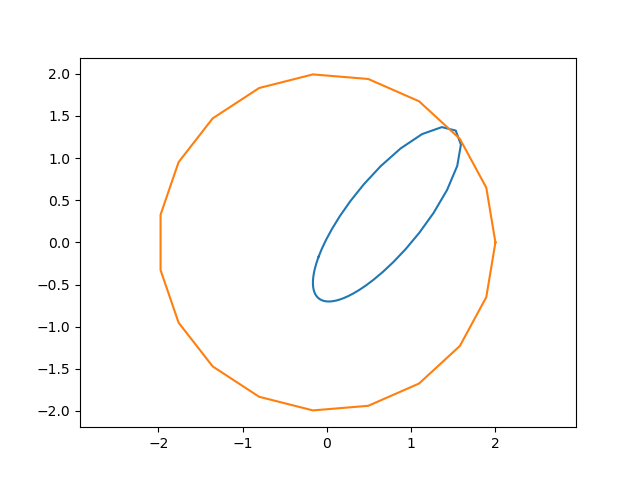

ass [3.72665644e-02 7.51642104e-02 1.16951019e-01 1.59205362e-01
 2.00032777e-01 2.38444158e-01 2.73979178e-01 3.06479693e-01
 3.35953913e-01 3.62495292e-01 3.86234373e-01 4.07310498e-01
 4.25855491e-01 4.41984608e-01 4.55791963e-01 4.67348873e-01
 4.76704356e-01 4.83887711e-01 4.88913644e-01 4.91791184e-01
 4.92538654e-01 4.91208563e-01 4.87928931e-01 4.82971846e-01
 4.76867267e-01 4.70591892e-01 4.65882120e-01 4.65750102e-01
 4.75324616e-01 5.03187168e-01 5.63387513e-01 6.78160153e-01
 8.80630991e-01 1.21464586e+00 1.72420927e+00 2.41958193e+00
 3.21435771e+00 3.87583000e+00 4.09858600e+00 3.73192117e+00
 2.92918563e+00 2.01081487e+00 1.22608410e+00 6.66513723e-01
 3.16200478e-01 1.21512881e-01 2.97210879e-02 1.14047942e-03
 9.22060833e-03 3.72665644e-02] 4.0


In [355]:
# b = symbols('b')
b = np.linspace(0,2*np.pi,50)

R = 10
d_oi = distance(p_r,p_o)
d_vo = ((d_oi**2)-(R**2))/d_oi
r_vo = R*((np.sqrt((d_oi**2)-(R**2)))/d_oi)
alpha_vo = np.arctan(r_vo/d_vo)
psi_oi,th_oi = get_azimuth_elevation(p_o-p_r)

phi = np.deg2rad(11.5)
print(d_oi,d_vo,r_vo)
print(alpha_vo,th_oi,psi_oi,phi)
print(np.rad2deg([alpha_vo,th_oi,psi_oi,phi]))

A = v_o
D = d_vo*(unit_vector(p_o-p_r))

print(A,D)

del_p_phi = np.arccos(np.dot(unit_vector(D),[0,-np.sin(phi),np.cos(phi)]))
print(np.rad2deg(del_p_phi))
print("Elliptical Check",del_p_phi<((np.pi/2)-alpha_vo))

num = (-(A[2]*np.cos(phi)) + A[1]*np.sin(phi))
den = (np.cos(phi)*(np.sin(th_oi) + np.cos(th_oi)*np.sin(b)*np.tan(alpha_vo)) -
       np.sin(phi)*(np.cos(th_oi)*np.sin(psi_oi) +
               (np.cos(b)*np.cos(psi_oi) - 
                np.sin(b)*np.sin(th_oi)*np.sin(psi_oi)
               )*np.tan(alpha_vo)))
a = num/den

M_cc_st = np.array([a,a*np.tan(alpha_vo)*np.cos(b),a*np.tan(alpha_vo)*np.sin(b)]).T
M_cc = (np.matmul(get_R_vo_thpsi(th_oi,psi_oi),np.expand_dims(M_cc_st,2)))
M_vo = (M_cc+np.expand_dims(A,-1))
M_vo_phi = np.matmul(get_R_Pphi(phi),M_vo)
M_vo_phi = np.squeeze(M_vo_phi)


print(M_vo_phi)
fig = plt.figure()
ax=fig.add_subplot(111)
print("ass",(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2),np.linalg.norm(v_r)**2)
# plt.plot(np.arange(50),(M_vo_phi[:,0]**2+M_vo_phi[:,1]**2)-(np.linalg.norm(v_r)**2))

plt.axis("equal")
plt.plot(M_vo_phi[:,0],M_vo_phi[:,1])
plt.plot(np.linalg.norm(v_r)*np.cos(np.linspace(0,2*np.pi,20)),
         np.linalg.norm(v_r)*np.sin(np.linspace(0,2*np.pi,20)))
